Ben Ghertner 2025

This code generates the nonlinear inversion wave solution of Chapter 4 then preforms convergence checks on the residual of the solution substituted into the full PDE operator and interface conditions.

Note: The inversion wave solution is the same as in nl_wave_sol.ipynb. See that notebook for further comments on solution code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import scipy.fft as sfft

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.usetex'] = True
plt.rcParams["font.size"] = 11

%matplotlib inline

In [2]:
# Uses secant method to numerically solve the dispersion relationship Det(M) = 0 
# with M given in Eq (3.44) for the frequency of the wave
#
# input:
#       om_0 - first guess at frequency
#       N2c  - buoyancy frequency in cloud
#       N2i  - buoyancy frequency in inversion (clear)
#       N2t  - buoyancy frequency in troposphere (above inversion)
#       Hc   - nominal height of cloud edge 
#       Hi   - nominal height of inversion edge
#       HT   - domain top height 
# returns:
#       om   - frequency (numerically) satisfying Det(M) = 0
def secant_omega(om_0, N2c, N2i, N2t, Hc, Hi, HT, k):
    # Dispersion relationship function Det(M) 
    # as a function of the frequency
    #
    # input:
    #       om - frequency
    # returns:
    #       Det(M) from Eq (3.44)
    def f(om):
        #Vertical wavenumbers
        mt = k*np.sqrt(1 - N2t/om**2)
        mi = k*np.sqrt(N2i/om**2 - 1)
        mc = k*np.sqrt(1 - N2c/om**2)
        
        #as in Eq (3.44)
        M = np.array([[mt*np.sin(mi*Hi)/np.tanh(mt*(Hi-HT)) - mi*np.cos(mi*Hi),
                       mt*np.cos(mi*Hi)/np.tanh(mt*(Hi-HT)) + mi*np.sin(mi*Hi)],

                      [mi*np.cos(mi*Hc) - mc*np.sin(mi*Hc)/np.tanh(mc*Hc),
                      -mi*np.sin(mi*Hc) - mc*np.cos(mi*Hc)/np.tanh(mc*Hc)]])
        return np.linalg.det(M)
    #Initialize first guesses at the frequency
    om_m1 = om_0
    om_m2 = om_0*(1.001)
    #Iterate until tolerance is met
    while(np.abs((om_m1-om_m2)/om_m1)>1e-15):
        #Save last guess
        temp = om_m1
        #Secant step
        om_m1 = om_m1 - f(om_m1)*(om_m1-om_m2)/(f(om_m1)-f(om_m2))
        #update last guess
        om_m2 = temp
        
    return om_m1

In [3]:
#sympy symbols (variables)
k, z, x, t, X, T, sig, L = sym.symbols('k, z, x, t, X, T, sigma, L', real=True)
om, om_p = sym.symbols("omega omega_k", real=True)
c = om/k
I = sym.I #sympy imaginary unit for convience

#From Table 4.1 
N2c = (2*np.pi)**2
N2i = 2*(2*np.pi)**2
N2t = np.pi**2

Hc = 2.
Hi = 4.
HT = 10.

mt = k*sym.sqrt(1 - N2t/om**2)
mi = k*sym.sqrt(N2i/om**2 - 1)
mc = k*sym.sqrt(1 - N2c/om**2)

k_val  = 2.2
#Find frequency for the given wavenumber and parameters
om_val = secant_omega(2.5*np.pi+0.j, N2c=N2c, N2i=N2i, N2t=N2t, Hc=Hc, Hi=Hi, HT=HT, k=k_val)
print(f'omega: {om_val:.5f}')
print(f'mt:    {mt.subs({k:k_val,om:om_val}):.5f}')
print(f'mi:    {mi.subs({k:k_val,om:om_val}):.5f}')
print(f'mc:    {mc.subs({k:k_val,om:om_val})}')

omega: 8.06055+0.00000j
mt:    2.02603
mi:    1.02066
mc:    1.37808969935558


In [4]:
# Helpful function to plug in k and omega values and evaluate
#
# inputs:
#       f      - sympy expression to be evaluated
#       z      - evalutation points
#       k_val  - numerical value of the horizontal wavenumber
#       om_val - numerical value of the frequency of the wave
#       L_val  - latent heat response
#       sigma  - nonlinear parameter (mu in my thesis)
# returns:
#       f_eval - the expression f evaluated at the given points
def sym_to_eval(f, zz, L_val=0.5, sigma=0.1):
    val_dict = {
        k:   k_val,
        om:  om_val,
        L :  L_val,
        sig: sigma
    }
    return sym.lambdify(z, f.subs(val_dict))(zz)

In [5]:
#Matrix elements of M from Eq (3.44)
a = mt*sym.sin(mi*Hi)/sym.tanh(mt*(Hi-HT)) - mi*sym.cos(mi*Hi)
b = mt*sym.cos(mi*Hi)/sym.tanh(mt*(Hi-HT)) + mi*sym.sin(mi*Hi)

c = mi*sym.cos(mi*Hc) - mc*sym.sin(mi*Hc)/sym.tanh(mc*Hc)
d =-mi*sym.sin(mi*Hc) - mc*sym.cos(mi*Hc)/sym.tanh(mc*Hc)

#Eigenvectors - make sure eigenvector 1 is the zero eigenvector
print('lambda1 needs to be (numerically) 0')
print(f'lambda2 : {(1/2)*(sym.sqrt((a - d)**2 + 4*b*c) + a + d).subs({k:   k_val, om:  om_val})}')
v2 = [
    (a - d + sym.sqrt((a - d)**2 + 4*b*c))/(2*c),
    1
]

print(f'lambda1 : {(1/2)*(-sym.sqrt((a - d)**2 + 4*b*c) + a + d).subs({k:   k_val, om:  om_val})}')
v1 = [
    (a - d - sym.sqrt((a - d)**2 + 4*b*c))/(2*c),
    1
]

lambda1 needs to be (numerically) 0
lambda2 : 1.95855286165579
lambda1 : -2.83106871279415E-15


In [6]:
#Leading Order Solution
psia_t = sym.sin(mi*Hi)*sym.sinh(mt*(z-HT))/sym.sinh(mt*(Hi-HT))
psia_i = sym.sin(mi*z)
psia_c = sym.sin(mi*Hc)*sym.sinh(mc*z)/sym.sinh(mc*Hc)

psib_t = sym.cos(mi*Hi)*sym.sinh(mt*(z-HT))/sym.sinh(mt*(Hi-HT))
psib_i = sym.cos(mi*z)
psib_c = sym.cos(mi*Hc)*sym.sinh(mc*z)/sym.sinh(mc*Hc)

psih_0_t = v1[0]*psia_t + v1[1]*psib_t
psih_0_i = v1[0]*psia_i + v1[1]*psib_i
psih_0_c = v1[0]*psia_c + v1[1]*psib_c

Bh_0_t   = N2t*k/om*psih_0_t
Bh_0_i   = N2i*k/om*psih_0_i
Bh_0_c   = N2c*k/om*psih_0_c

Zih_0     =       -k/om*psih_0_i.subs({z: Hi})
Zch_0     = -(1+L)*k/om*psih_0_i.subs({z: Hc})

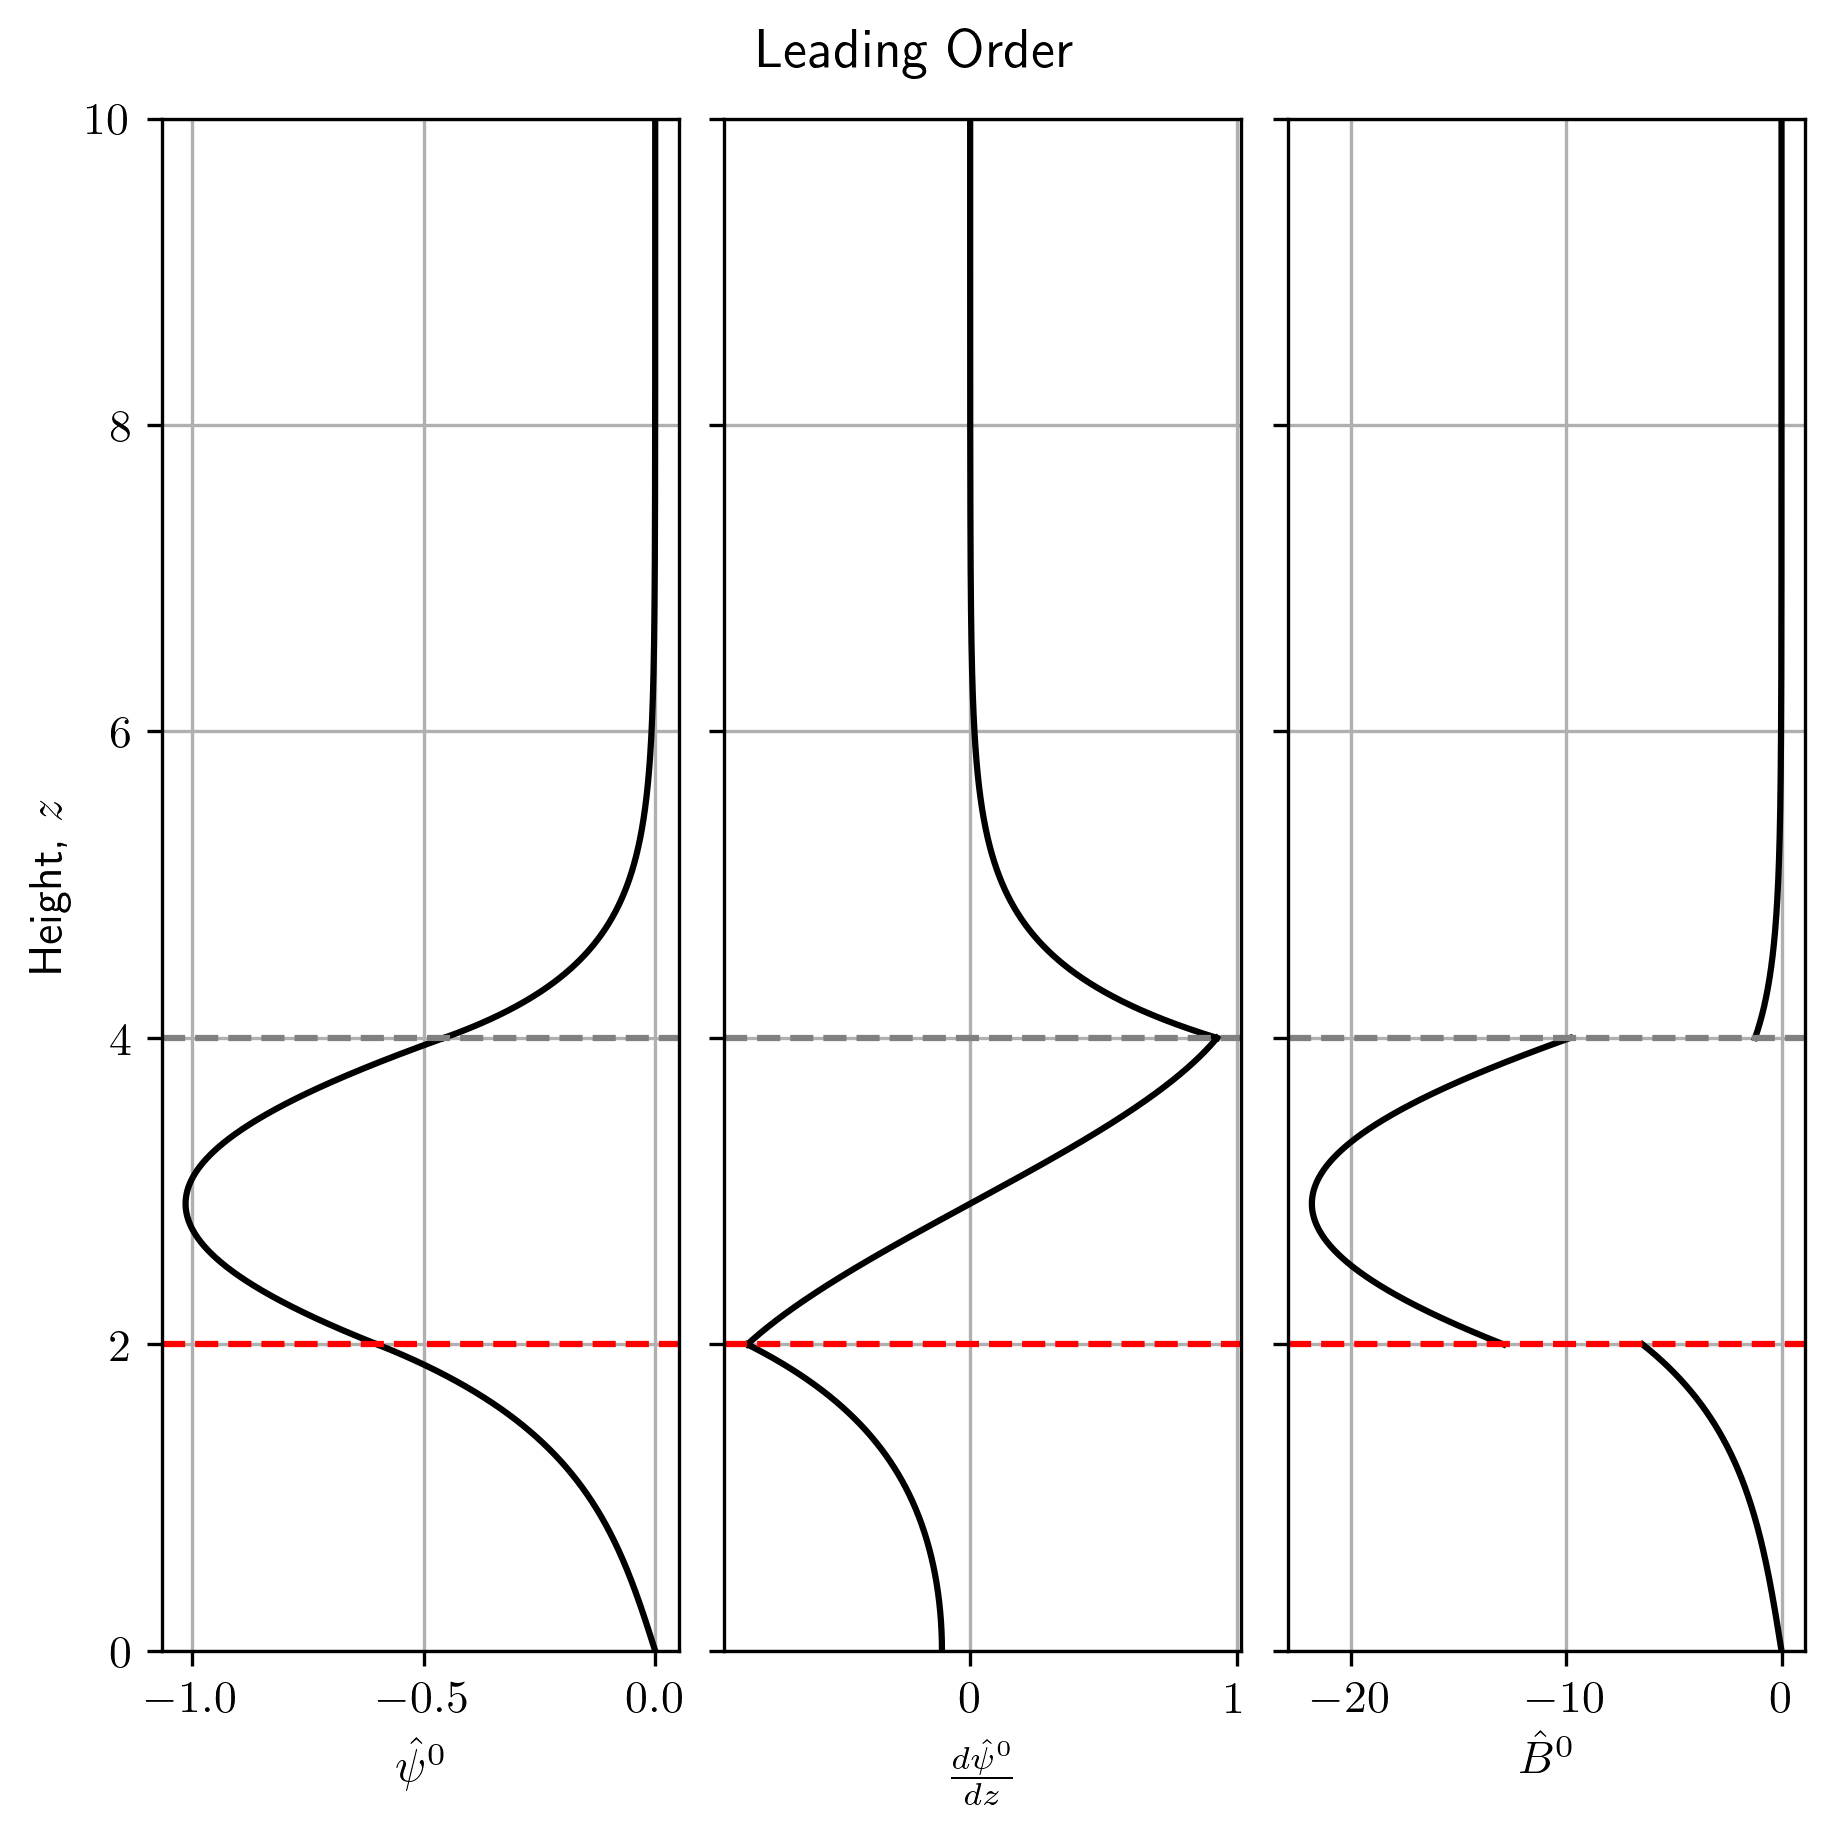

In [7]:
#Plot Leading Order Normal Modes
fig, axes = plt.subplots(ncols=3, sharey=True, layout='constrained')
fig.set_dpi(300)
fig.set_size_inches(6,6)
fig.suptitle('Leading Order')

zt = np.linspace(Hi, HT, num=1000)
zi = np.linspace(Hc, Hi, num=1000)
zc = np.linspace(0., Hc, num=1000)

axes[0].plot(sym_to_eval(psih_0_t, zt), zt, 'k')
axes[0].plot(sym_to_eval(psih_0_i, zi), zi, 'k')
axes[0].plot(sym_to_eval(psih_0_c, zc), zc, 'k')
axes[0].grid()
axes[0].set(xlabel=r'$\hat{\psi}^0$', ylabel='Height, $z$')
axes[0].set(ylim=(0.,HT))
axes[0].axhline(Hc,color='red',linestyle='--')
axes[0].axhline(Hi,color='grey',linestyle='--')

axes[1].plot(sym_to_eval(sym.diff(psih_0_t,z), zt), zt, 'k')
axes[1].plot(sym_to_eval(sym.diff(psih_0_i,z), zi), zi, 'k')
axes[1].plot(sym_to_eval(sym.diff(psih_0_c,z), zc), zc, 'k')
axes[1].grid()
axes[1].set(xlabel=r'$\frac{d\hat{\psi}^0}{dz}$')
axes[1].axhline(Hc,color='red',linestyle='--')
axes[1].axhline(Hi,color='grey',linestyle='--')

axes[2].plot(sym_to_eval(Bh_0_t, zt), zt, 'k')
axes[2].plot(sym_to_eval(Bh_0_i, zi), zi, 'k')
axes[2].plot(sym_to_eval(Bh_0_c, zc), zc, 'k')
axes[2].grid()
axes[2].set(xlabel=r'$\hat{B}^0$')
axes[2].axhline(Hc,color='red',linestyle='--')
axes[2].axhline(Hi,color='grey',linestyle='--')

plt.show()

In [8]:
#Build phi function
phi_t = v2[0]*psia_t + v2[1]*psib_t
phi_i = v2[0]*psia_i + v2[1]*psib_i
phi_c = v2[0]*psia_c + v2[1]*psib_c

#phi derivative jump at inversion
J_dphi = sym_to_eval(sym.diff(phi_t,z), Hi)-sym_to_eval(sym.diff(phi_i,z), Hi)

In [9]:
#Compute psi^X, psi^T

psih_X_t = -I*sym.diff(psih_0_t, k)
psih_X_i = -I*sym.diff(psih_0_i, k)
psih_X_c = -I*sym.diff(psih_0_c, k)

psih_T_t =  I*sym.diff(psih_0_t, om)
psih_T_i =  I*sym.diff(psih_0_i, om)
psih_T_c =  I*sym.diff(psih_0_c, om)

# Add phi to make derivative continuity at Hi
del_X_Hi = sym_to_eval(sym.diff(psih_X_t,z), Hi)-sym_to_eval(sym.diff(psih_X_i,z), Hi)
del_T_Hi = sym_to_eval(sym.diff(psih_T_t,z), Hi)-sym_to_eval(sym.diff(psih_T_i,z), Hi)

alpha_X = -del_X_Hi/J_dphi
alpha_T = -del_T_Hi/J_dphi

psih_X_t += alpha_X*phi_t
psih_X_i += alpha_X*phi_i
psih_X_c += alpha_X*phi_c

psih_T_t += alpha_T*phi_t
psih_T_i += alpha_T*phi_i
psih_T_c += alpha_T*phi_c

del_X = sym_to_eval(sym.diff(psih_X_i,z), Hc)-sym_to_eval(sym.diff(psih_X_c,z), Hc)
del_T = sym_to_eval(sym.diff(psih_T_i,z), Hc)-sym_to_eval(sym.diff(psih_T_c,z), Hc)

om_p = del_X/del_T

print(f'group velocity = {om_p}')

Bh_X_t = N2t*k/om*psih_X_t - I*N2t/om*psih_0_t
Bh_X_i = N2i*k/om*psih_X_i - I*N2i/om*psih_0_i
Bh_X_c = N2c*k/om*psih_X_c - I*N2c/om*psih_0_c

Bh_T_t =  N2t*k/om*psih_T_t - I*N2t*k/om**2*psih_0_t
Bh_T_i =  N2i*k/om*psih_T_i - I*N2i*k/om**2*psih_0_i
Bh_T_c =  N2c*k/om*psih_T_c - I*N2c*k/om**2*psih_0_c

Zih_X   =  -k/om*psih_X_i.subs({z:Hi}) + I/om*psih_0_i.subs({z:Hi})
Zih_T   =  -k/om*psih_T_i.subs({z:Hi}) + I*k/om**2*psih_0_i.subs({z:Hi})

Zch_X   =  -(1+L)*k/om*psih_X_i.subs({z:Hc}) + (1+L)*I/om*psih_0_i.subs({z:Hc})
Zch_T   =  -(1+L)*k/om*psih_T_i.subs({z:Hc}) + (1+L)*I*k/om**2*psih_0_i.subs({z:Hc})

group velocity = (0.43767858227995493+0j)


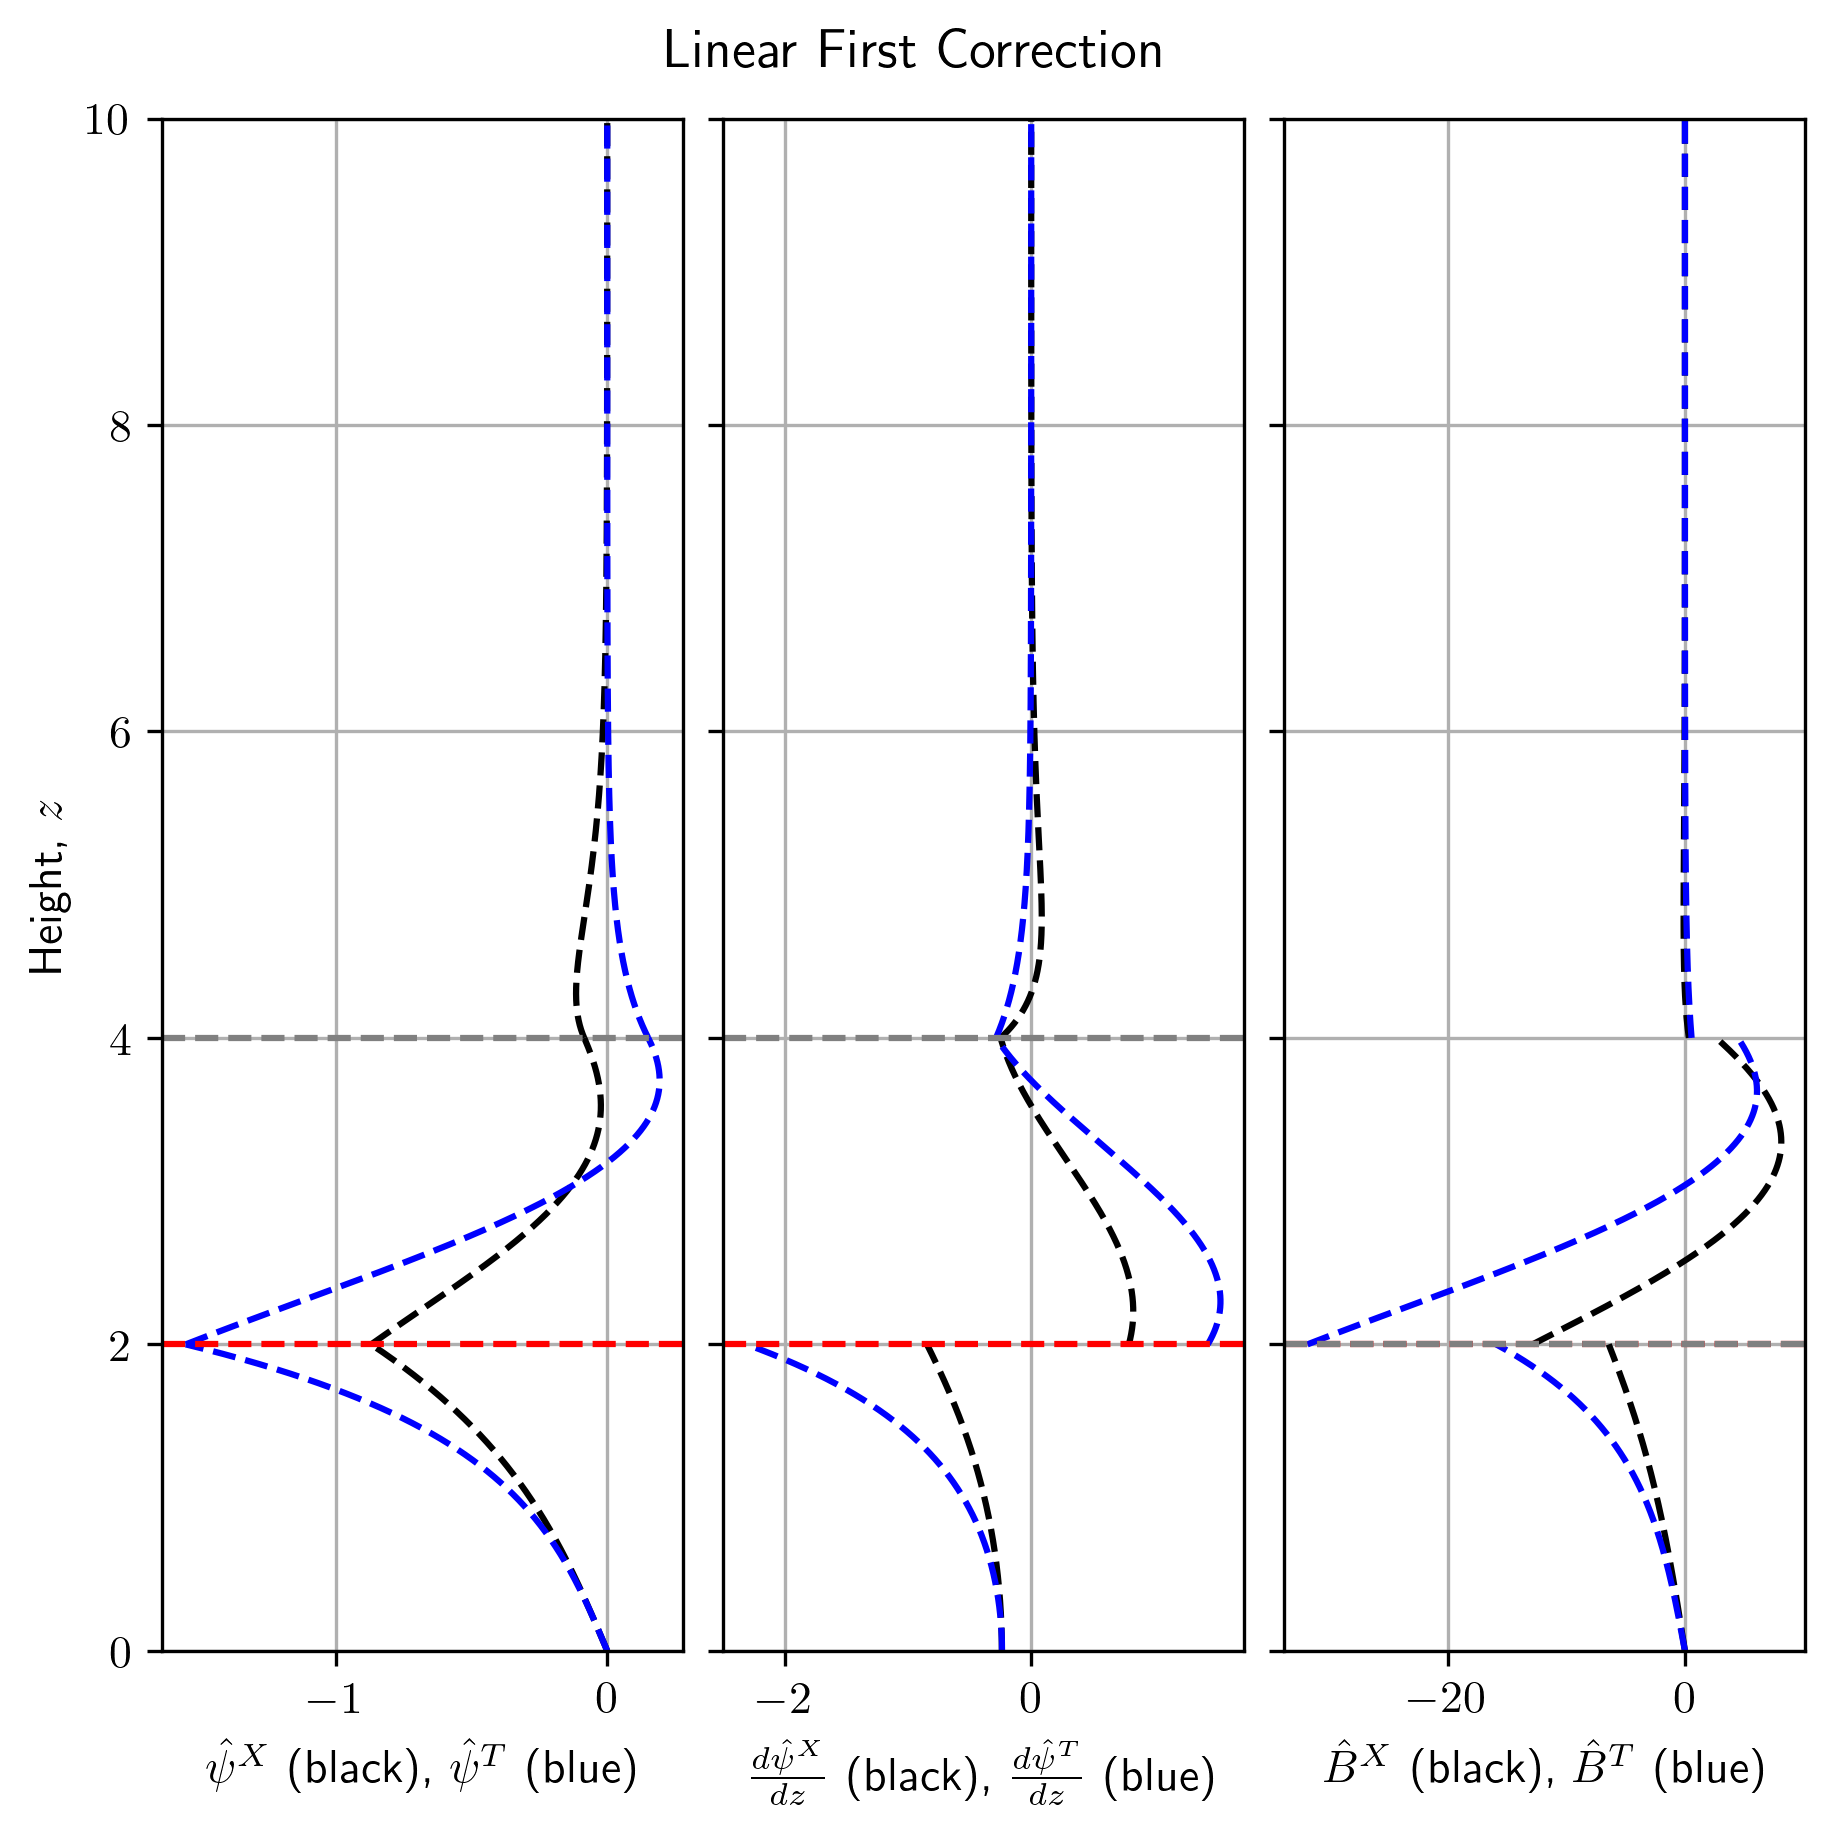

In [10]:
#Plot Linear First Corrections
fig, axes = plt.subplots(ncols=3, sharey=True, layout='constrained')
fig.set_dpi(300)
fig.set_size_inches(6,6)
fig.suptitle('Linear First Correction')

zt = np.linspace(Hi, HT, num=1000)
zi = np.linspace(Hc, Hi, num=1000)
zc = np.linspace(0., Hc, num=1000)

axes[0].plot(sym_to_eval(psih_X_t, zt).imag, zt, '--k')
axes[0].plot(sym_to_eval(psih_X_i, zi).imag, zi, '--k')
axes[0].plot(sym_to_eval(psih_X_c, zc).imag, zc, '--k')
axes[0].plot(sym_to_eval(psih_T_t, zt).imag, zt, '--b')
axes[0].plot(sym_to_eval(psih_T_i, zi).imag, zi, '--b')
axes[0].plot(sym_to_eval(psih_T_c, zc).imag, zc, '--b')
axes[0].grid()
axes[0].set(xlabel=r'$\hat{\psi}^X$ (black), $\hat{\psi}^T$ (blue)', ylabel='Height, $z$')
axes[0].set(ylim=(0.,HT))
axes[0].axhline(Hc,color='red',linestyle='--')
axes[0].axhline(Hi,color='grey',linestyle='--')

axes[1].plot(sym_to_eval(sym.diff(psih_X_t,z), zt).imag, zt, '--k')
axes[1].plot(sym_to_eval(sym.diff(psih_X_i,z), zi).imag, zi, '--k')
axes[1].plot(sym_to_eval(sym.diff(psih_X_c,z), zc).imag, zc, '--k')
axes[1].plot(sym_to_eval(sym.diff(psih_T_t,z), zt).imag, zt, '--b')
axes[1].plot(sym_to_eval(sym.diff(psih_T_i,z), zi).imag, zi, '--b')
axes[1].plot(sym_to_eval(sym.diff(psih_T_c,z), zc).imag, zc, '--b')
axes[1].grid()
axes[1].set(xlabel=r'$\frac{d\hat{\psi}^X}{dz}$ (black), $\frac{d\hat{\psi}^T}{dz}$ (blue)')
axes[1].axhline(Hc,color='red',linestyle='--')
axes[1].axhline(Hi,color='grey',linestyle='--')

axes[2].plot(sym_to_eval(Bh_X_t, zt).imag, zt, '--k')
axes[2].plot(sym_to_eval(Bh_X_i, zi).imag, zi, '--k')
axes[2].plot(sym_to_eval(Bh_X_c, zc).imag, zc, '--k')
axes[2].plot(sym_to_eval(Bh_T_t, zt).imag, zt, '--b')
axes[2].plot(sym_to_eval(Bh_T_i, zi).imag, zi, '--b')
axes[2].plot(sym_to_eval(Bh_T_c, zc).imag, zc, '--b')
axes[2].grid()
axes[2].set(xlabel=r'$\hat{B}^X$ (black), $\hat{B}^T$ (blue)')
axes[2].axhline(Hc,color='red',linestyle='--')
axes[2].axhline(Hc,color='grey',linestyle='--')

plt.show()

In [11]:
#Compute psi^XX, psi^TX, psi^TT

psih_XX_t = -sym.diff(psih_0_t, k, k)/2 - I*alpha_X*sym.diff(phi_t, k)
psih_XX_i = -sym.diff(psih_0_i, k, k)/2 - I*alpha_X*sym.diff(phi_i, k)
psih_XX_c = -sym.diff(psih_0_c, k, k)/2 - I*alpha_X*sym.diff(phi_c, k)

psih_TX_t =  sym.diff(psih_0_t, om, k) - I*alpha_T*sym.diff(phi_t, k) + I*alpha_X*sym.diff(phi_t, om)
psih_TX_i =  sym.diff(psih_0_i, om, k) - I*alpha_T*sym.diff(phi_i, k) + I*alpha_X*sym.diff(phi_i, om)
psih_TX_c =  sym.diff(psih_0_c, om, k) - I*alpha_T*sym.diff(phi_c, k) + I*alpha_X*sym.diff(phi_c, om)

psih_TT_t = -sym.diff(psih_0_t, om, om)/2 + I*alpha_T*sym.diff(phi_t, om)
psih_TT_i = -sym.diff(psih_0_i, om, om)/2 + I*alpha_T*sym.diff(phi_i, om)
psih_TT_c = -sym.diff(psih_0_c, om, om)/2 + I*alpha_T*sym.diff(phi_c, om)

del_XX_Hi = sym_to_eval(sym.diff(psih_XX_t,z), Hi)-sym_to_eval(sym.diff(psih_XX_i,z), Hi)
del_TX_Hi = sym_to_eval(sym.diff(psih_TX_t,z), Hi)-sym_to_eval(sym.diff(psih_TX_i,z), Hi)
del_TT_Hi = sym_to_eval(sym.diff(psih_TT_t,z), Hi)-sym_to_eval(sym.diff(psih_TT_i,z), Hi)

alpha_XX = -del_XX_Hi/J_dphi
alpha_TX = -del_TX_Hi/J_dphi
alpha_TT = -del_TT_Hi/J_dphi

psih_XX_t += alpha_XX*phi_t
psih_XX_i += alpha_XX*phi_i
psih_XX_c += alpha_XX*phi_c

psih_TX_t += alpha_TX*phi_t
psih_TX_i += alpha_TX*phi_i
psih_TX_c += alpha_TX*phi_c

psih_TT_t += alpha_TT*phi_t
psih_TT_i += alpha_TT*phi_i
psih_TT_c += alpha_TT*phi_c

del_XX_Hi = sym_to_eval(sym.diff(psih_XX_t,z), Hi)-sym_to_eval(sym.diff(psih_XX_i,z), Hi)
del_TX_Hi = sym_to_eval(sym.diff(psih_TX_t,z), Hi)-sym_to_eval(sym.diff(psih_TX_i,z), Hi)
del_TT_Hi = sym_to_eval(sym.diff(psih_TT_t,z), Hi)-sym_to_eval(sym.diff(psih_TT_i,z), Hi)

del_XX = sym_to_eval(sym.diff(psih_XX_i,z), Hc)-sym_to_eval(sym.diff(psih_XX_c,z), Hc)
del_TX = sym_to_eval(sym.diff(psih_TX_i,z), Hc)-sym_to_eval(sym.diff(psih_TX_c,z), Hc)
del_TT = sym_to_eval(sym.diff(psih_TT_i,z), Hc)-sym_to_eval(sym.diff(psih_TT_c,z), Hc)

om_pp = (del_XX/del_T + om_p**2*del_TT/del_T - om_p*del_TX/del_T)*2j

print(f'd^2 om/ d k^2  = {om_pp}')

Bh_XX_t = N2t*k/om*psih_XX_t - I*N2t/om*psih_X_t
Bh_XX_i = N2i*k/om*psih_XX_i - I*N2i/om*psih_X_i
Bh_XX_c = N2c*k/om*psih_XX_c - I*N2c/om*psih_X_c

Bh_TX_t =  N2t*k/om*psih_TX_t - I*N2t/om*psih_T_t - I*N2t*k/om**2*psih_X_t - N2t/om**2*psih_0_t
Bh_TX_i =  N2i*k/om*psih_TX_i - I*N2i/om*psih_T_i - I*N2i*k/om**2*psih_X_i - N2i/om**2*psih_0_i
Bh_TX_c =  N2c*k/om*psih_TX_c - I*N2c/om*psih_T_c - I*N2c*k/om**2*psih_X_c - N2c/om**2*psih_0_c

Bh_TT_t = N2t*k/om*psih_TT_t - I*N2t*k/om**2*psih_T_t - N2t*k/om**3*psih_0_t
Bh_TT_i = N2i*k/om*psih_TT_i - I*N2i*k/om**2*psih_T_i - N2i*k/om**3*psih_0_i
Bh_TT_c = N2c*k/om*psih_TT_c - I*N2c*k/om**2*psih_T_c - N2c*k/om**3*psih_0_c

d^2 om/ d k^2  = (-0.35286542995832304+0j)


/Users/benjaminghertner/opt/anaconda3/envs/envPython3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/benjaminghertner/opt/anaconda3/envs/envPython3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


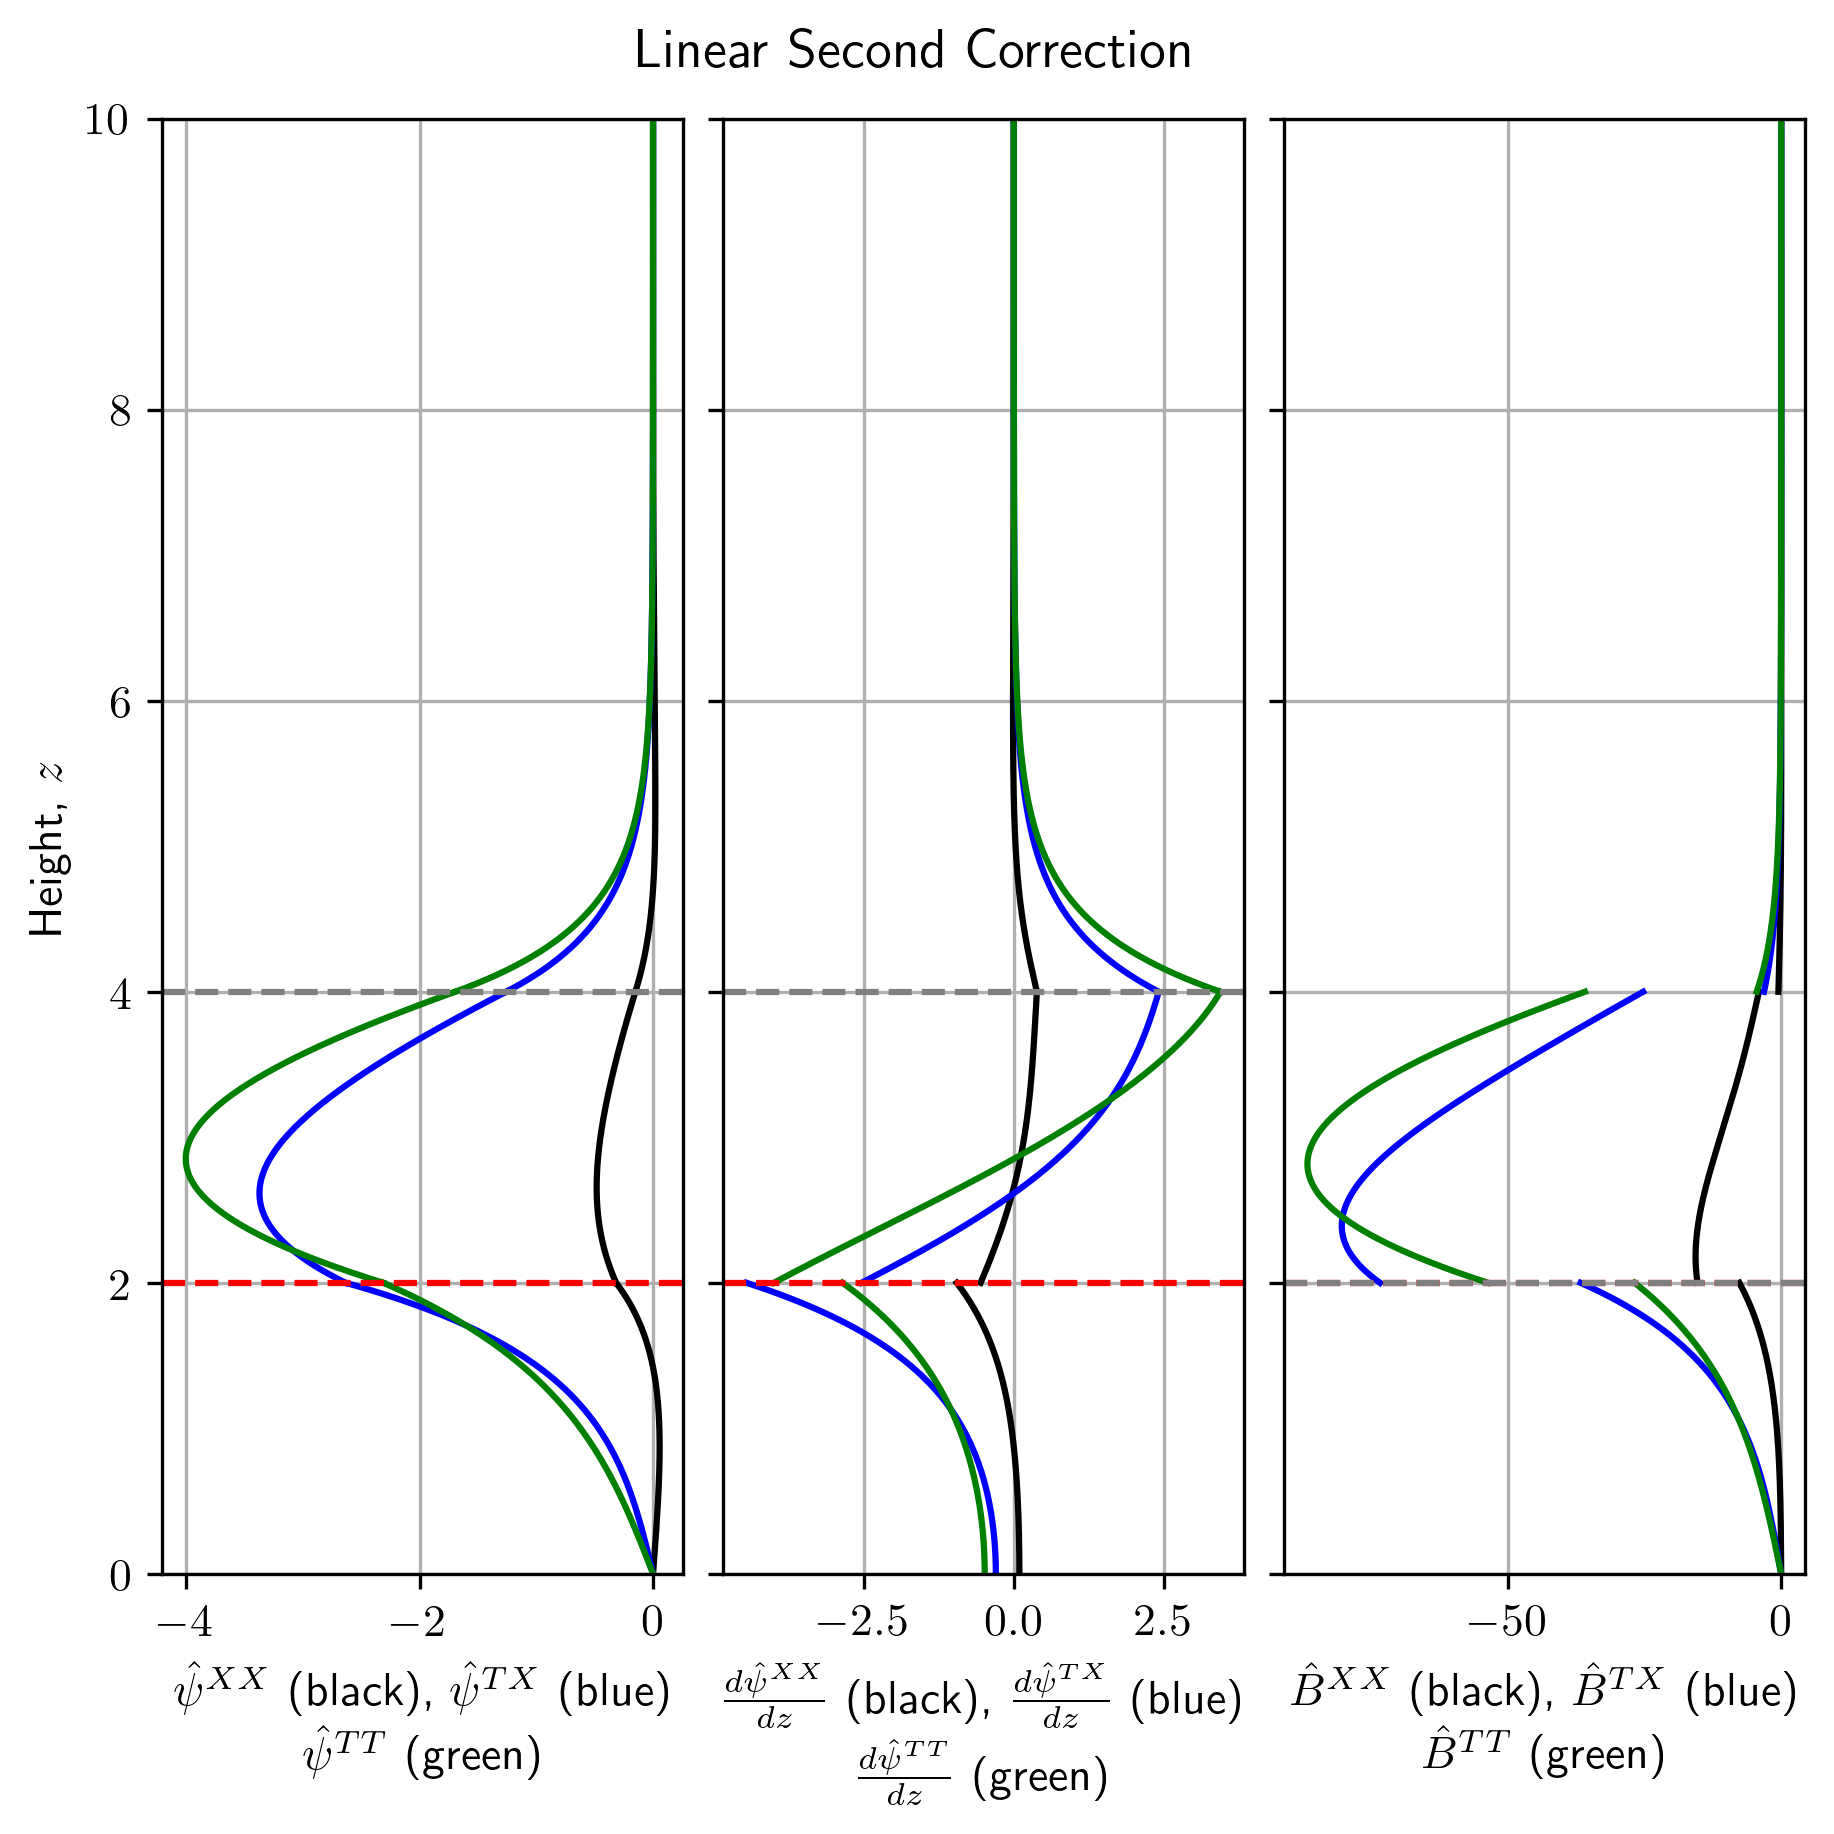

In [12]:
#Plot Linear Second Corrections
fig, axes = plt.subplots(ncols=3, sharey=True, layout='constrained')
fig.set_dpi(300)
fig.set_size_inches(6,6)
fig.suptitle('Linear Second Correction')

zt = np.linspace(Hi, HT, num=1000)
zi = np.linspace(Hc, Hi, num=1000)
zc = np.linspace(0., Hc, num=1000)

axes[0].plot(sym_to_eval(psih_XX_t, zt), zt, 'k')
axes[0].plot(sym_to_eval(psih_XX_i, zi), zi, 'k')
axes[0].plot(sym_to_eval(psih_XX_c, zc), zc, 'k')
axes[0].plot(sym_to_eval(psih_TX_t, zt), zt, 'b')
axes[0].plot(sym_to_eval(psih_TX_i, zi), zi, 'b')
axes[0].plot(sym_to_eval(psih_TX_c, zc), zc, 'b')
axes[0].plot(sym_to_eval(psih_TT_t, zt), zt, 'g')
axes[0].plot(sym_to_eval(psih_TT_i, zi), zi, 'g')
axes[0].plot(sym_to_eval(psih_TT_c, zc), zc, 'g')
axes[0].grid()
axes[0].set(xlabel=r'$\hat{\psi}^{XX}$ (black), $\hat{\psi}^{TX}$ (blue)' + '\n' + r'$\hat{\psi}^{TT}$ (green)', ylabel='Height, $z$')
axes[0].set(ylim=(0.,HT))
axes[0].axhline(Hc,color='red',linestyle='--')
axes[0].axhline(Hi,color='grey',linestyle='--')

axes[1].plot(sym_to_eval(sym.diff(psih_XX_t,z), zt), zt, 'k')
axes[1].plot(sym_to_eval(sym.diff(psih_XX_i,z), zi), zi, 'k')
axes[1].plot(sym_to_eval(sym.diff(psih_XX_c,z), zc), zc, 'k')
axes[1].plot(sym_to_eval(sym.diff(psih_TX_t,z), zt), zt, 'b')
axes[1].plot(sym_to_eval(sym.diff(psih_TX_i,z), zi), zi, 'b')
axes[1].plot(sym_to_eval(sym.diff(psih_TX_c,z), zc), zc, 'b')
axes[1].plot(sym_to_eval(sym.diff(psih_TT_t,z), zt), zt, 'g')
axes[1].plot(sym_to_eval(sym.diff(psih_TT_i,z), zi), zi, 'g')
axes[1].plot(sym_to_eval(sym.diff(psih_TT_c,z), zc), zc, 'g')
axes[1].grid()
axes[1].set(xlabel=r'$\frac{d\hat{\psi}^{XX}}{dz}$ (black), $\frac{d\hat{\psi}^{TX}}{dz}$ (blue)' + '\n' + r'$\frac{d\hat{\psi}^{TT}}{dz}$ (green)')
axes[1].axhline(Hc,color='red',linestyle='--')
axes[1].axhline(Hi,color='grey',linestyle='--')

axes[2].plot(sym_to_eval(Bh_XX_t, zt), zt, 'k')
axes[2].plot(sym_to_eval(Bh_XX_i, zi), zi, 'k')
axes[2].plot(sym_to_eval(Bh_XX_c, zc), zc, 'k')
axes[2].plot(sym_to_eval(Bh_TX_t, zt), zt, 'b')
axes[2].plot(sym_to_eval(Bh_TX_i, zi), zi, 'b')
axes[2].plot(sym_to_eval(Bh_TX_c, zc), zc, 'b')
axes[2].plot(sym_to_eval(Bh_TT_t, zt), zt, 'g')
axes[2].plot(sym_to_eval(Bh_TT_i, zi), zi, 'g')
axes[2].plot(sym_to_eval(Bh_TT_c, zc), zc, 'g')
axes[2].grid()
axes[2].set(xlabel=r'$\hat{B}^{XX}$ (black), $\hat{B}^{TX}$ (blue)' + '\n' + r'$\hat{B}^{TT}$ (green)')
axes[2].axhline(Hc,color='red',linestyle='--')
axes[2].axhline(Hc,color='grey',linestyle='--')

plt.show()

In [13]:
#Nonlinear terms (1,2)

m2t = k*sym.sqrt(4 - N2t/om**2)
m2i = k*sym.sqrt(N2i/om**2 - 4)
m2c = k*sym.sqrt(4 - N2c/om**2)

psi2a_t = sym.sin(m2i*Hi)*sym.sinh(m2t*(z-HT))/sym.sinh(m2t*(Hi-HT))/sym.sin(m2i*Hi)
psi2a_i = sym.sin(m2i*z)/sym.sin(m2i*Hi)
psi2a_c = sym.sin(m2i*Hc)*sym.sinh(m2c*z)/sym.sinh(m2c*Hc)/sym.sin(m2i*Hi)

psi2b_t = sym.sinh(m2t*(z-HT))/sym.sinh(m2t*(Hi-HT))/sym.cos(m2i*(Hc-Hi))
psi2b_i = sym.cos(m2i*(z-Hi))/sym.cos(m2i*(Hc-Hi))
psi2b_c = sym.sinh(m2c*z)/sym.sinh(m2c*Hc)

J_dpsi2a_Hi = sym.diff(psi2a_t, z).subs({z:Hi}) - sym.diff(psi2a_i, z).subs({z:Hi})
J_dpsi2b_Hi = sym.diff(psi2b_t, z).subs({z:Hi}) - sym.diff(psi2b_i, z).subs({z:Hi})
J_dpsi2a_Hc = sym.diff(psi2a_i, z).subs({z:Hc}) - sym.diff(psi2a_c, z).subs({z:Hc})
J_dpsi2b_Hc = sym.diff(psi2b_i, z).subs({z:Hc}) - sym.diff(psi2b_c, z).subs({z:Hc})

M12 = sym.Matrix([[J_dpsi2a_Hi, J_dpsi2b_Hi],
                  [J_dpsi2a_Hc, J_dpsi2b_Hc]])

J_dpsi12_Hi = -k**3/om**3*(N2t-N2i)*(psih_0_i.subs({z:Hi}))**2
J_dpsi12_Hc = -(1+L)*k**3/om**3*(N2i-N2c)*(psih_0_i.subs({z:Hc}))**2

W12 = M12.inv()@sym.Matrix([[J_dpsi12_Hi], [J_dpsi12_Hc]])

psih_12_t = W12[0,0]*psi2a_t + W12[1,0]*psi2b_t
psih_12_i = W12[0,0]*psi2a_i + W12[1,0]*psi2b_i
psih_12_c = W12[0,0]*psi2a_c + W12[1,0]*psi2b_c

Bh_12_t   = N2t*k/om*psih_12_t
Bh_12_i   = N2i*k/om*psih_12_i
Bh_12_c   = N2c*k/om*psih_12_c

Zih_12     = -k/om*psih_12_i.subs({z: Hi}) + 1/2*k**2/om**2*sym.diff(psih_0_i**2, z).subs({z:Hi})
Zch_12     = -(1+L)*k/om*psih_12_i.subs({z: Hc}) + (1+L)/4*k**2/om**2*(2+L)*sym.diff(psih_0_i**2, z).subs({z:Hc})

In [14]:
#Nonlinear terms (1,0)

Nt = np.sqrt(N2t)
Ni = np.sqrt(N2i)
Nc = np.sqrt(N2c)

m0t = Nt/om_p
m0i = Ni/om_p
m0c = Nc/om_p

#First construct a continuous particular solution to the ODE
psi10_pa_t = mt*sym.sin(mi*Hi)**2*sym.sinh(2*mt*(z-HT))/sym.sinh(mt*(Hi-HT))**2/(m0t**2 + 4*mt**2)
psi10_pa_i = mi*sym.sin(2*mi*z)/(m0i**2 - 4*mi**2)
psi10_pa_c = mc*sym.sin(mi*Hc)**2*sym.sinh(2*mc*z)/sym.sinh(mc*Hc)**2/(m0c**2 + 4*mc**2)

psi10_pb_t = mt*sym.cos(mi*Hi)**2*sym.sinh(2*mt*(z-HT))/sym.sinh(mt*(Hi-HT))**2/(m0t**2 + 4*mt**2)
psi10_pb_i = -mi*sym.sin(2*mi*z)/(m0i**2 - 4*mi**2)
psi10_pb_c = mc*sym.cos(mi*Hc)**2*sym.sinh(2*mc*z)/sym.sinh(mc*Hc)**2/(m0c**2 + 4*mc**2)

psi10_pab_t = mt/2*sym.sin(2*mi*Hi)*sym.sinh(2*mt*(z-HT))/sym.sinh(mt*(Hi-HT))**2/(m0t**2 + 4*mt**2)
psi10_pab_i = mi*sym.cos(2*mi*z)/(m0i**2 - 4*mi**2)
psi10_pab_c = mc/2*sym.sin(2*mi*Hc)*sym.sinh(2*mc*z)/sym.sinh(mc*Hc)**2/(m0c**2 + 4*mc**2)

psi10_pd_t = m0t**2*k/om*(1+2*k/om*om_p)*(1-k/om*om_p)*(v1[0]**2*psi10_pa_t + 2*v1[0]*v1[1]*psi10_pab_t + v1[1]**2*psi10_pb_t)
psi10_pd_i = m0i**2*k/om*(1+2*k/om*om_p)*(1-k/om*om_p)*(v1[0]**2*psi10_pa_i + 2*v1[0]*v1[1]*psi10_pab_i + v1[1]**2*psi10_pb_i)
psi10_pd_c = m0c**2*k/om*(1+2*k/om*om_p)*(1-k/om*om_p)*(v1[0]**2*psi10_pa_c + 2*v1[0]*v1[1]*psi10_pab_c + v1[1]**2*psi10_pb_c)

J_psi10_pd_Hi = psi10_pd_t.subs({z:Hi}) - psi10_pd_i.subs({z:Hi})
J_psi10_pd_Hc = psi10_pd_i.subs({z:Hc}) - psi10_pd_c.subs({z:Hc})

psi_10_p_t = psi10_pd_t + (-J_psi10_pd_Hi + sym.sin(m0i*Hi))*sym.sin(m0t*(z-HT))/sym.sin(m0t*(Hi-HT))
psi_10_p_i = psi10_pd_i + sym.sin(m0i*z)
psi_10_p_c = psi10_pd_c + (J_psi10_pd_Hc + sym.sin(m0i*Hc))*sym.sin(m0c*z)/sym.sin(m0c*Hc)

J_dpsi10_p_Hi = sym.diff(psi_10_p_t, z).subs({z:Hi}) - sym.diff(psi_10_p_i, z).subs({z:Hi})
J_dpsi10_p_Hc = sym.diff(psi_10_p_i, z).subs({z:Hc}) - sym.diff(psi_10_p_c, z).subs({z:Hc})

#Continuous homogeneous solutions
psi10a_t = sym.sin(m0i*Hi)*sym.sin(m0t*(z-HT))/sym.sin(m0t*(Hi-HT))
psi10a_i = sym.sin(m0i*z)
psi10a_c = sym.sin(m0i*Hc)*sym.sin(m0c*z)/sym.sin(m0c*Hc)

psi10b_t = sym.cos(m0i*Hi)*sym.sin(m0t*(z-HT))/sym.sin(m0t*(Hi-HT))
psi10b_i = sym.cos(m0i*z)
psi10b_c = sym.cos(m0i*Hc)*sym.sin(m0c*z)/sym.sin(m0c*Hc)

#Build the solution with the correct derivative jump conditions
J_dpsi10a_Hi = sym.diff(psi10a_t, z).subs({z:Hi}) - sym.diff(psi10a_i, z).subs({z:Hi})
J_dpsi10b_Hi = sym.diff(psi10b_t, z).subs({z:Hi}) - sym.diff(psi10b_i, z).subs({z:Hi})
J_dpsi10a_Hc = sym.diff(psi10a_i, z).subs({z:Hc}) - sym.diff(psi10a_c, z).subs({z:Hc})
J_dpsi10b_Hc = sym.diff(psi10b_i, z).subs({z:Hc}) - sym.diff(psi10b_c, z).subs({z:Hc})

M10 = sym.Matrix([[J_dpsi10a_Hi, J_dpsi10b_Hi],
                  [J_dpsi10a_Hc, J_dpsi10b_Hc]])

J_dpsi10_Hi = -2*k**3/om**3*(N2t-N2i)*(psih_0_i.subs({z:Hi}))**2
J_dpsi10_Hc = -2*k**3/om**3*(N2i-N2c)*(1+L)*(psih_0_i.subs({z:Hc}))**2

W10 = M10.inv()@(sym.Matrix([[J_dpsi10_Hi], [J_dpsi10_Hc]]) - sym.Matrix([[J_dpsi10_p_Hi], [J_dpsi10_p_Hc]]))

psih_10_t = psi_10_p_t + W10[0,0]*psi10a_t + W10[1,0]*psi10b_t
psih_10_i = psi_10_p_i + W10[0,0]*psi10a_i + W10[1,0]*psi10b_i
psih_10_c = psi_10_p_c + W10[0,0]*psi10a_c + W10[1,0]*psi10b_c

#Other parts of the solution
Bh_10_t   = N2t/om_p*psih_10_t - N2t/om_p*k/om*(1 - k/om*om_p)*sym.diff(psih_0_t**2, z)
Bh_10_i   = N2i/om_p*psih_10_i - N2i/om_p*k/om*(1 - k/om*om_p)*sym.diff(psih_0_i**2, z)
Bh_10_c   = N2c/om_p*psih_10_c - N2c/om_p*k/om*(1 - k/om*om_p)*sym.diff(psih_0_c**2, z)

Zih_10     = -1/om_p*psih_10_i.subs({z:Hi}) + k/om/om_p*sym.diff(psih_0_i**2, z).subs({z:Hi})
Zch_10     = -(1+L)/om_p*psih_10_i.subs({z:Hc}) + (1+L)*k/om*(1/om_p + 1/2*k/om*L)*sym.diff(psih_0_i**2, z).subs({z:Hc}) \
             +I/om_p*k**2/om*(1+L)*L*(psih_0_i*sym.diff(psih_X_i, z) - psih_X_i*sym.diff(psih_0_i, z)).subs({z:Hc}) \
             -I*k**2/om*(1+L)*L*(psih_0_i*sym.diff(psih_T_i, z) - psih_T_i*sym.diff(psih_0_i, z)).subs({z:Hc})

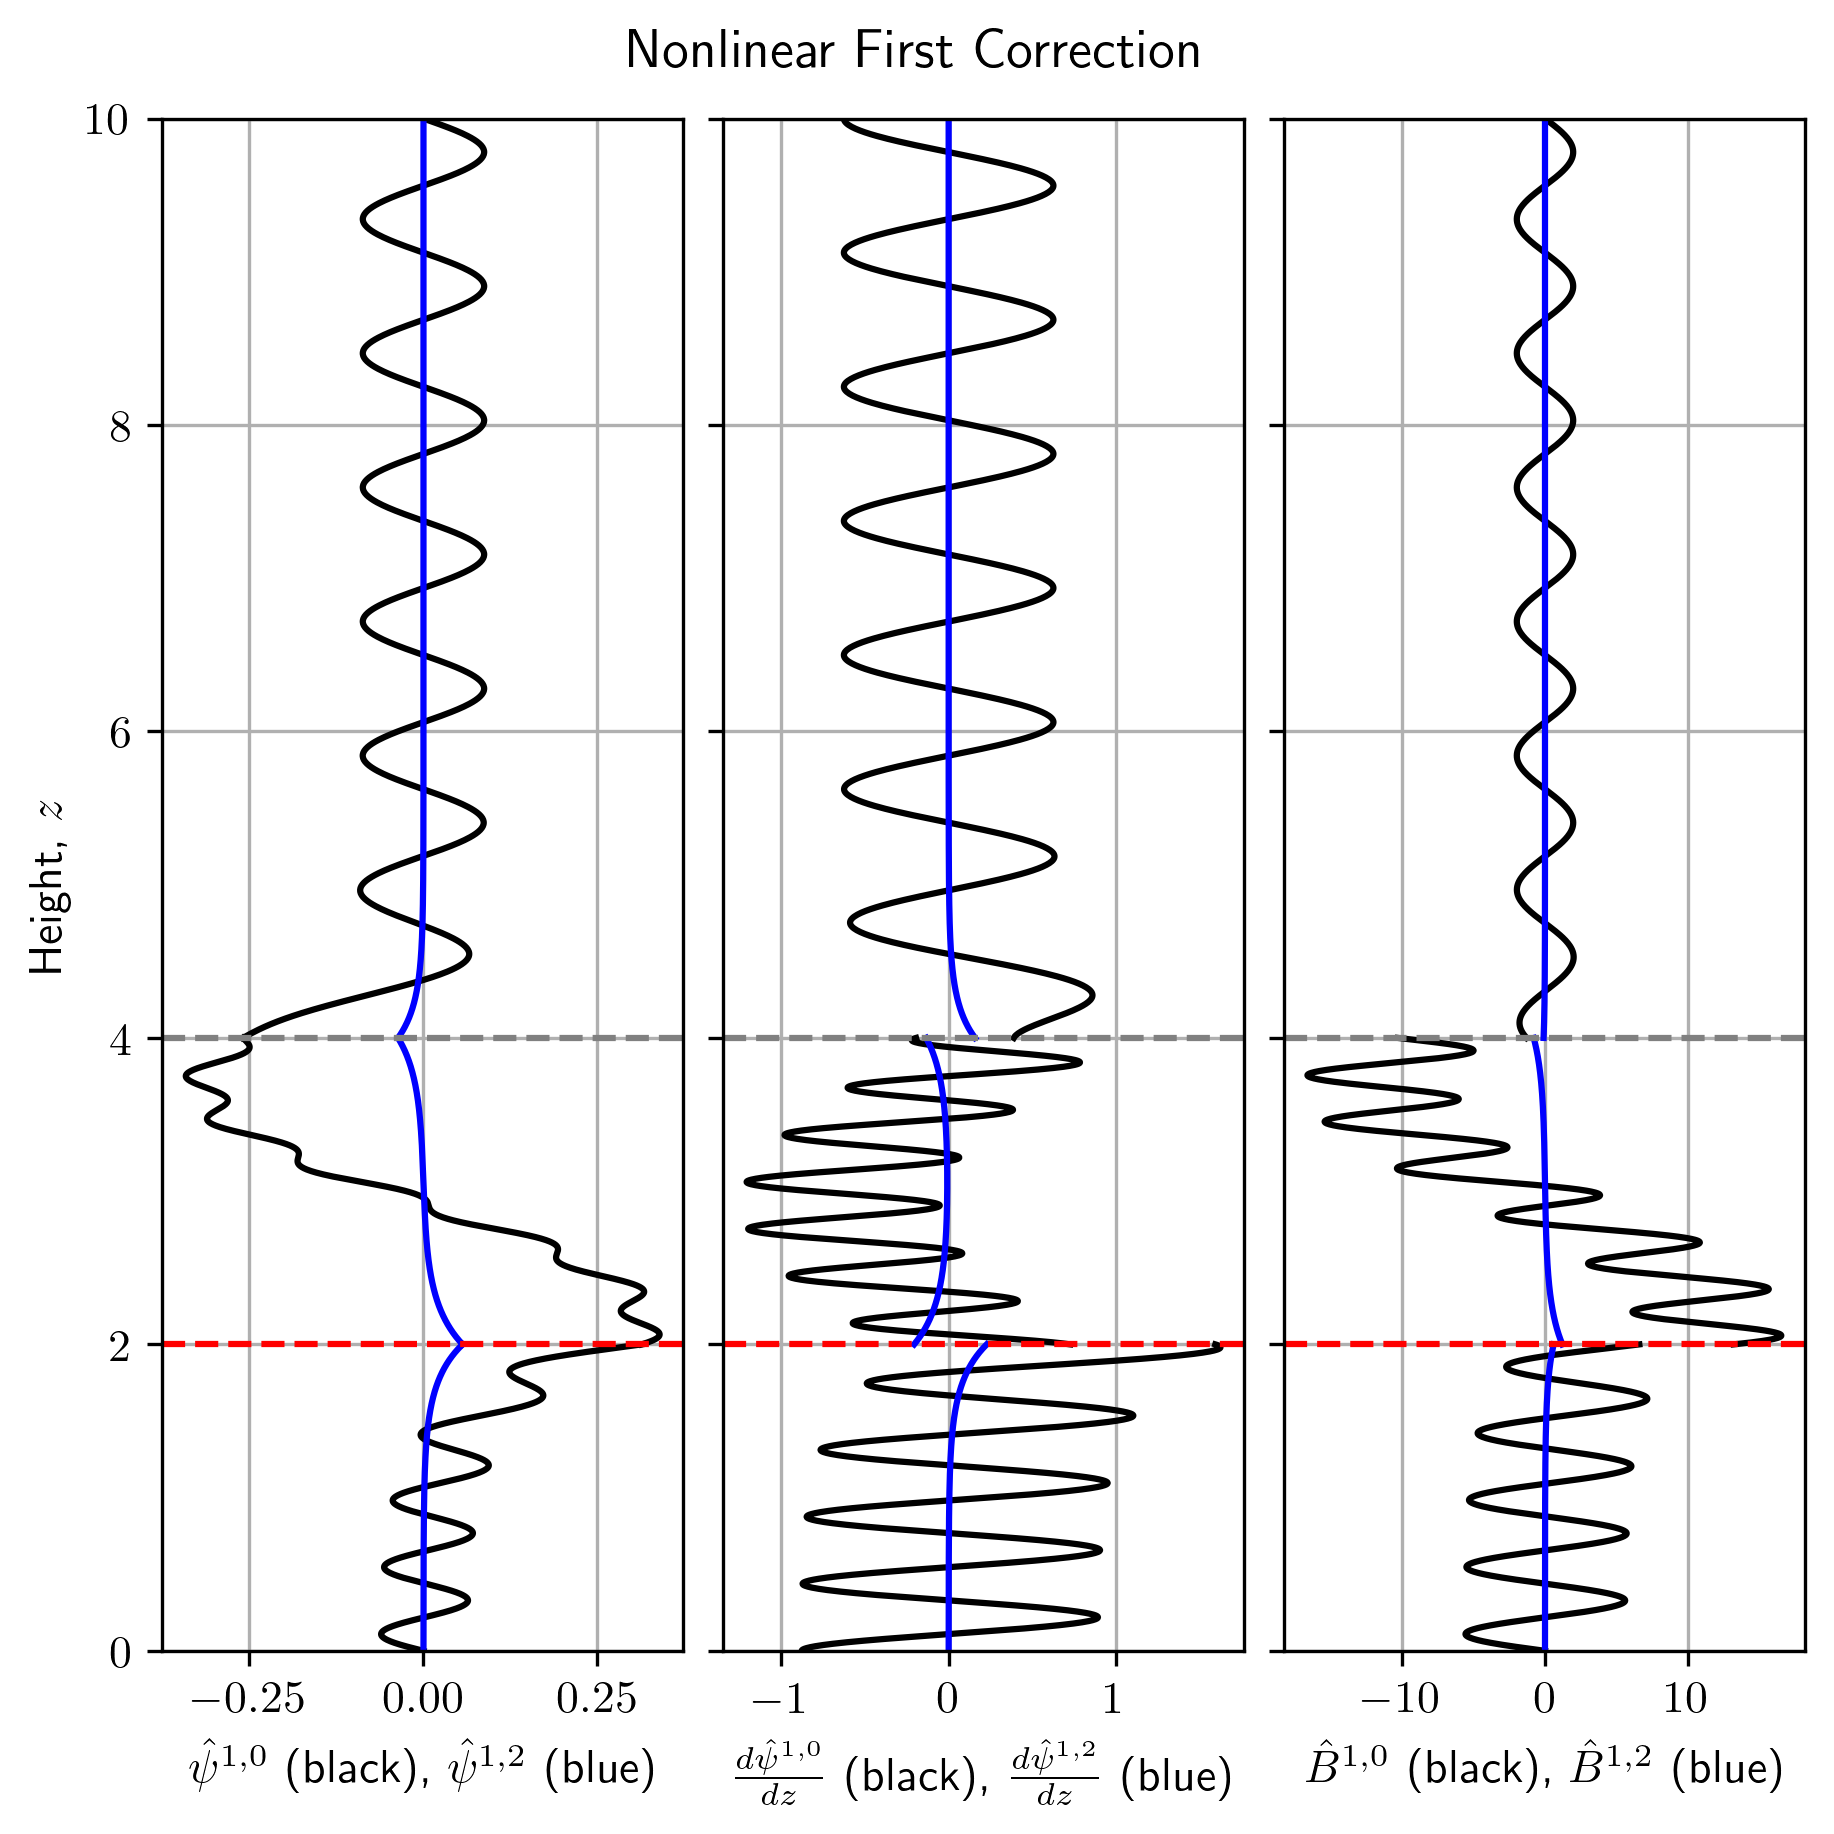

In [15]:
#Plot Nonlinear First Correction
fig, axes = plt.subplots(ncols=3, sharey=True, layout='constrained')
fig.set_dpi(300)
fig.set_size_inches(6,6)
fig.suptitle('Nonlinear First Correction')

zt = np.linspace(Hi, HT, num=1000)
zi = np.linspace(Hc, Hi, num=1000)
zc = np.linspace(0., Hc, num=1000)

axes[0].plot(sym_to_eval(psih_10_t, zt), zt, 'k')
axes[0].plot(sym_to_eval(psih_10_i, zi), zi, 'k')
axes[0].plot(sym_to_eval(psih_10_c, zc), zc, 'k')
axes[0].plot(sym_to_eval(psih_12_t, zt), zt, 'b')
axes[0].plot(sym_to_eval(psih_12_i, zi), zi, 'b')
axes[0].plot(sym_to_eval(psih_12_c, zc), zc, 'b')
axes[0].grid()
axes[0].set(xlabel=r'$\hat{\psi}^{1,0}$ (black), $\hat{\psi}^{1,2}$ (blue)', ylabel='Height, $z$')
axes[0].set(ylim=(0.,HT))
axes[0].axhline(Hc,color='red',linestyle='--')
axes[0].axhline(Hi,color='grey',linestyle='--')

axes[1].plot(sym_to_eval(sym.diff(psih_10_t,z), zt), zt, 'k')
axes[1].plot(sym_to_eval(sym.diff(psih_10_i,z), zi), zi, 'k')
axes[1].plot(sym_to_eval(sym.diff(psih_10_c,z), zc), zc, 'k')
axes[1].plot(sym_to_eval(sym.diff(psih_12_t,z), zt), zt, 'b')
axes[1].plot(sym_to_eval(sym.diff(psih_12_i,z), zi), zi, 'b')
axes[1].plot(sym_to_eval(sym.diff(psih_12_c,z), zc), zc, 'b')
axes[1].grid()
axes[1].set(xlabel=r'$\frac{d\hat{\psi}^{1,0}}{dz}$ (black), $\frac{d\hat{\psi}^{1,2}}{dz}$ (blue)')
axes[1].axhline(Hc,color='red',linestyle='--')
axes[1].axhline(Hi,color='grey',linestyle='--')

axes[2].plot(sym_to_eval(Bh_10_t, zt), zt, 'k')
axes[2].plot(sym_to_eval(Bh_10_i, zi), zi, 'k')
axes[2].plot(sym_to_eval(Bh_10_c, zc), zc, 'k')
axes[2].plot(sym_to_eval(Bh_12_t, zt), zt, 'b')
axes[2].plot(sym_to_eval(Bh_12_i, zi), zi, 'b')
axes[2].plot(sym_to_eval(Bh_12_c, zc), zc, 'b')
axes[2].grid()
axes[2].set(xlabel=r'$\hat{B}^{1,0}$ (black), $\hat{B}^{1,2}$ (blue)')
axes[2].axhline(Hc,color='red',linestyle='--')
axes[2].axhline(Hi,color='grey',linestyle='--')

plt.show()

In [16]:
#Nonlinear terms (2,1)

#Correct jump in this mode at each Hi and Hc
J_psi21_Hi = 3/2*k**4/om**4*(N2t - N2i)*(psih_0_i.subs({z:Hi}))**3 + k/om*(psih_0_i.subs({z:Hi}))*(J_dpsi10_Hi + J_dpsi12_Hi)
J_psi21_Hc = 3/2*(1+L)**2*k**4/om**4*(N2i - N2c)*(psih_0_i.subs({z:Hc}))**3 + (1+L)*k/om*(psih_0_i.subs({z:Hc}))*(J_dpsi10_Hc + J_dpsi12_Hc)

#Particular solutions to each forcing

#6 for the 0-0 interaction
psi21_p0aa_t = mt**2*sym.sin(mi*Hi)**3/sym.sinh(mt*(Hi-HT))**3*(sym.sinh(3*mt*(z-HT))/(8*mt**2) - z*sym.cosh(mt*(z-HT))/(2*mt))
psi21_p0aa_i = mi**2*(-sym.sin(3*mi*z)/(8*mi**2) + z*sym.cos(mi*z)/(2*mi))
psi21_p0aa_c = mc**2*sym.sin(mi*Hc)**3/sym.sinh(mc*Hc)**3*(sym.sinh(3*mc*z)/(8*mc**2) - z*sym.cosh(mc*z)/(2*mc))

psi21_p0ba_t = mt**2*sym.sin(mi*Hi)**2*sym.cos(mi*Hi)/sym.sinh(mt*(Hi-HT))**3*(sym.sinh(3*mt*(z-HT))/(8*mt**2) - z*sym.cosh(mt*(z-HT))/(2*mt))
psi21_p0ba_i = mi**2*(-sym.cos(3*mi*z)/(8*mi**2) + z*sym.sin(mi*z)/(2*mi))
psi21_p0ba_c = mc**2*sym.sin(mi*Hc)**2*sym.cos(mi*Hc)/sym.sinh(mc*Hc)**3*(sym.sinh(3*mc*z)/(8*mc**2) - z*sym.cosh(mc*z)/(2*mc))

psi21_p0ab_t = mt**2*sym.cos(mi*Hi)**2*sym.sin(mi*Hi)/sym.sinh(mt*(Hi-HT))**3*(sym.sinh(3*mt*(z-HT))/(8*mt**2) - z*sym.cosh(mt*(z-HT))/(2*mt))
psi21_p0ab_i = -mi**2*(-sym.sin(3*mi*z)/(8*mi**2) + z*sym.cos(mi*z)/(2*mi))
psi21_p0ab_c = mc**2*sym.cos(mi*Hc)**2*sym.sin(mi*Hc)/sym.sinh(mc*Hc)**3*(sym.sinh(3*mc*z)/(8*mc**2) - z*sym.cosh(mc*z)/(2*mc))

psi21_p0bb_t = mt**2*sym.cos(mi*Hi)**3/sym.sinh(mt*(Hi-HT))**3*(sym.sinh(3*mt*(z-HT))/(8*mt**2) - z*sym.cosh(mt*(z-HT))/(2*mt))
psi21_p0bb_i = -mi**2*(-sym.cos(3*mi*z)/(8*mi**2) + z*sym.sin(mi*z)/(2*mi))
psi21_p0bb_c = mc**2*sym.cos(mi*Hc)**3/sym.sinh(mc*Hc)**3*(sym.sinh(3*mc*z)/(8*mc**2) - z*sym.cosh(mc*z)/(2*mc))

psi21_p0aab_t = mt**2*sym.sin(mi*Hi)**2*sym.cos(mi*Hi)/sym.sinh(mt*(Hi-HT))**3*(sym.sinh(3*mt*(z-HT))/(8*mt**2) - z*sym.cosh(mt*(z-HT))/(2*mt))
psi21_p0aab_i = mi**2*(-sym.cos(3*mi*z)/(8*mi**2) - z*sym.sin(mi*z)/(2*mi))
psi21_p0aab_c = mc**2*sym.sin(mi*Hc)**2*sym.cos(mi*Hc)/sym.sinh(mc*Hc)**3*(sym.sinh(3*mc*z)/(8*mc**2) - z*sym.cosh(mc*z)/(2*mc))

psi21_p0bab_t = mt**2*sym.cos(mi*Hi)**2*sym.sin(mi*Hi)/sym.sinh(mt*(Hi-HT))**3*(sym.sinh(3*mt*(z-HT))/(8*mt**2) - z*sym.cosh(mt*(z-HT))/(2*mt))
psi21_p0bab_i = mi**2*(sym.sin(3*mi*z)/(8*mi**2) + z*sym.cos(mi*z)/(2*mi))
psi21_p0bab_c = mc**2*sym.cos(mi*Hc)**2*sym.sin(mi*Hc)/sym.sinh(mc*Hc)**3*(sym.sinh(3*mc*z)/(8*mc**2) - z*sym.cosh(mc*z)/(2*mc))

#12 for the 0-1 interaction
psi21_p1aa_t = m0t/2*sym.sin(m0i*Hi)/sym.sin(m0t*(Hi-HT))*sym.sin(mi*Hi)/sym.sinh(mt*(Hi-HT))*(sym.sinh((mt+I*m0t)*(z-HT))/((mt+I*m0t)**2 - mt**2) + sym.sinh((mt-I*m0t)*(z-HT))/((mt-I*m0t)**2 - mt**2))
psi21_p1aa_i = -m0i/2*(sym.sin((mi+m0i)*z)/((mi+m0i)**2 - mi**2) + sym.sin((mi-m0i)*z)/((mi-m0i)**2 - mi**2))
psi21_p1aa_c = m0c/2*sym.sin(m0i*Hc)/sym.sin(m0c*Hc)*sym.sin(mi*Hc)/sym.sinh(mc*Hc)*(sym.sinh((mc+I*m0c)*z)/((mc+I*m0c)**2 - mc**2) + sym.sinh((mc-I*m0c)*z)/((mc-I*m0c)**2 - mc**2))

psi21_p1ba_t = m0t/2*sym.sin(m0i*Hi)/sym.sin(m0t*(Hi-HT))*sym.cos(mi*Hi)/sym.sinh(mt*(Hi-HT))*(sym.sinh((mt+I*m0t)*(z-HT))/((mt+I*m0t)**2 - mt**2) + sym.sinh((mt-I*m0t)*(z-HT))/((mt-I*m0t)**2 - mt**2))
psi21_p1ba_i = -m0i/2*(sym.cos((mi+m0i)*z)/((mi+m0i)**2 - mi**2) + sym.cos((mi-m0i)*z)/((mi-m0i)**2 - mi**2))
psi21_p1ba_c = m0c/2*sym.sin(m0i*Hc)/sym.sin(m0c*Hc)*sym.cos(mi*Hc)/sym.sinh(mc*Hc)*(sym.sinh((mc+I*m0c)*z)/((mc+I*m0c)**2 - mc**2) + sym.sinh((mc-I*m0c)*z)/((mc-I*m0c)**2 - mc**2))

psi21_p1ab_t = m0t/2*sym.cos(m0i*Hi)/sym.sin(m0t*(Hi-HT))*sym.sin(mi*Hi)/sym.sinh(mt*(Hi-HT))*(sym.sinh((mt+I*m0t)*(z-HT))/((mt+I*m0t)**2 - mt**2) + sym.sinh((mt-I*m0t)*(z-HT))/((mt-I*m0t)**2 - mt**2))
psi21_p1ab_i = -m0i/2*(sym.cos((mi+m0i)*z)/((mi+m0i)**2 - mi**2) - sym.cos((mi-m0i)*z)/((mi-m0i)**2 - mi**2))
psi21_p1ab_c = m0c/2*sym.cos(m0i*Hc)/sym.sin(m0c*Hc)*sym.sin(mi*Hc)/sym.sinh(mc*Hc)*(sym.sinh((mc+I*m0c)*z)/((mc+I*m0c)**2 - mc**2) + sym.sinh((mc-I*m0c)*z)/((mc-I*m0c)**2 - mc**2))

psi21_p1bb_t = m0t/2*sym.cos(m0i*Hi)/sym.sin(m0t*(Hi-HT))*sym.cos(mi*Hi)/sym.sinh(mt*(Hi-HT))*(sym.sinh((mt+I*m0t)*(z-HT))/((mt+I*m0t)**2 - mt**2) + sym.sinh((mt-I*m0t)*(z-HT))/((mt-I*m0t)**2 - mt**2))
psi21_p1bb_i = m0i/2*(sym.sin((mi+m0i)*z)/((mi+m0i)**2 - mi**2) - sym.sin((mi-m0i)*z)/((mi-m0i)**2 - mi**2))
psi21_p1bb_c = m0c/2*sym.cos(m0i*Hc)/sym.sin(m0c*Hc)*sym.cos(mi*Hc)/sym.sinh(mc*Hc)*(sym.sinh((mc+I*m0c)*z)/((mc+I*m0c)**2 - mc**2) + sym.sinh((mc-I*m0c)*z)/((mc-I*m0c)**2 - mc**2))

psi21_p1ac_t = m0t/2*(-J_psi10_pd_Hi + sym.sin(m0i*Hi))/sym.sin(m0t*(Hi-HT))*sym.sin(mi*Hi)/sym.sinh(mt*(Hi-HT))*(sym.sinh((mt+I*m0t)*(z-HT))/((mt+I*m0t)**2 - mt**2) + sym.sinh((mt-I*m0t)*(z-HT))/((mt-I*m0t)**2 - mt**2))
psi21_p1ac_i = -m0i/2*(sym.sin((mi+m0i)*z)/((mi+m0i)**2 - mi**2) + sym.sin((mi-m0i)*z)/((mi-m0i)**2 - mi**2))
psi21_p1ac_c = m0c/2*(J_psi10_pd_Hc + sym.sin(m0i*Hc))/sym.sin(m0c*Hc)*sym.sin(mi*Hc)/sym.sinh(mc*Hc)*(sym.sinh((mc+I*m0c)*z)/((mc+I*m0c)**2 - mc**2) + sym.sinh((mc-I*m0c)*z)/((mc-I*m0c)**2 - mc**2))

psi21_p1bc_t = m0t/2*(-J_psi10_pd_Hi + sym.sin(m0i*Hi))/sym.sin(m0t*(Hi-HT))*sym.cos(mi*Hi)/sym.sinh(mt*(Hi-HT))*(sym.sinh((mt+I*m0t)*(z-HT))/((mt+I*m0t)**2 - mt**2) + sym.sinh((mt-I*m0t)*(z-HT))/((mt-I*m0t)**2 - mt**2))
psi21_p1bc_i = -m0i/2*(sym.cos((mi+m0i)*z)/((mi+m0i)**2 - mi**2) + sym.cos((mi-m0i)*z)/((mi-m0i)**2 - mi**2))
psi21_p1bc_c = m0c/2*(J_psi10_pd_Hc + sym.sin(m0i*Hc))/sym.sin(m0c*Hc)*sym.cos(mi*Hc)/sym.sinh(mc*Hc)*(sym.sinh((mc+I*m0c)*z)/((mc+I*m0c)**2 - mc**2) + sym.sinh((mc-I*m0c)*z)/((mc-I*m0c)**2 - mc**2))

psi21_p1apa_t = mt**2/(m0t**2 + 4*mt**2)*sym.sin(mi*Hi)**3/sym.sinh(mt*(Hi-HT))**3*(sym.sinh(3*mt*(z-HT))/(8*mt**2) - z*sym.cosh(mt*(z-HT))/(2*mt))
psi21_p1apa_i = mi**2/(m0i**2 - 4*mi**2)*(-sym.sin(3*mi*z)/(8*mi**2) + z*sym.cos(mi*z)/(2*mi))
psi21_p1apa_c = mc**2/(m0c**2 + 4*mc**2)*sym.sin(mi*Hc)**3/sym.sinh(mc*Hc)**3*(sym.sinh(3*mc*z)/(8*mc**2) - z*sym.cosh(mc*z)/(2*mc))

psi21_p1bpa_t = mt**2/(m0t**2 + 4*mt**2)*sym.sin(mi*Hi)**2*sym.cos(mi*Hi)/sym.sinh(mt*(Hi-HT))**3*(sym.sinh(3*mt*(z-HT))/(8*mt**2) - z*sym.cosh(mt*(z-HT))/(2*mt))
psi21_p1bpa_i = mi**2/(m0i**2 - 4*mi**2)*(-sym.cos(3*mi*z)/(8*mi**2) + z*sym.sin(mi*z)/(2*mi))
psi21_p1bpa_c = mc**2/(m0c**2 + 4*mc**2)*sym.sin(mi*Hc)**2*sym.cos(mi*Hc)/sym.sinh(mc*Hc)**3*(sym.sinh(3*mc*z)/(8*mc**2) - z*sym.cosh(mc*z)/(2*mc))

psi21_p1apb_t = mt**2/(m0t**2 + 4*mt**2)*sym.sin(mi*Hi)*sym.cos(mi*Hi)**2/sym.sinh(mt*(Hi-HT))**3*(sym.sinh(3*mt*(z-HT))/(8*mt**2) - z*sym.cosh(mt*(z-HT))/(2*mt))
psi21_p1apb_i = mi**2/(m0i**2 - 4*mi**2)*(sym.sin(3*mi*z)/(8*mi**2) - z*sym.cos(mi*z)/(2*mi))
psi21_p1apb_c = mc**2/(m0c**2 + 4*mc**2)*sym.sin(mi*Hc)*sym.cos(mi*Hc)**2/sym.sinh(mc*Hc)**3*(sym.sinh(3*mc*z)/(8*mc**2) - z*sym.cosh(mc*z)/(2*mc))

psi21_p1bpb_t = mt**2/(m0t**2 + 4*mt**2)*sym.cos(mi*Hi)**3/sym.sinh(mt*(Hi-HT))**3*(sym.sinh(3*mt*(z-HT))/(8*mt**2) - z*sym.cosh(mt*(z-HT))/(2*mt))
psi21_p1bpb_i = mi**2/(m0i**2 - 4*mi**2)*(sym.cos(3*mi*z)/(8*mi**2) - z*sym.sin(mi*z)/(2*mi))
psi21_p1bpb_c = mc**2/(m0c**2 + 4*mc**2)*sym.cos(mi*Hc)**3/sym.sinh(mc*Hc)**3*(sym.sinh(3*mc*z)/(8*mc**2) - z*sym.cosh(mc*z)/(2*mc))

psi21_p1apab_t = mt**2/2/(m0t**2 + 4*mt**2)*sym.sin(2*mi*Hi)*sym.sin(mi*Hi)/sym.sinh(mt*(Hi-HT))**3*(sym.sinh(3*mt*(z-HT))/(8*mt**2) - z*sym.cosh(mt*(z-HT))/(2*mt))
psi21_p1apab_i = mi**2/(m0i**2 - 4*mi**2)*(-sym.cos(3*mi*z)/(8*mi**2) - z*sym.sin(mi*z)/(2*mi))
psi21_p1apab_c = mc**2/2/(m0c**2 + 4*mc**2)*sym.sin(2*mi*Hc)*sym.sin(mi*Hc)/sym.sinh(mc*Hc)**3*(sym.sinh(3*mc*z)/(8*mc**2) - z*sym.cosh(mc*z)/(2*mc))

psi21_p1bpab_t = mt**2/2/(m0t**2 + 4*mt**2)*sym.sin(2*mi*Hi)*sym.cos(mi*Hi)/sym.sinh(mt*(Hi-HT))**3*(sym.sinh(3*mt*(z-HT))/(8*mt**2) - z*sym.cosh(mt*(z-HT))/(2*mt))
psi21_p1bpab_i = mi**2/(m0i**2 - 4*mi**2)*(sym.sin(3*mi*z)/(8*mi**2) + z*sym.cos(mi*z)/(2*mi))
psi21_p1bpab_c = mc**2/2/(m0c**2 + 4*mc**2)*sym.sin(2*mi*Hc)*sym.cos(mi*Hc)/sym.sinh(mc*Hc)**3*(sym.sinh(3*mc*z)/(8*mc**2) - z*sym.cosh(mc*z)/(2*mc))

#Full Paticular solution without correct continuity
psi21_pd_t = N2t*(2*k**3/om**3 - k/om/om_p**2 - k**2/om**2/om_p)*(\
             (m0t**2*k/om*(1 + 2*k/om*om_p)*(1-k/om*om_p)*(v1[0]**3*psi21_p1apa_t + v1[0]**2*v1[1]*psi21_p1bpa_t + 2*v1[0]**2*v1[1]*psi21_p1apab_t + \
                                                           2*v1[0]*v1[1]**2*psi21_p1bpab_t + v1[0]*v1[1]**2*psi21_p1apb_t + v1[1]**3*psi21_p1bpb_t)) \
             + v1[0]*psi21_p1ac_t + v1[1]*psi21_p1bc_t + v1[0]*W10[0,0]*psi21_p1aa_t + v1[1]*W10[0,0]*psi21_p1ba_t + v1[0]*W10[1,0]*psi21_p1ab_t + v1[1]*W10[1,0]*psi21_p1bb_t) + \
             N2t*(k**2/om**2/om_p**2*(1+2*k/om*om_p)*(1-k/om*om_p) + k**3/om**3/om_p*(1-k/om*om_p))* \
             (v1[0]**3*psi21_p0aa_t + v1[0]**2*v1[1]*psi21_p0ba_t + 2*v1[0]**2*v1[1]*psi21_p0aab_t + 2*v1[0]*v1[1]**2*psi21_p0bab_t \
              + v1[0]*v1[1]**2*psi21_p0ab_t + v1[1]**3*psi21_p0bb_t)
psi21_pd_i = N2i*(2*k**3/om**3 - k/om/om_p**2 - k**2/om**2/om_p)*(\
             (m0i**2*k/om*(1 + 2*k/om*om_p)*(1-k/om*om_p)*(v1[0]**3*psi21_p1apa_i + v1[0]**2*v1[1]*psi21_p1bpa_i + 2*v1[0]**2*v1[1]*psi21_p1apab_i + \
                                                           2*v1[0]*v1[1]**2*psi21_p1bpab_i + v1[0]*v1[1]**2*psi21_p1apb_i + v1[1]**3*psi21_p1bpb_i)) \
             + v1[0]*psi21_p1ac_i + v1[1]*psi21_p1bc_i + v1[0]*W10[0,0]*psi21_p1aa_i + v1[1]*W10[0,0]*psi21_p1ba_i + v1[0]*W10[1,0]*psi21_p1ab_i + v1[1]*W10[1,0]*psi21_p1bb_i) + \
             N2i*(k**2/om**2/om_p**2*(1+2*k/om*om_p)*(1-k/om*om_p) + k**3/om**3/om_p*(1-k/om*om_p))* \
             (v1[0]**3*psi21_p0aa_i + v1[0]**2*v1[1]*psi21_p0ba_i + 2*v1[0]**2*v1[1]*psi21_p0aab_i + 2*v1[0]*v1[1]**2*psi21_p0bab_i \
              + v1[0]*v1[1]**2*psi21_p0ab_i + v1[1]**3*psi21_p0bb_i)
psi21_pd_c = N2c*(2*k**3/om**3 - k/om/om_p**2 - k**2/om**2/om_p)*(\
             (m0c**2*k/om*(1 + 2*k/om*om_p)*(1-k/om*om_p)*(v1[0]**3*psi21_p1apa_c + v1[0]**2*v1[1]*psi21_p1bpa_c + 2*v1[0]**2*v1[1]*psi21_p1apab_c + \
                                                           2*v1[0]*v1[1]**2*psi21_p1bpab_c + v1[0]*v1[1]**2*psi21_p1apb_c + v1[1]**3*psi21_p1bpb_c)) \
             + v1[0]*psi21_p1ac_c + v1[1]*psi21_p1bc_c + v1[0]*W10[0,0]*psi21_p1aa_c + v1[1]*W10[0,0]*psi21_p1ba_c + v1[0]*W10[1,0]*psi21_p1ab_c + v1[1]*W10[1,0]*psi21_p1bb_c) + \
             N2c*(k**2/om**2/om_p**2*(1+2*k/om*om_p)*(1-k/om*om_p) + k**3/om**3/om_p*(1-k/om*om_p))* \
             (v1[0]**3*psi21_p0aa_c + v1[0]**2*v1[1]*psi21_p0ba_c + 2*v1[0]**2*v1[1]*psi21_p0aab_c + 2*v1[0]*v1[1]**2*psi21_p0bab_c \
              + v1[0]*v1[1]**2*psi21_p0ab_c + v1[1]**3*psi21_p0bb_c)

#Correct jumps at Hi and Hc
J_psi21_pd_Hi = psi21_pd_t.subs({z:Hi}) - psi21_pd_i.subs({z:Hi})
J_psi21_pd_Hc = psi21_pd_i.subs({z:Hc}) - psi21_pd_c.subs({z:Hc})

psi21_p_t = psi21_pd_t + (J_psi21_Hi - J_psi21_pd_Hi + sym.sin(mi*Hi))*sym.sinh(mt*(z-HT))/sym.sinh(mt*(Hi-HT))
psi21_p_i = psi21_pd_i + sym.sin(mi*z)
psi21_p_c = psi21_pd_c + (-J_psi21_Hc + J_psi21_pd_Hc + sym.sin(mi*Hc))*sym.sinh(mc*z)/sym.sinh(mc*Hc)

#Continuous pressure at Hi
J_dpsi21_Hi = sym.diff(psi21_p_t, z).subs({z:Hi}) - sym.diff(psi21_p_i, z).subs({z:Hi})

alpha_21 = ( (N2t - N2i)*(5/2*k**4/om**4*psih_0_i**2*sym.diff(psih_0_i, z) - 2*k**3/om**3*psih_0_i*psih_12_i + k**2/om**2*Zih_10*psih_0_i + \
                          k/om/om_p**2*psih_0_i*(k/om*(1+2*k/om*om_p)*(1-k/om*om_p)*sym.diff(psih_0_i**2, z) - psih_10_i)).subs({z:Hi})\
            - J_dpsi21_Hi )/J_dphi

psih_21_t = psi21_p_t + alpha_21*phi_t
psih_21_i = psi21_p_i + alpha_21*phi_i
psih_21_c = psi21_p_c + alpha_21*phi_c

J_dpsi21_Hc = sym.diff(psih_21_i, z).subs({z:Hc}) - sym.diff(psih_21_c, z).subs({z:Hc})

Bh_21_t = N2t*k/om*psih_21_t - N2t*k**2/om**2*psih_0_t*sym.diff(psih_10_t, z) + k/om*psih_0_t*sym.diff(Bh_10_t, z)
Bh_21_i = N2i*k/om*psih_21_i - N2i*k**2/om**2*psih_0_i*sym.diff(psih_10_i, z) + k/om*psih_0_i*sym.diff(Bh_10_i, z)
Bh_21_c = N2c*k/om*psih_21_c - N2c*k**2/om**2*psih_0_c*sym.diff(psih_10_c, z) + k/om*psih_0_c*sym.diff(Bh_10_c, z)

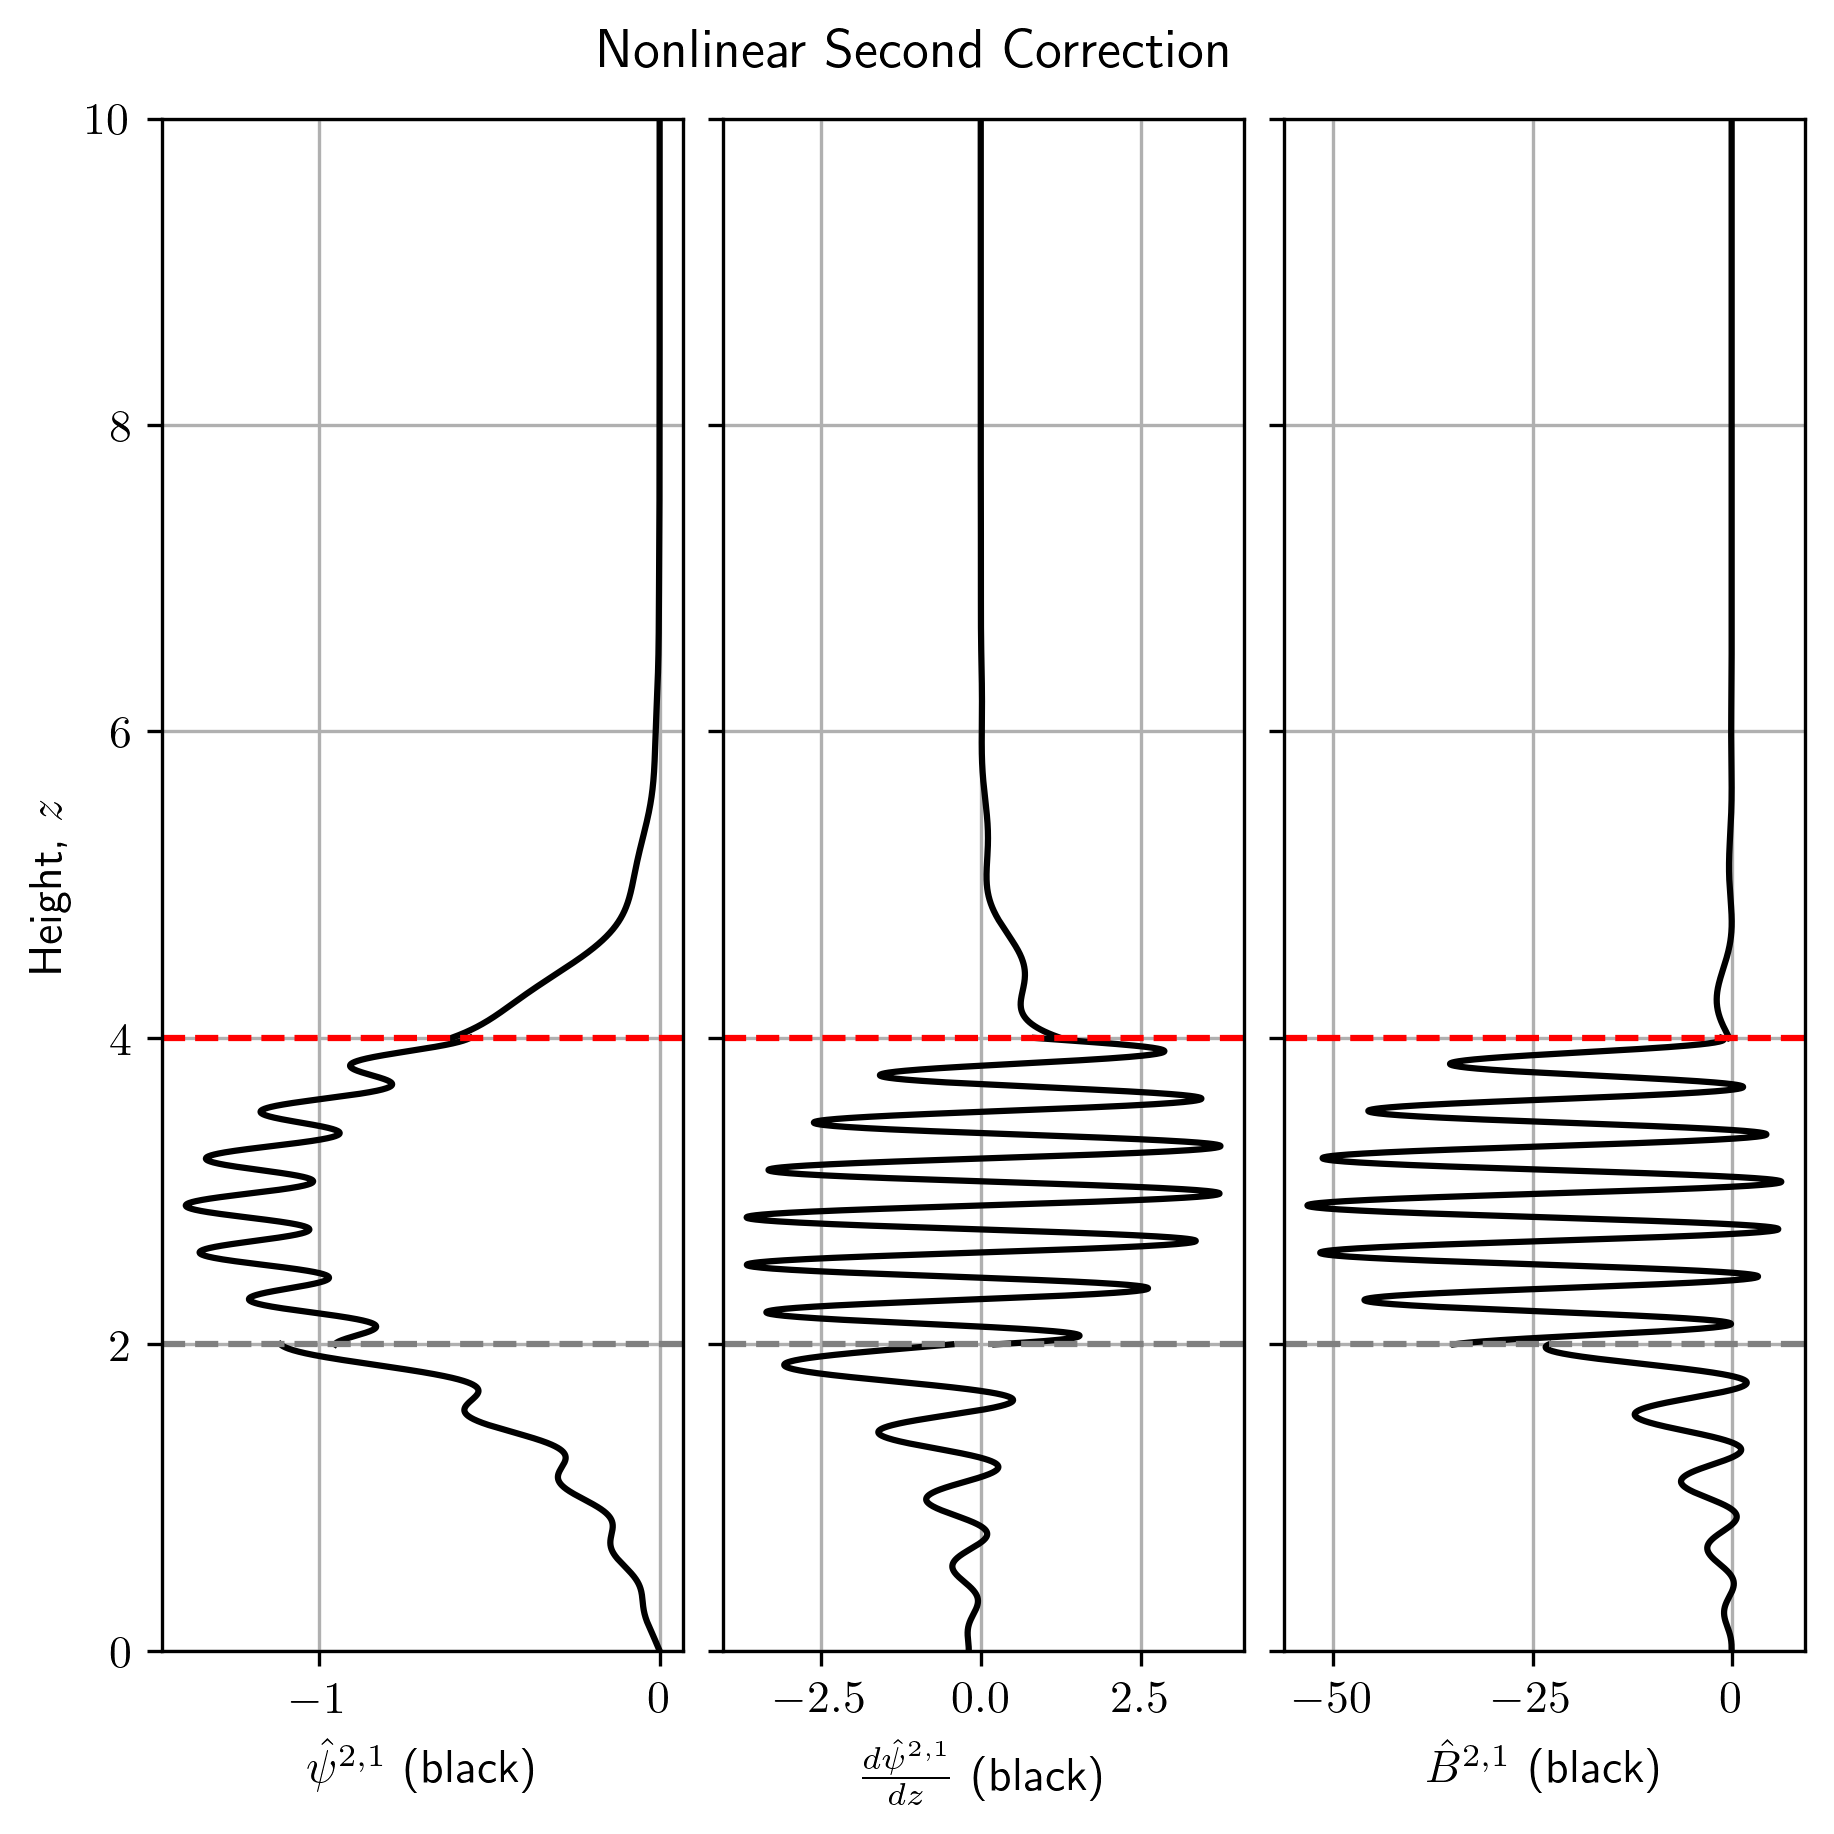

In [17]:
#Plot Nonlinear Second Correction (first harmonic only)
fig, axes = plt.subplots(ncols=3, sharey=True, layout='constrained')
fig.set_dpi(300)
fig.set_size_inches(6,6)
fig.suptitle('Nonlinear Second Correction')

zt = np.linspace(Hi, HT, num=1000)
zi = np.linspace(Hc, Hi, num=1000)
zc = np.linspace(0., Hc, num=1000)

axes[0].plot(sym_to_eval(psih_21_t, zt).real, zt, 'k')
axes[0].plot(sym_to_eval(psih_21_i, zi).real, zi, 'k')
axes[0].plot(sym_to_eval(psih_21_c, zc).real, zc, 'k')
axes[0].grid()
axes[0].set(xlabel=r'$\hat{\psi}^{2,1}$ (black)', ylabel='Height, $z$')
axes[0].set(ylim=(0.,HT))
axes[0].axhline(Hi,color='red',linestyle='--')
axes[0].axhline(Hc,color='grey',linestyle='--')

axes[1].plot(sym_to_eval(sym.diff(psih_21_t,z), zt).real, zt, 'k')
axes[1].plot(sym_to_eval(sym.diff(psih_21_i,z), zi).real, zi, 'k')
axes[1].plot(sym_to_eval(sym.diff(psih_21_c,z), zc).real, zc, 'k')
axes[1].grid()
axes[1].set(xlabel=r'$\frac{d\hat{\psi}^{2,1}}{dz}$ (black)')
axes[1].axhline(Hi,color='red',linestyle='--')
axes[1].axhline(Hc,color='grey',linestyle='--')

axes[2].plot(sym_to_eval(Bh_21_t, zt).real, zt, 'k')
axes[2].plot(sym_to_eval(Bh_21_i, zi).real, zi, 'k')
axes[2].plot(sym_to_eval(Bh_21_c, zc).real, zc, 'k')
axes[2].grid()
axes[2].set(xlabel=r'$\hat{B}^{2,1}$ (black)')
axes[2].axhline(Hi,color='red',linestyle='--')
axes[2].axhline(Hc,color='grey',linestyle='--')

plt.show()

In [18]:
#Compute gamma Eq (4.58)
gamma = (1j/del_T)*( (N2i-N2c)*( -(1+L)*(5/2+2*L)*k**4/om**4*psih_0_i**2*sym.diff(psih_0_i, z) \
                                + 2*(1+L)*k**3/om**3*psih_0_i*psih_12_i - k**2/om**2*Zch_10*psih_0_i \
                      - (1+L)*k/om/om_p**2*psih_0_i*(k/om*(1+2*k/om*om_p)*(1-k/om*om_p)*sym.diff(psih_0_i**2, z) - psih_10_i) ).subs({z:Hc}) \
                    + J_dpsi21_Hc)

gamma = gamma.subs({k:k_val, om:om_val}).doit()

**End of Solution Construction**

**Begginning of Convergence Tests**

/var/folders/gn/cfbkg9gx4p35qfks288gj5wr0000gn/T/ipykernel_58578/308510610.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  if j == 0: oms[j] = om_val


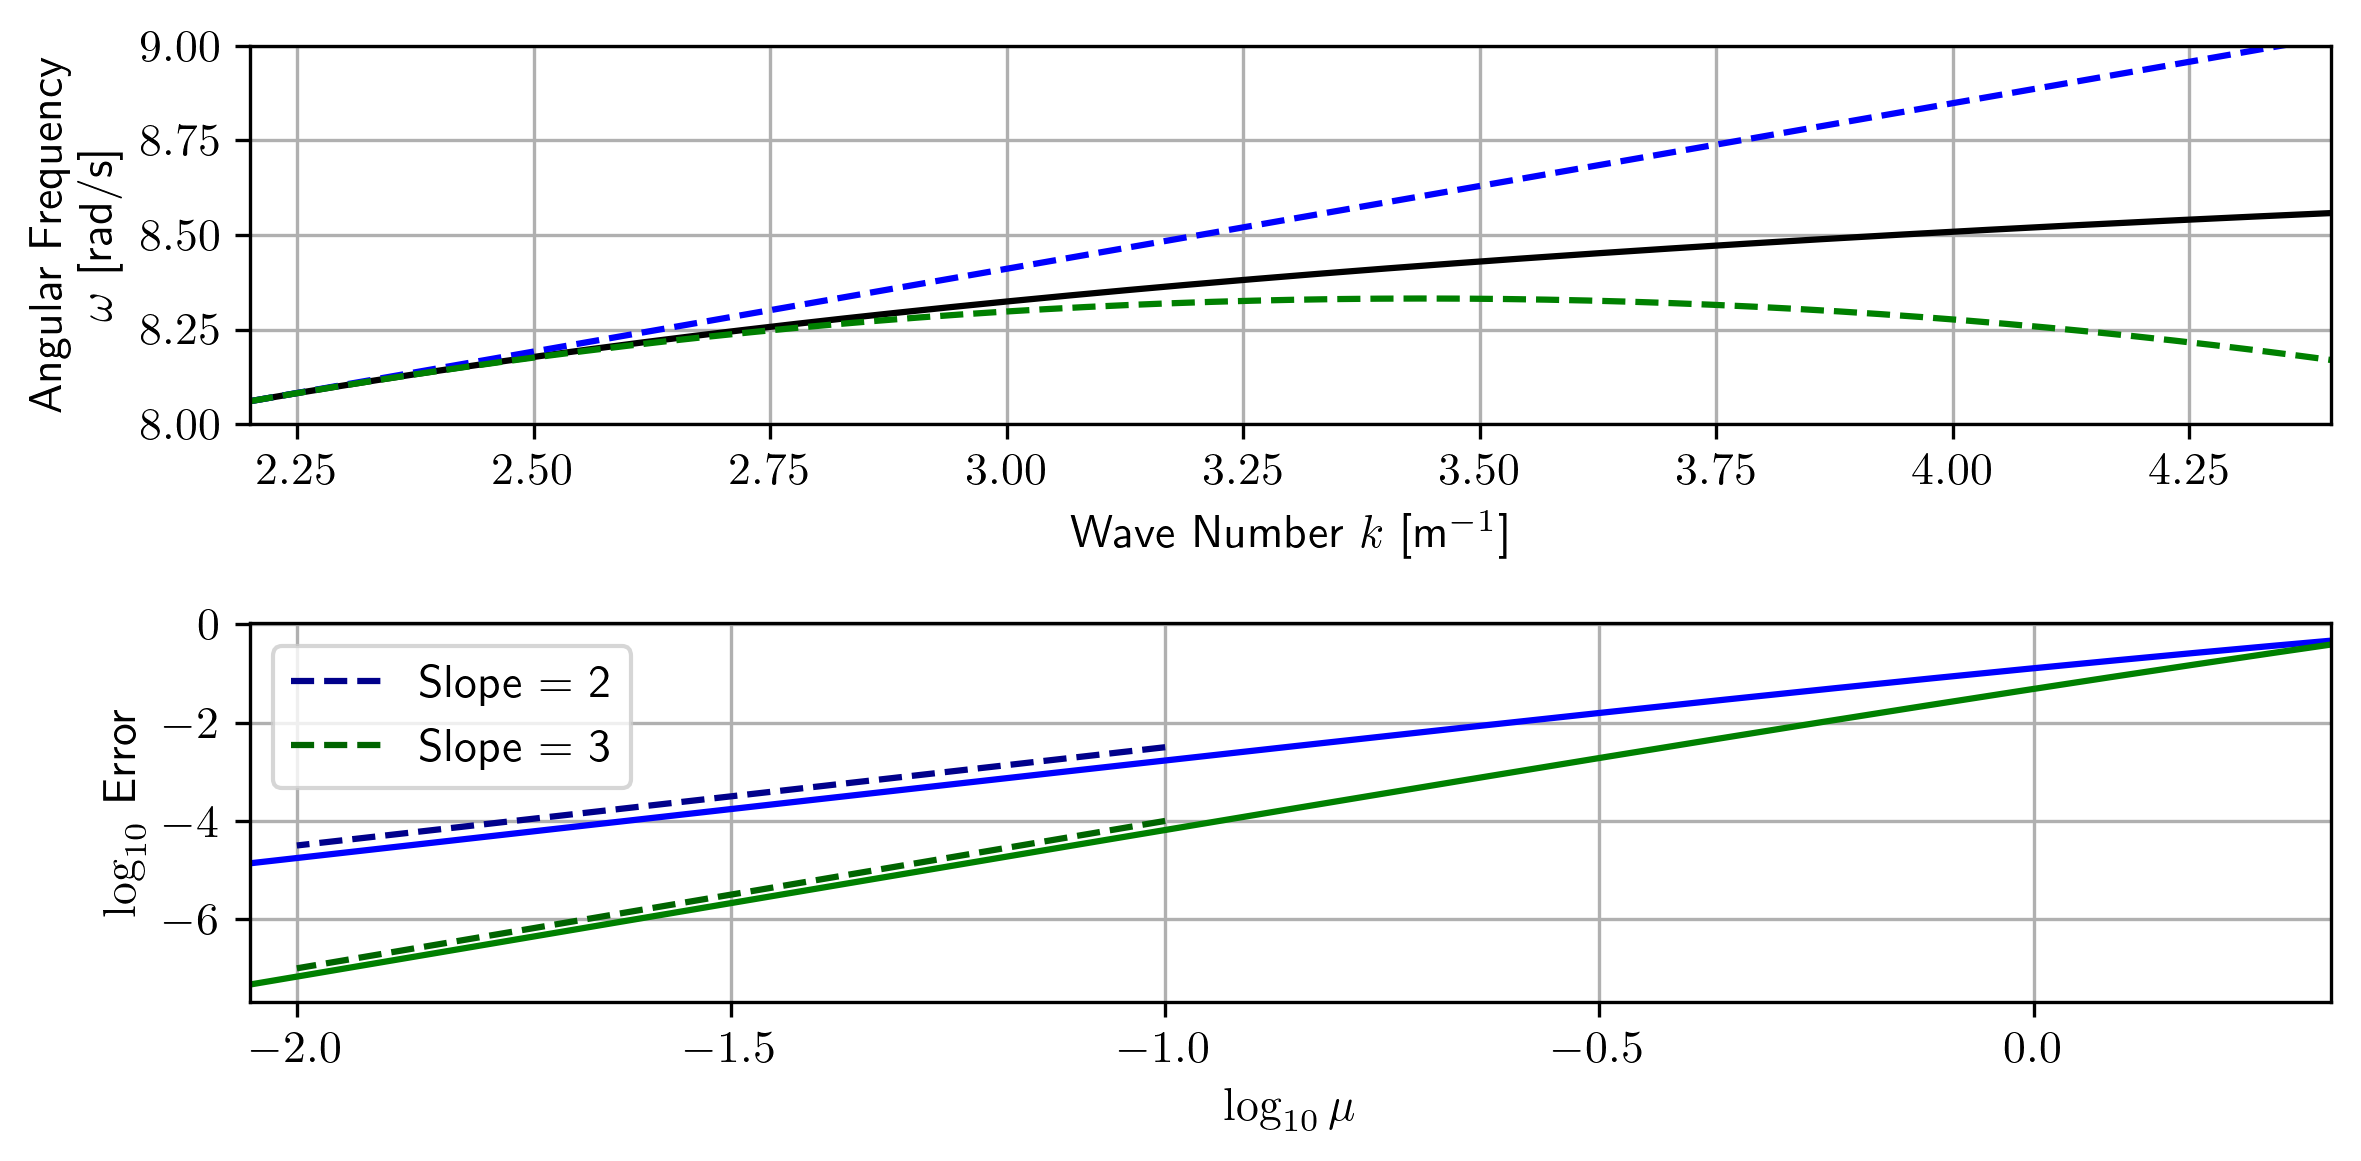

In [19]:
# Linear Dispersion check
# Verification of the group velocity and omega''
# As in Eq (4.16) and Eq (4.33)
# One simple test of the of linear corrections
# Remember sigma is mu in the thesis (this code uses old notation)
# The linear correction should have second order convergence
# Second correction should have third order convergence


# List of perturbed k values
ks     = np.linspace(k_val, 2*k_val, num=250)
# Nonlinear parameter is the distance in wavenumber space to the nominal k value
sigmas = ks - k_val
# Numerically find associated frequencies
oms    = np.empty_like(ks)
for j in range(oms.size):
    if j == 0: oms[j] = om_val
    else: oms[j] = secant_omega(oms[j-1], N2t=N2t, N2i=N2i, N2c=N2c, Hc=Hc, Hi=Hi, HT=HT, k=ks[j])

# As in Eq (4.17) and Eq (4.32)
lin_approx  = om_val+sigmas*om_p.real
quad_approx = om_val+sigmas*om_p.real+sigmas**2*om_pp.real/2

# Plotting
fig, axes = plt.subplots(nrows=2, layout='tight')
fig.set_dpi(300)
fig.set_size_inches(8,4)

axes[0].plot(ks, oms, color='k')
axes[0].plot(ks, lin_approx, '--b')
axes[0].plot(ks, quad_approx, '--g')
axes[0].grid()
axes[0].set(xlim=(ks[0], ks[-1]), ylim=(8.0, 9.0))
axes[0].set(xlabel=r'Wave Number $k$ [m$^{\mathrm{-1}}$]', ylabel='Angular Frequency\n'+r'$\omega$ [rad/s]')

axes[1].plot(np.log10(sigmas[1:]), np.log10(np.abs(oms-lin_approx)[1:]), 'b')
axes[1].plot((-1.,-2.), (-2.5, -4.5), linestyle='--', color='darkblue', label='Slope = 2')
axes[1].plot(np.log10(sigmas[1:]), np.log10(np.abs(oms-quad_approx)[1:]), 'g')
axes[1].plot((-1.,-2.), (-4., -7.), linestyle='--', color='darkgreen', label='Slope = 3')
axes[1].grid()
axes[1].set(xlim=(np.log10(sigmas[1]),np.log10(sigmas[-1])))
axes[1].set(xlabel=r'$\log_{10}\mu$', ylabel=r'$\log_{10}$ Error')
axes[1].legend()

plt.show()

**Begginning of the Nonlinear Convergence Checks**

In [20]:
# Create an exact solution amplitude function (exponential function)
del_k = 1.
del_om = om_p.real*del_k + sig*(om_pp.real/2*del_k**2 - gamma).subs({k:k_val,om:om_val,L:0.5}).simplify()

A   = sym.exp(I*sig*(del_k*x - del_om*t))

# For convience save these
Ast = sym.conjugate(A)

A_x = sym.diff(A, x)
A_t = sym.diff(A, t)

A_xx = sym.diff(A, x, x)
A_tx = sym.diff(A, t, x)
A_tt = sym.diff(A, t, t)


In [21]:
# Helpful function to evaluate on a 2D grid
#
# inputs:
#       f      - sympy expression to be evaluated
#       zz     - z coordinates of evalutation points (2D)
#       xx     - x coordinates of evalutation points (2D)
#       t_val  - time coordinate to evaluate at
#       L_val  - latent heat response
#       sigma  - nonlinear parameter (mu in my thesis)
# returns:
#       f_eval - the expression f evaluated at the given points
def sym_to_eval_2D(f, zz, xx, t_val=0., L_val=0.5, sigma=0.1):
    val_dict = {
        k:   k_val,
        om:  om_val,
        sig: sigma,
        t:   t_val,
        L: L_val
    }
    return sym.lambdify([x, z], f.subs(val_dict))(xx, zz)

# Compute a numerical approximation of the L2 norm on a 2D grid (64x64 points)
#
# inputs:
#       f      - sympy expression to be evaluated
#       zrange - tuple with the start and end zpoints
#       k_tol  - composite wave number (k_val + sig*del_k)
#       t_val  - time coordinate to evaluate at
#       sigma  - nonlinear parameter (mu in my thesis)
# returns:
#       ||f||  - L2 norm of f on the 2D grid
def L2_2D(f, zrange, k_tot, t_val=0., sigma=0.1):
    zz = np.linspace(zrange[0], zrange[1], num=64)
    dz = zz[1]-zz[0]
    xx = np.linspace(0.0, 2*np.pi/k_tot, endpoint=False, num=64)
    dx = xx[1]-xx[0]
    xx, zz = np.meshgrid(xx, zz)
    return np.sqrt(np.sum(np.abs(sym_to_eval_2D(f, zz, xx, t_val, sigma=sigma))**2))*dx*dz

In [22]:
# Symbolically compute the residual of the vorticity equation (3.5)
#
# inputs:
#       psi - sympy expression for the nonlinear streamfunction solution
#       B   - sympy expression for the nonlinear buoyancy solution
# returns:
#       res - residual of the vorticity equation using the given solution functions
def vort_res(psi, B):
    #laplacian of psi
    lap_psi = sym.diff(psi, x, x) + sym.diff(psi, z, z)
    #jacobian term in Eq (3.5)
    Jac     = sym.diff(psi, x)*sym.diff(lap_psi, z) - sym.diff(psi, z)*sym.diff(lap_psi, x)

    return -sym.diff(lap_psi, t) - sig*Jac + sym.diff(B, x)

# Symbolically compute the residual of the buoyancy equation (3.3)
#
# inputs:
#       psi - sympy expression for the nonlinear streamfunction solution
#       B   - sympy expression for the nonlinear buoyancy solution
# returns:
#       res - residual of the vorticity equation using the given solution functions
def buoy_res(psi, B, N2):
    #jacobian term in Eq (3.3)
    Jac     = sym.diff(psi, x)*sym.diff(B, z) - sym.diff(psi, z)*sym.diff(B, x)
    
    return sym.diff(B, t) + sig*Jac + N2*sym.diff(psi, x)

In [23]:
#Put Together Nonlinear Solution Eq (4.3) in Troposphere (upper region)
#Note: This cell is not fast around ~minutes

psi_t = (A*psih_0_t + A_x*psih_X_t + A_t*psih_T_t)*sym.exp(I*(k*x - om*t)) \
     +sym.conjugate((A*psih_0_t + A_x*psih_X_t + A_t*psih_T_t)*sym.exp(I*(k*x - om*t))) \
     +sig*(A*Ast*psih_10_t + A**2*psih_12_t*sym.exp(2*I*(k*x - om*t))         \
                       + Ast**2*sym.conjugate(psih_12_t)*sym.exp(-2*I*(k*x - om*t)) )  \
     +sig**2*(A**2*Ast*psih_21_t)*sym.exp(I*(k*x - om*t)) \
     +sig**2*sym.conjugate(A**2*Ast*psih_21_t*sym.exp(I*(k*x - om*t)))\
     +(A_tt*psih_TT_t + A_tx*psih_TX_t + A_xx*psih_XX_t)*sym.exp(I*(k*x - om*t))\
     +sym.conjugate((A_tt*psih_TT_t + A_tx*psih_TX_t + A_xx*psih_XX_t)*sym.exp(I*(k*x - om*t)))

#This speeds up later calculations but is slow now
psi_t = psi_t.subs({k:k_val, om:om_val}).simplify()

B_t   = (A*Bh_0_t + A_x*Bh_X_t + A_t*Bh_T_t)*sym.exp(I*(k*x - om*t)) \
     +sym.conjugate((A*Bh_0_t + A_x*Bh_X_t + A_t*Bh_T_t)*sym.exp(I*(k*x - om*t))) \
     +sig*(A*Ast*Bh_10_t + A**2*Bh_12_t*sym.exp(2*I*(k*x - om*t))         \
                     + Ast**2*sym.conjugate(Bh_12_t)*sym.exp(-2*I*(k*x - om*t)) ) \
     +sig**2*(A**2*Ast*Bh_21_t)*sym.exp(I*(k*x - om*t)) \
     +sig**2*sym.conjugate(A**2*Ast*Bh_21_t*sym.exp(I*(k*x - om*t)))\
     +(A_tt*Bh_TT_t + A_tx*Bh_TX_t + A_xx*Bh_XX_t)*sym.exp(I*(k*x - om*t))\
     +sym.conjugate((A_tt*Bh_TT_t + A_tx*Bh_TX_t + A_xx*Bh_XX_t)*sym.exp(I*(k*x - om*t)))

B_t = B_t.subs({k:k_val, om:om_val}).simplify()


In [24]:
#Put Together Nonlinear Solution Eq (4.3) in Inversion (clear) Region
#Note: This cell is not fast around ~minutes

psi_i = (A*psih_0_i + A_x*psih_X_i + A_t*psih_T_i)*sym.exp(I*(k*x - om*t)) \
     +sym.conjugate((A*psih_0_i + A_x*psih_X_i + A_t*psih_T_i)*sym.exp(I*(k*x - om*t))) \
     +sig*(A*Ast*psih_10_i + A**2*psih_12_i*sym.exp(2*I*(k*x - om*t))         \
                       + Ast**2*sym.conjugate(psih_12_i)*sym.exp(-2*I*(k*x - om*t)) )  \
     +sig**2*(A**2*Ast*psih_21_i)*sym.exp(I*(k*x - om*t)) \
     +sig**2*sym.conjugate(A**2*Ast*psih_21_i*sym.exp(I*(k*x - om*t)))\
     +(A_tt*psih_TT_i + A_tx*psih_TX_i + A_xx*psih_XX_i)*sym.exp(I*(k*x - om*t))\
     +sym.conjugate((A_tt*psih_TT_i + A_tx*psih_TX_i + A_xx*psih_XX_i)*sym.exp(I*(k*x - om*t)))

psi_i = psi_i.subs({k:k_val, om:om_val}).simplify()

B_i   = (A*Bh_0_i + A_x*Bh_X_i + A_t*Bh_T_i)*sym.exp(I*(k*x - om*t)) \
     +sym.conjugate((A*Bh_0_i + A_x*Bh_X_i + A_t*Bh_T_i)*sym.exp(I*(k*x - om*t))) \
     +sig*(A*Ast*Bh_10_i + A**2*Bh_12_i*sym.exp(2*I*(k*x - om*t))         \
                     + Ast**2*sym.conjugate(Bh_12_i)*sym.exp(-2*I*(k*x - om*t)) ) \
     +sig**2*(A**2*Ast*Bh_21_i)*sym.exp(I*(k*x - om*t)) \
     +sig**2*sym.conjugate(A**2*Ast*Bh_21_i*sym.exp(I*(k*x - om*t)))\
     +(A_tt*Bh_TT_i + A_tx*Bh_TX_i + A_xx*Bh_XX_i)*sym.exp(I*(k*x - om*t))\
     +sym.conjugate((A_tt*Bh_TT_i + A_tx*Bh_TX_i + A_xx*Bh_XX_i)*sym.exp(I*(k*x - om*t)))

B_i = B_i.subs({k:k_val, om:om_val}).simplify()

In [25]:
#Put Together Nonlinear Solution Eq (4.3) in (Inversion) cloud Region
#Note: This cell is not fast around ~minutes

psi_c = (A*psih_0_c + A_x*psih_X_c + A_t*psih_T_c)*sym.exp(I*(k*x - om*t)) \
     +sym.conjugate((A*psih_0_c + A_x*psih_X_c + A_t*psih_T_c)*sym.exp(I*(k*x - om*t))) \
     +sig*(A*Ast*psih_10_c + A**2*psih_12_c*sym.exp(2*I*(k*x - om*t))         \
                       + Ast**2*sym.conjugate(psih_12_c)*sym.exp(-2*I*(k*x - om*t)) )  \
     +(A_tt*psih_TT_c + A_tx*psih_TX_c + A_xx*psih_XX_c)*sym.exp(I*(k_val*x - om_val*t))\
     +sym.conjugate((A_tt*psih_TT_c + A_tx*psih_TX_c + A_xx*psih_XX_c)*sym.exp(I*(k_val*x - om_val*t)))

psi_c = psi_c.subs({k:k_val, om:om_val}).simplify()

#Had to make a change to this one. Inconsistent behaviour from sympy
psi_c += sig**2*(A**2*Ast*psih_21_c)*sym.exp(I*(k*x - om*t)) \
        +sig**2*sym.conjugate(A**2*Ast*psih_21_c*sym.exp(I*(k*x - om*t)))


B_c   = (A*Bh_0_c + A_x*Bh_X_c + A_t*Bh_T_c)*sym.exp(I*(k*x - om*t)) \
     +sym.conjugate((A*Bh_0_c + A_x*Bh_X_c + A_t*Bh_T_c)*sym.exp(I*(k*x - om*t))) \
     +sig*(A*Ast*Bh_10_c + A**2*Bh_12_c*sym.exp(2*I*(k*x - om*t))         \
                     + Ast**2*sym.conjugate(Bh_12_c)*sym.exp(-2*I*(k*x - om*t)) ) \
     +(A_tt*Bh_TT_c + A_tx*Bh_TX_c + A_xx*Bh_XX_c)*sym.exp(I*(k_val*x - om_val*t))\
     +sym.conjugate((A_tt*Bh_TT_c + A_tx*Bh_TX_c + A_xx*Bh_XX_c)*sym.exp(I*(k_val*x - om_val*t)))

B_c = B_c.subs({k:k_val, om:om_val}).simplify()

B_c += sig**2*(A**2*Ast*Bh_21_c)*sym.exp(I*(k*x - om*t)) \
      +sig**2*sym.conjugate(A**2*Ast*Bh_21_c*sym.exp(I*(k*x - om*t)))

In [26]:
# Convergence test for the vorticity (3.5) and buoyancy (3.3) equations.
# We have the full solution up to first correction (only the first harmonic for second correction)
# therefore we are expecting order mu^2 residuals.

#First compute the residues (the cloudy region is slow ~10 minutes)

sig_list = [1e-3, 0.5e-3, 0.25e-3, 0.125e-3, 0.06125e-3, 0.03125e-3, 0.015625e-3]
print('Computing residue for troposphere...')
vort_res_t = vort_res(psi_t, B_t)
buoy_res_t = buoy_res(psi_t, B_t, N2t)
print('Evaluating at mu points...')
vort_res_t_vals = [L2_2D(vort_res_t, (Hi, HT), k_val+del_k*sig_val, 1.0, sigma=sig_val) for sig_val in sig_list]
buoy_res_t_vals = [L2_2D(buoy_res_t, (Hi, HT), k_val+del_k*sig_val, 1.0, sigma=sig_val) for sig_val in sig_list]
print()
print('Computing residue for inversion...')
vort_res_i = vort_res(psi_i, B_i)
buoy_res_i = buoy_res(psi_i, B_i, N2i)
print('Evaluating at mu points...')
vort_res_i_vals = [L2_2D(vort_res_i, (Hc, Hi), k_val+del_k*sig_val, 1.0, sigma=sig_val) for sig_val in sig_list]
buoy_res_i_vals = [L2_2D(buoy_res_i, (Hc, Hi), k_val+del_k*sig_val, 1.0, sigma=sig_val) for sig_val in sig_list]
print()
print('Computing residue for inversion... (be patient this is slow)')
vort_res_c = vort_res(psi_c, B_c)
print('Computing residue for inversion buoyancy')
buoy_res_c = buoy_res(psi_c, B_c, N2c)
print('Evaluating at mu points...')
vort_res_c_vals = [L2_2D(vort_res_c, (0, Hc), k_val+del_k*sig_val, 1.0, sigma=sig_val) for sig_val in sig_list]
buoy_res_c_vals = [L2_2D(buoy_res_c, (0, Hc), k_val+del_k*sig_val, 1.0, sigma=sig_val) for sig_val in sig_list]

Computing residue for troposphere...
Evaluating at mu points...

Computing residue for inversion...
Evaluating at mu points...

Computing residue for inversion... (be patient this is slow)
Computing residue for inversion buoyancy
Evaluating at mu points...


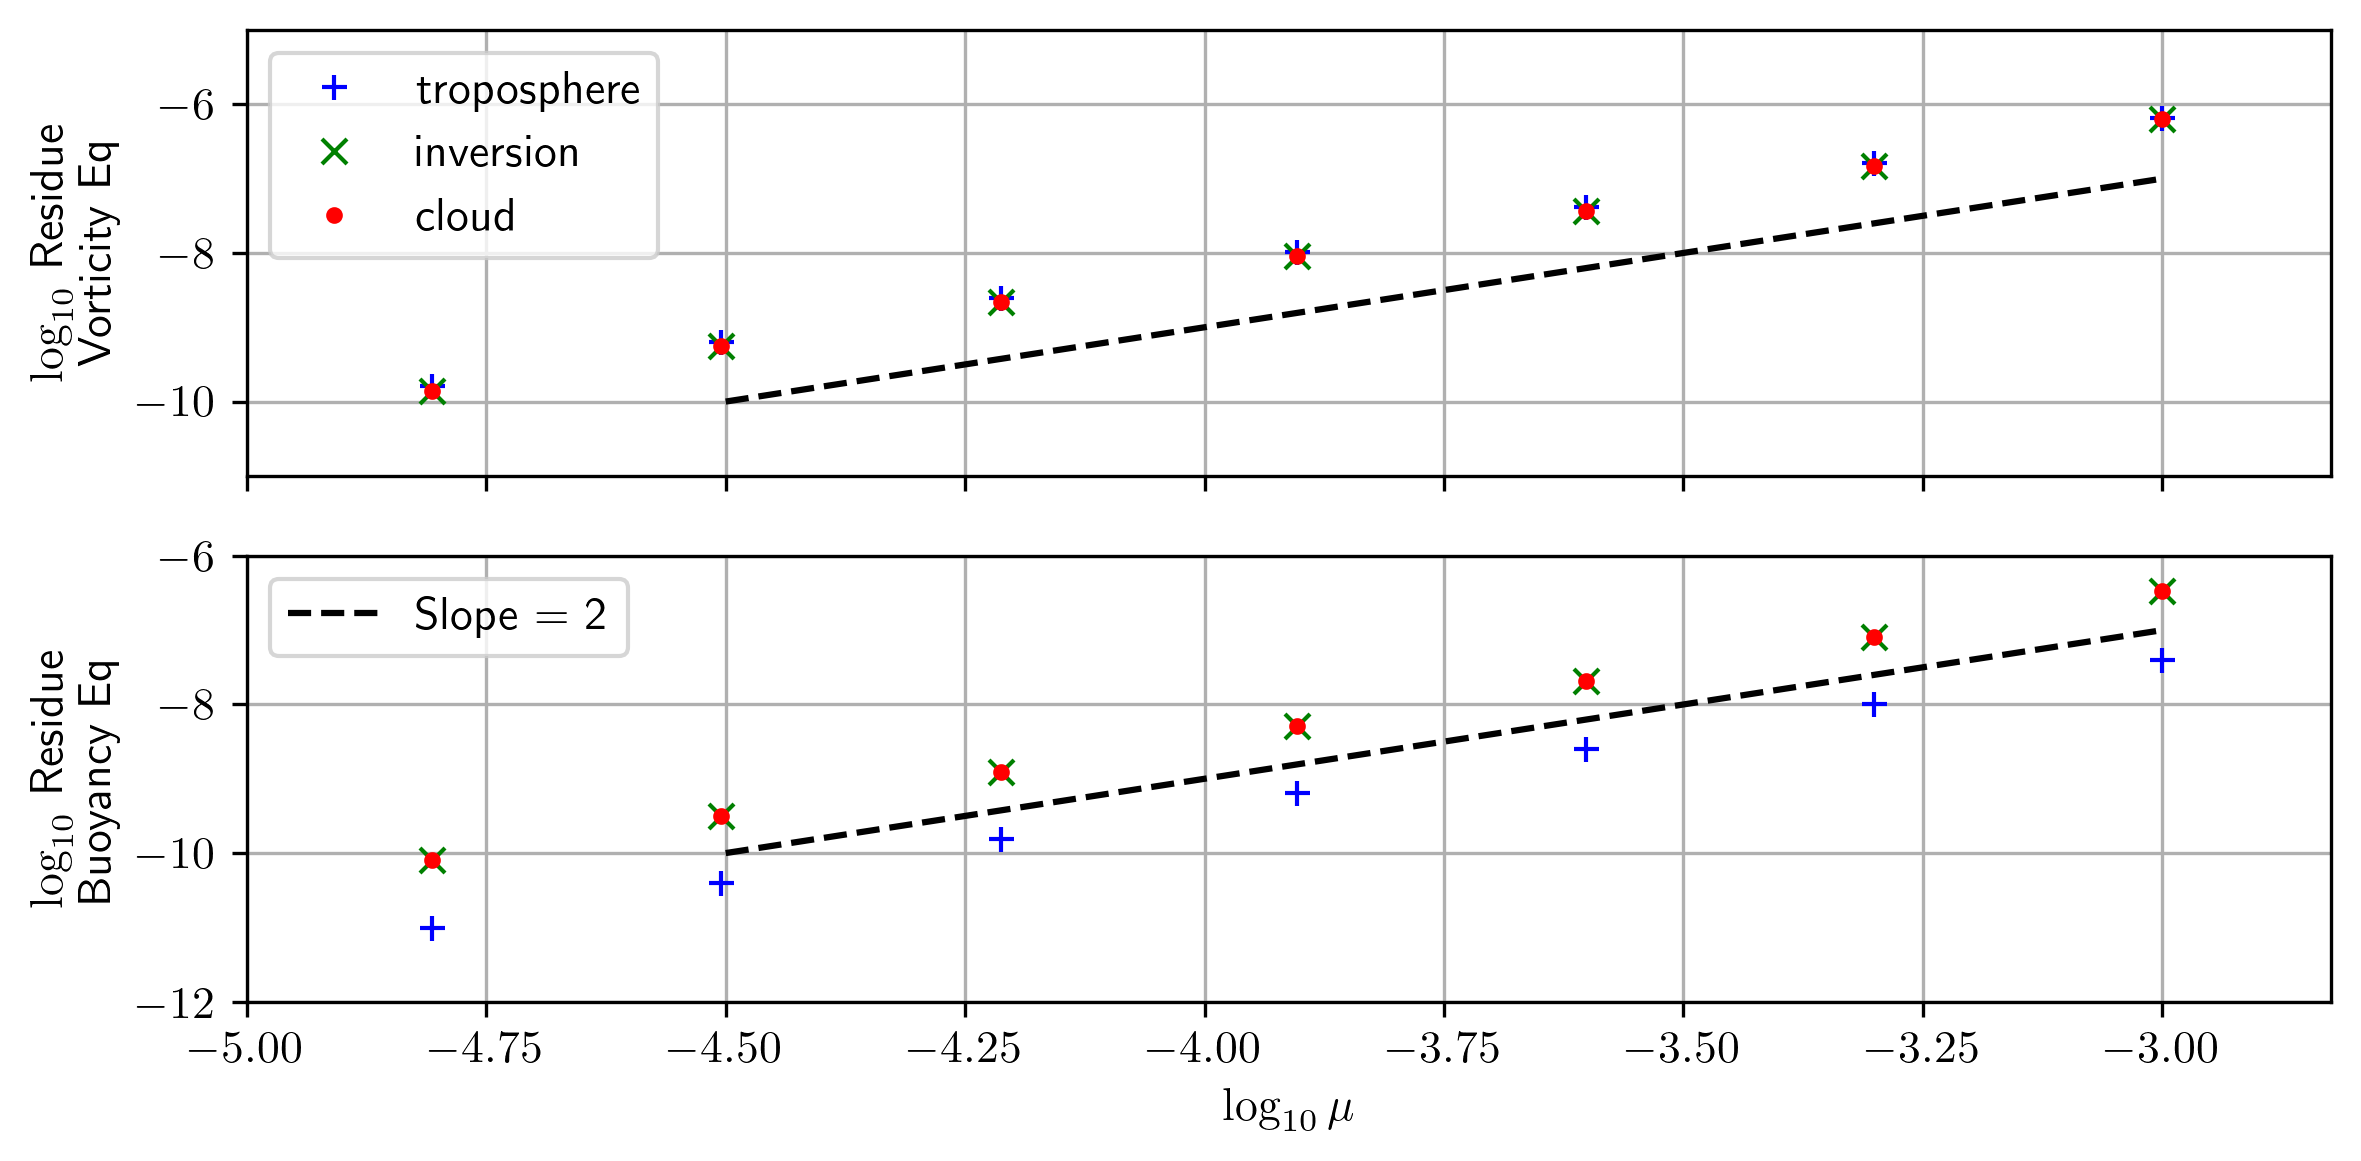

In [27]:
# Plotting
fig, axes = plt.subplots(nrows=2, layout='tight', sharex=True)
fig.set_dpi(300)
fig.set_size_inches(8,4)

axes[0].plot(np.log10(np.array(sig_list)), np.log10(np.array(vort_res_t_vals)), '+b', label='troposphere')
axes[0].plot(np.log10(np.array(sig_list)), np.log10(np.array(vort_res_i_vals)), 'xg', label='inversion')
axes[0].plot(np.log10(np.array(sig_list)), np.log10(np.array(vort_res_i_vals)), '.r', label='cloud')
axes[0].plot((-4.5,-3.), (-10., -7.), linestyle='--', color='k')
axes[0].grid()
axes[0].legend()
axes[0].set(ylim=(-11, -5))
axes[0].set(ylabel=r'$\log_{10}$ Residue'+'\nVorticity Eq')

axes[1].plot(np.log10(np.array(sig_list)), np.log10(np.array(buoy_res_t_vals)), '+b')
axes[1].plot(np.log10(np.array(sig_list)), np.log10(np.array(buoy_res_i_vals)), 'xg')
axes[1].plot(np.log10(np.array(sig_list)), np.log10(np.array(buoy_res_i_vals)), '.r')
axes[1].plot((-4.5,-3.), (-10., -7.), linestyle='--', color='k', label='Slope = 2')
axes[1].grid()
axes[1].set(xlim=(np.log10(0.01e-3),np.log10(0.15e-2)), ylim=(-12, -6))
axes[1].set(xlabel=r'$\log_{10}\mu$', ylabel=r'$\log_{10}$ Residue'+'\nBuoyancy Eq')
axes[1].legend()

plt.show()

In [28]:
# Compute a numerical approximation of the L2 norm along a nonlinear interface
# (either cloud or inversion boundary) 1D - 64 grid points used.
#
# inputs:
#       f      - sympy expression to be evaluated
#       Z      - sympy expression for the interface displacement (Zc or Zi)
#       k_tol  - composite wave number (k_val + sig*del_k)
#       t_val  - time coordinate to evaluate at
#       sigma  - nonlinear parameter (mu in my thesis)
#       H      - Nominal height of the interface (Hc or Hi)
# returns:
#       ||f||  - L2 norm of f along the nonlinear interface
def L2_interface_NL(f, Z, k_tot, t_val=0., sigma=0.1, H=0.):
    xx = np.linspace(0.0, 2*np.pi/k_tot, endpoint=False, num=64)
    dx = xx[1]-xx[0]
    val_dict = {
        k:   k_val,
        om:  om_val,
        sig: sigma,
        t:   t_val,
        L:   0.5
    }
    zz = sigma*sym.lambdify(x, Z.subs(val_dict))(xx) + H
    return np.sqrt(np.sum(np.abs(sym_to_eval_2D(f, zz, xx, t_val, sigma=sigma))**2))*dx

# Symbolically compute the residual of the kinematic/modified kinematic equation (3.7) and (3.8)
#
# inputs:
#       psi - sympy expression for the nonlinear streamfunction solution
#       Z   - sympy expression for the interface displacement (Zc or Zi)
#       L   - latent heat response (0 for material interface)
# returns:
#       res - residual of the kinematic/modified kinematic equation using the given solution functions
def kinNL_res(psi, Z, L):
    return sym.diff(Z, t) - sig*sym.diff(psi, z)*sym.diff(Z, x) - (1+L)*sym.diff(psi, x)

# Symbolically compute the jump in psi (psi top - psi bottom)
#
# inputs:
#       psi_T - sympy expression for the nonlinear streamfunction in the top region
#       psi_B - sympy expression for the nonlinear streamfunction in the bottom region
# returns:
#       res   - jump in psi
def psi_contNL_res(psi_T, psi_B):
    return psi_T - psi_B

# Symbolically compute the jump in the z-derivative of psi (psi_z top - psi_z bottom)
#
# inputs:
#       psi_T - sympy expression for the nonlinear streamfunction in the top region
#       psi_B - sympy expression for the nonlinear streamfunction in the bottom region
# returns:
#       res   - jump in psi_z
def psi_z_contNL_res(psi_T, psi_B):
    return sym.diff(psi_T,z) - sym.diff(psi_B, z)

# Symbolically compute the jump in p_x (note that really we want to compute the
# jump in the tangential derivative of p but the p_z terms don't change anything
# at first correction which is where we see a discontinuity.)
#
# inputs:
#       psi_T - sympy expression for the nonlinear streamfunction in the top region
#       psi_B - sympy expression for the nonlinear streamfunction in the bottom region
# returns:
#       res   - jump in p_x
def prs_contNL_res(psi_T, psi_B):
    del_psi = psi_T - psi_B
    term1 = sym.diff(del_psi, z, t)
    Jac_T = sym.diff(psi_T, x)*sym.diff(psi_T, z, z) - sym.diff(psi_T, z)*sym.diff(psi_T, z, x)
    Jac_B = sym.diff(psi_B, x)*sym.diff(psi_B, z, z) - sym.diff(psi_B, z)*sym.diff(psi_B, z, x)
    return term1 + sig*Jac_T - sig*Jac_B

In [29]:
#Put together the nonlinear interface displacement (Only need to go to first correction for this one)
Zi   = (A*Zih_0 + A_x*Zih_X + A_t*Zih_T)*sym.exp(I*(k*x - om*t)) \
     +sym.conjugate((A*Zih_0 + A_x*Zih_X + A_t*Zih_T)*sym.exp(I*(k*x - om*t))) \
     +sig*(A*Ast*Zih_10 + A**2*Zih_12*sym.exp(2*I*(k*x - om*t))         \
                     + Ast**2*sym.conjugate(Zih_12)*sym.exp(-2*I*(k*x - om*t)) )

Zi = Zi.subs({k:k_val, om:om_val}).simplify()

Zc = (A*Zch_0 + A_x*Zch_X + A_t*Zch_T)*sym.exp(I*(k*x - om*t)) \
     +sym.conjugate((A*Zch_0 + A_x*Zch_X + A_t*Zch_T)*sym.exp(I*(k*x - om*t))) \
     +sig*(A*Ast*Zch_10 + A**2*Zch_12*sym.exp(2*I*(k*x - om*t))         \
                     + Ast**2*sym.conjugate(Zch_12)*sym.exp(-2*I*(k*x - om*t)) )

Zc = Zc.subs({k:k_val, om:om_val, L:0.5}).simplify()

**Test kinematic Equation Convergence**

In [30]:
# Convergence test for the kinematic (3.7) and modified kinematic (3.8) equations.
# We have the full solution up to first correction (only the first harmonic for second correction)
# therefore we are expecting order mu^2 residuals.

#First compute the residues there are 4 cases
#   1) inversion edge psi in the troposphere
#   2) inversion edge psi in the inversion
#   3) cloud edge psi in the inversion
#   4) cloud edge psi in the cloud

sig_list = [1e-3, 0.5e-3, 0.25e-3, 0.125e-3, 0.06125e-3, 0.03125e-3, 0.015625e-3]
print('computing residue for the inversion edge...')
kinNL_res_inversion_t = kinNL_res(psi_t, Zi, L=0.0)
kinNL_res_inversion_i = kinNL_res(psi_i, Zi, L=0.0)
print('Evaluating at mu points...')
kinNL_res_inversion_t_vals = [L2_interface_NL(kinNL_res_inversion_t, Zi, k_val+del_k*sig_val, 1.0, sigma=sig_val, H=Hi) for sig_val in sig_list]
kinNL_res_inversion_i_vals = [L2_interface_NL(kinNL_res_inversion_i, Zi, k_val+del_k*sig_val, 1.0, sigma=sig_val, H=Hi) for sig_val in sig_list]
print()
print('computing residue for the cloud edge...')
kinNL_res_cloud_i = kinNL_res(psi_i, Zc, L=0.5)
kinNL_res_cloud_c = kinNL_res(psi_c, Zc, L=0.5)
print('Evaluating at mu points...')
kinNL_res_cloud_i_vals = [L2_interface_NL(kinNL_res_cloud_i, Zc, k_val+del_k*sig_val, 1.0, sigma=sig_val, H=Hc) for sig_val in sig_list]
kinNL_res_cloud_c_vals = [L2_interface_NL(kinNL_res_cloud_c, Zc, k_val+del_k*sig_val, 1.0, sigma=sig_val, H=Hc) for sig_val in sig_list]

computing residue for the inversion edge...
Evaluating at mu points...

computing residue for the cloud edge...
Evaluating at mu points...


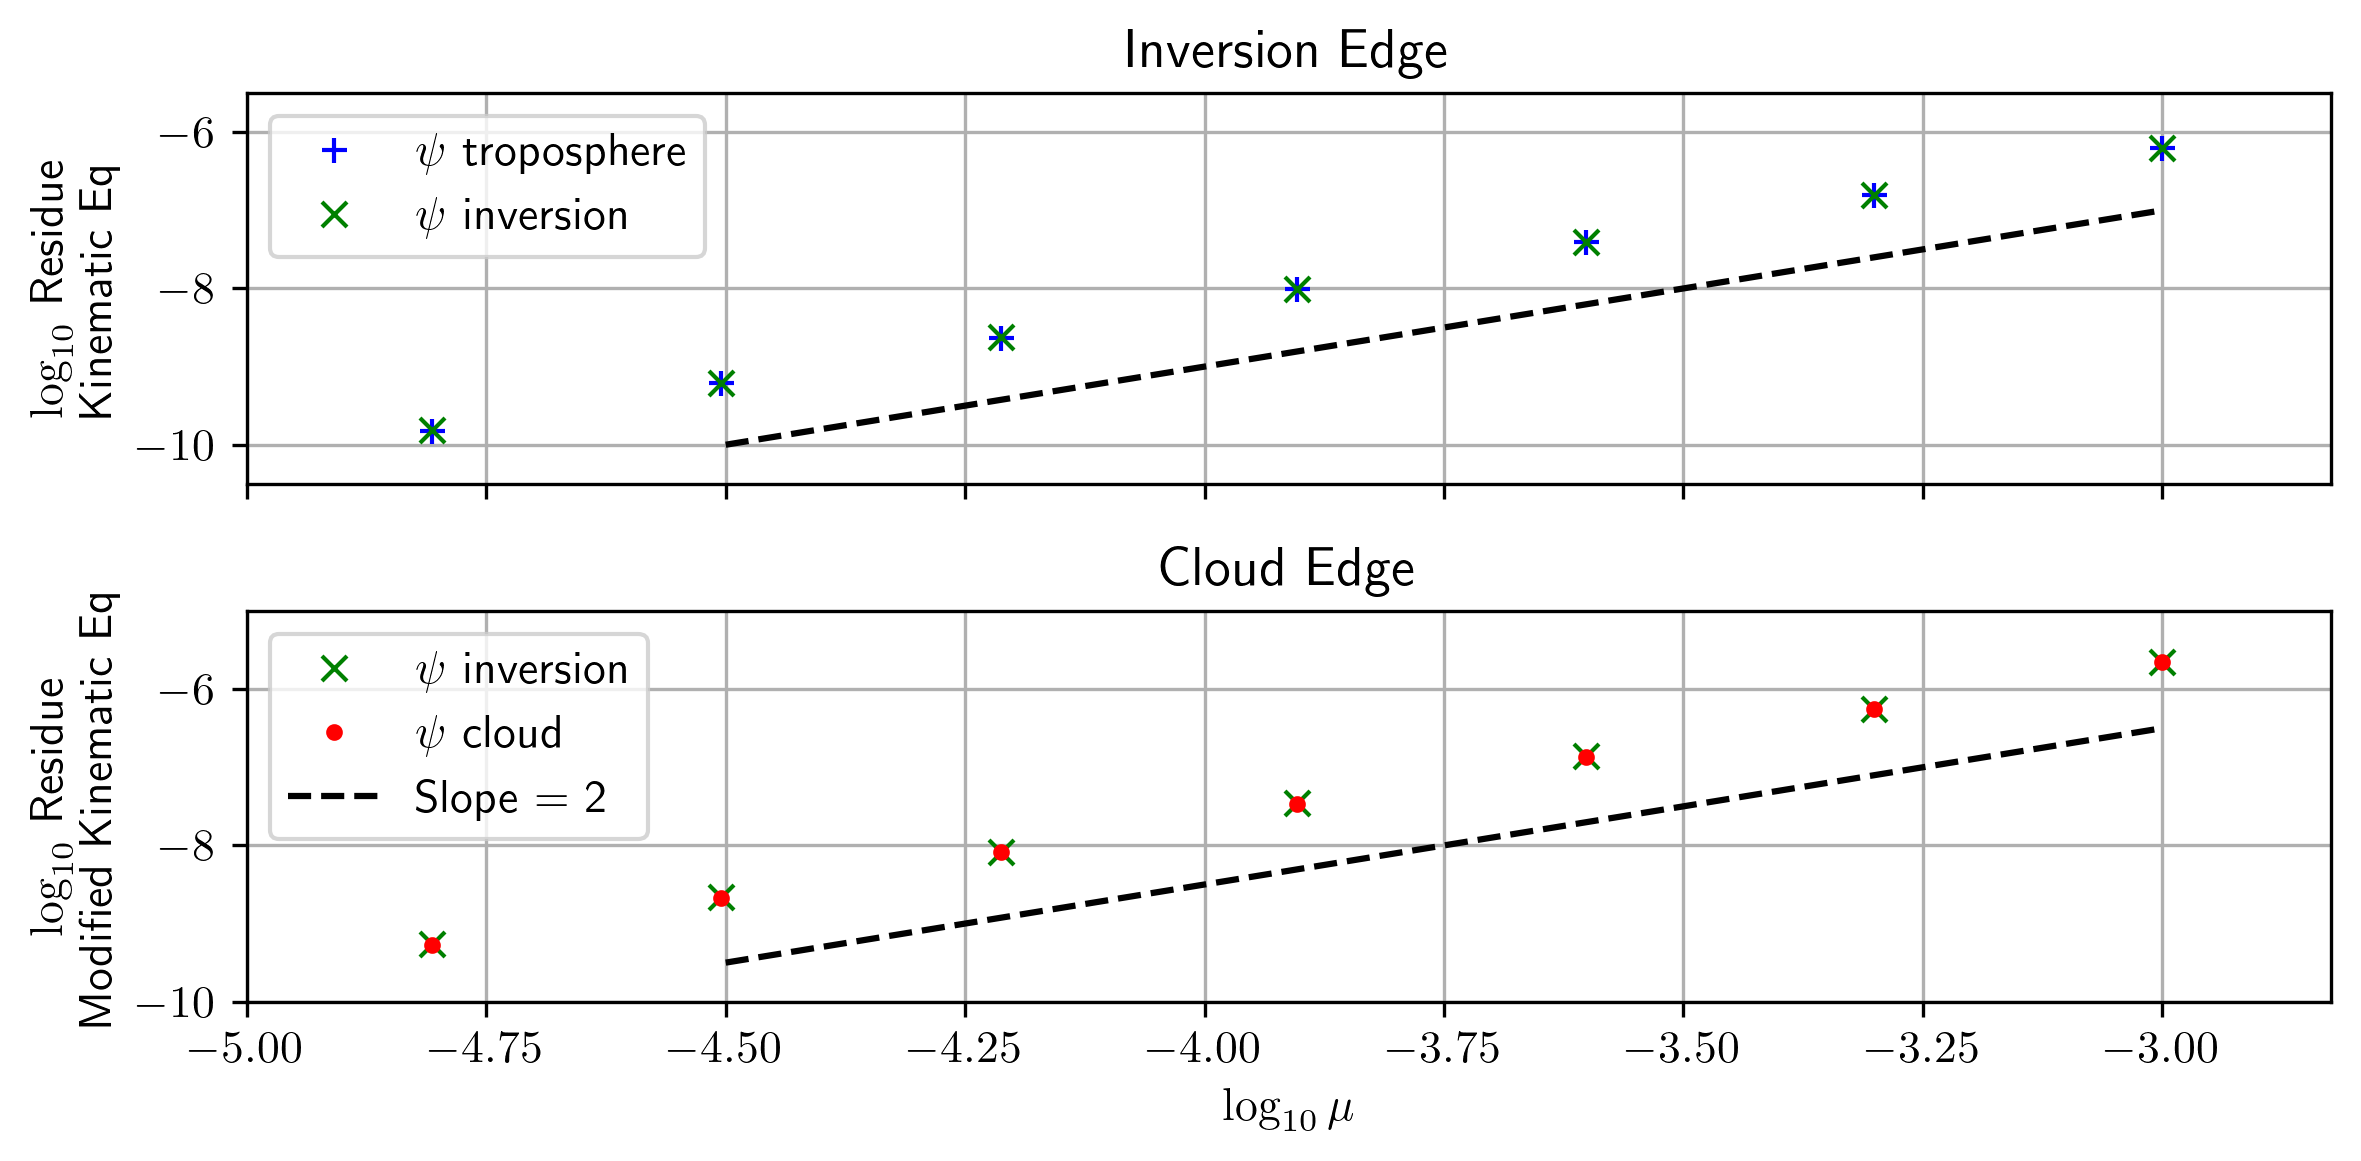

In [31]:
# Plotting
fig, axes = plt.subplots(nrows=2, layout='tight', sharex=True)
fig.set_dpi(300)
fig.set_size_inches(8,4)

axes[0].plot(np.log10(np.array(sig_list)), np.log10(np.array(kinNL_res_inversion_t_vals)), '+b', label=r'$\psi$ troposphere')
axes[0].plot(np.log10(np.array(sig_list)), np.log10(np.array(kinNL_res_inversion_i_vals)), 'xg', label=r'$\psi$ inversion')
axes[0].plot((-4.5,-3.), (-10., -7.), linestyle='--', color='k')
axes[0].grid()
axes[0].legend()
axes[0].set(ylim=(-10.5, -5.5))
axes[0].set(ylabel=r'$\log_{10}$ Residue'+'\nKinematic Eq', title='Inversion Edge')

axes[1].plot(np.log10(np.array(sig_list)), np.log10(np.array(kinNL_res_cloud_i_vals)), 'xg', label=r'$\psi$ inversion')
axes[1].plot(np.log10(np.array(sig_list)), np.log10(np.array(kinNL_res_cloud_c_vals)), '.r', label=r'$\psi$ cloud')
axes[1].plot((-4.5,-3.), (-9.5, -6.5), linestyle='--', color='k', label='Slope = 2')
axes[1].grid()
axes[1].set(xlim=(np.log10(0.01e-3),np.log10(0.15e-2)), ylim=(-10., -5.))
axes[1].set(xlabel=r'$\log_{10}\mu$', ylabel=r'$\log_{10}$ Residue'+'\nModified Kinematic Eq', title='Cloud Edge')
axes[1].legend()

plt.show()

**Convergence Test of Interface Conditions**

In [32]:
# Convergence test for the interface continuity conditions.
# We have the full solution up to first correction (only the first harmonic for second correction)
# therefore we are expecting order mu^2 residuals for the continuous ones psi and psi_z.
# At the material interface prs continuity is equivalent to psi and psi_z continuity so we get mu^2 there.
# At the cloud interface this is not the case so we only get order mu there (they're equivalent at the linear interface only).

#First compute the residues

sig_list = [1e-3, 0.5e-3, 0.25e-3, 0.125e-3, 0.06125e-3, 0.03125e-3, 0.015625e-3]
print('computing residue psi continuity...')
psi_contNL_res_i = psi_contNL_res(psi_t, psi_i)
psi_contNL_res_c = psi_contNL_res(psi_i, psi_c)
print('Evaluating at mu points...')
psi_contNL_res_i_vals = [L2_interface_NL(psi_contNL_res_i, Zi, k_val+del_k*sig_val, 1.0, sigma=sig_val, H=Hi) for sig_val in sig_list]
psi_contNL_res_c_vals = [L2_interface_NL(psi_contNL_res_c, Zc, k_val+del_k*sig_val, 1.0, sigma=sig_val, H=Hc) for sig_val in sig_list]
print()
print('computing residue psi_z continuity...')
psi_z_contNL_res_i = psi_z_contNL_res(psi_t, psi_i)
psi_z_contNL_res_c = psi_z_contNL_res(psi_i, psi_c)
print('Evaluating at mu points...')
psi_z_contNL_res_i_vals = [L2_interface_NL(psi_z_contNL_res_i, Zi, k_val+del_k*sig_val, 1.0, sigma=sig_val, H=Hi) for sig_val in sig_list]
psi_z_contNL_res_c_vals = [L2_interface_NL(psi_z_contNL_res_c, Zc, k_val+del_k*sig_val, 1.0, sigma=sig_val, H=Hc) for sig_val in sig_list]
print()
print('computing residue prs continuity... (be patient this will take a few minutes)')
prs_contNL_res_i = prs_contNL_res(psi_t, psi_i)
prs_contNL_res_c = prs_contNL_res(psi_i, psi_c)
print('Evaluating at mu points...')
prs_contNL_res_i_vals = [L2_interface_NL(prs_contNL_res_i, Zi, k_val+del_k*sig_val, 1.0, sigma=sig_val, H=Hi) for sig_val in sig_list]
prs_contNL_res_c_vals = [L2_interface_NL(prs_contNL_res_c, Zc, k_val+del_k*sig_val, 1.0, sigma=sig_val, H=Hc) for sig_val in sig_list]
print()

computing residue psi continuity...
Evaluating at mu points...

computing residue psi_z continuity...
Evaluating at mu points...

computing residue prs continuity... (be patient this will take a few minutes)
Evaluating at mu points...



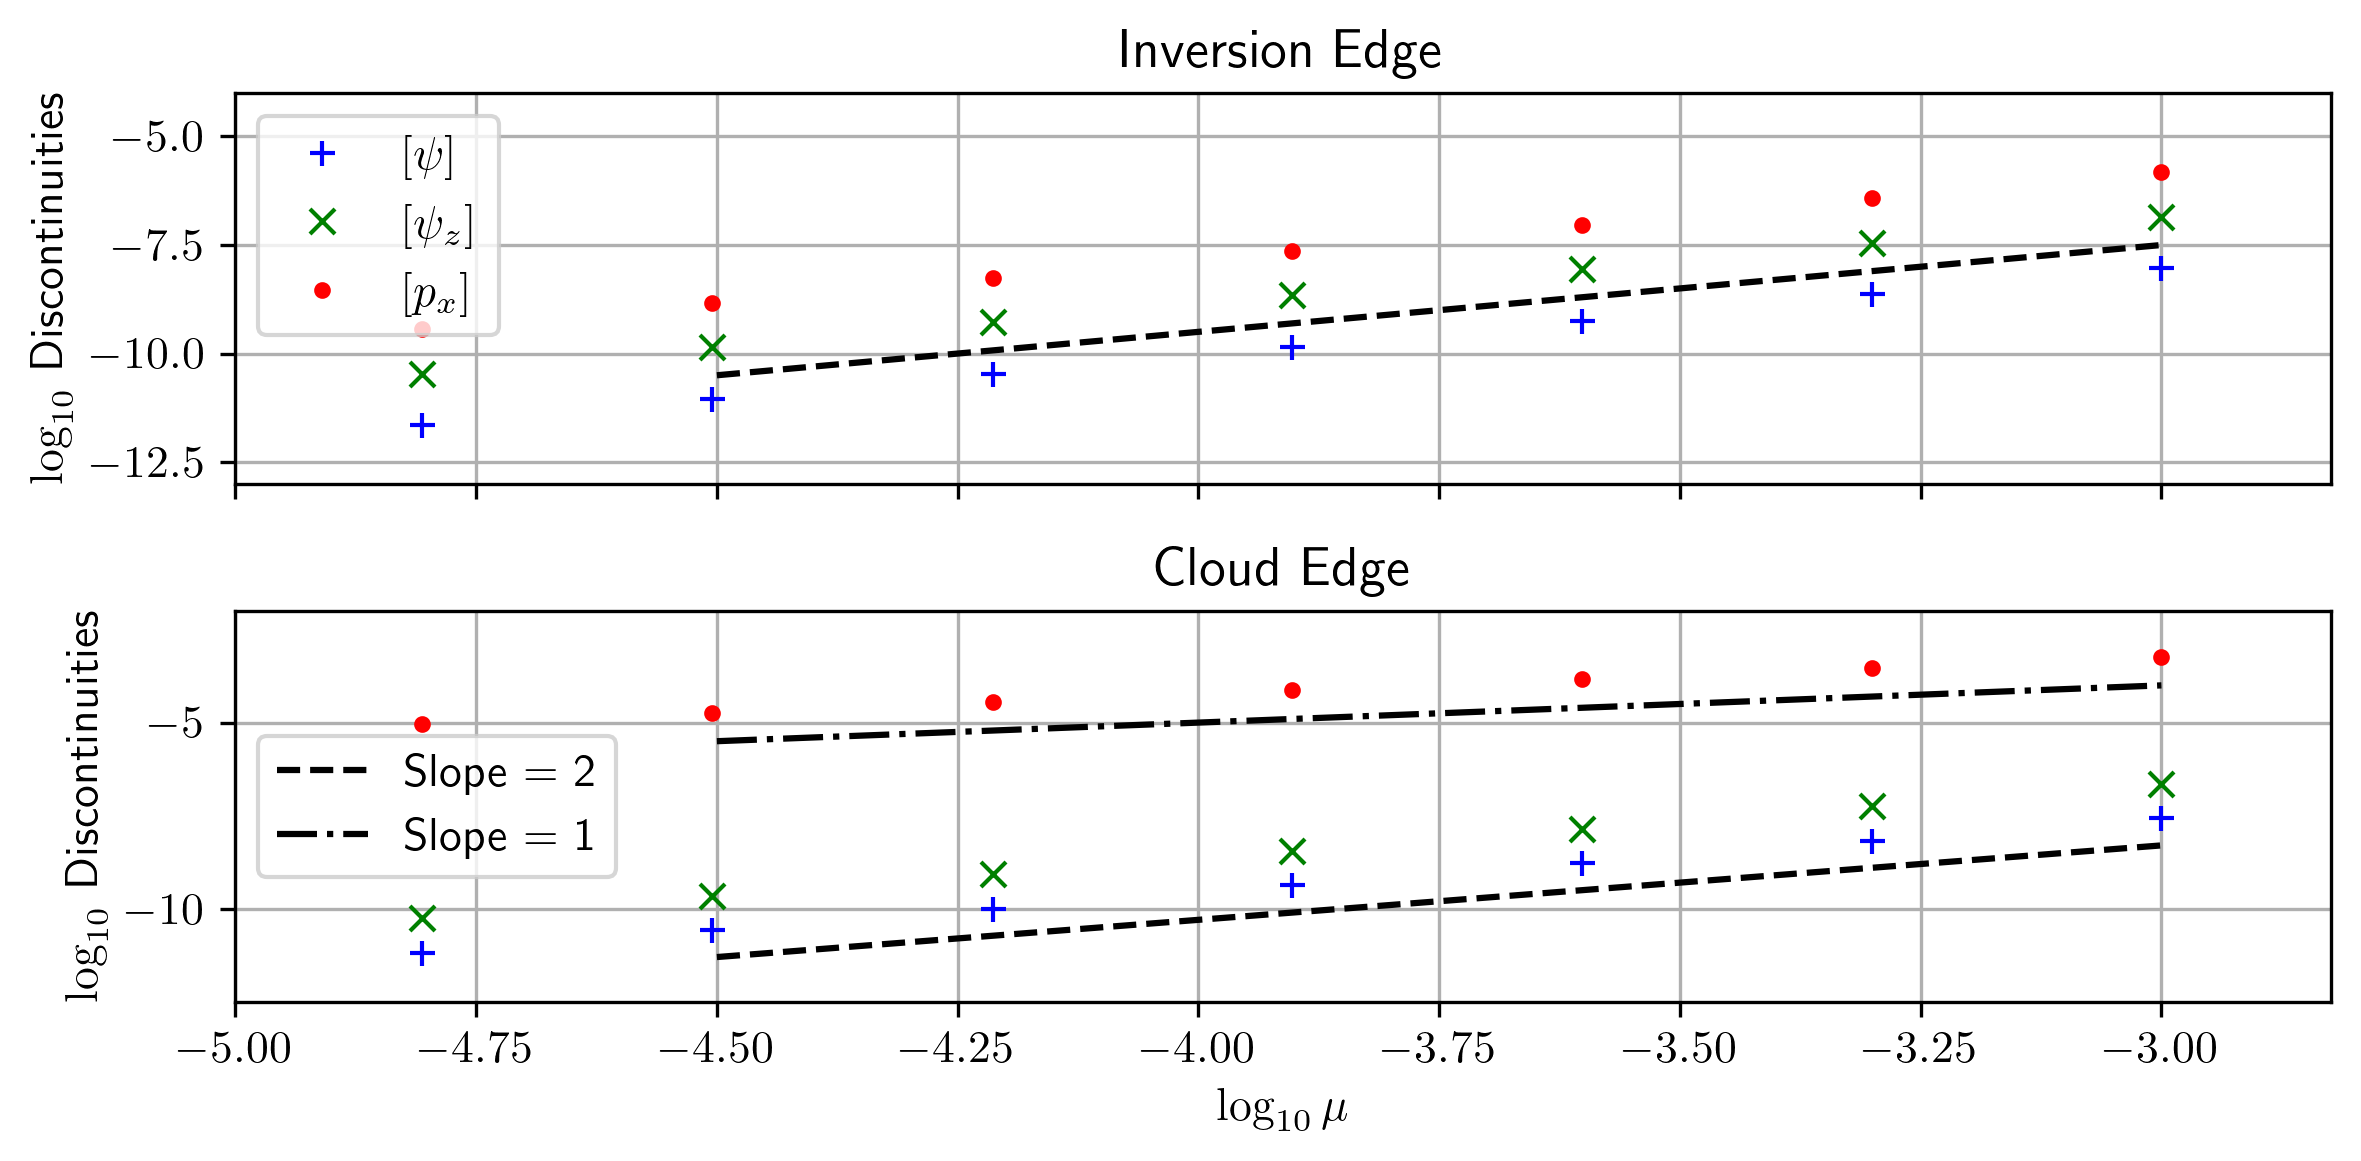

In [33]:
# Plotting
fig, axes = plt.subplots(nrows=2, layout='tight', sharex=True)
fig.set_dpi(300)
fig.set_size_inches(8,4)

axes[0].plot(np.log10(np.array(sig_list)), np.log10(np.array(psi_contNL_res_i_vals)), '+b', label=r'$[\psi]$')
axes[0].plot(np.log10(np.array(sig_list)), np.log10(np.array(psi_z_contNL_res_i_vals)), 'xg', label=r'$[\psi_z]$')
axes[0].plot(np.log10(np.array(sig_list)), np.log10(np.array(prs_contNL_res_i_vals)), '.r', label=r'$[p_x]$')
axes[0].plot((-4.5,-3.), (-10.5, -7.5), linestyle='--', color='k')
axes[0].grid()
axes[0].legend()
axes[0].set(ylim=(-13, -4))
axes[0].set(ylabel=r'$\log_{10}$ Discontinuities', title='Inversion Edge')

axes[1].plot(np.log10(np.array(sig_list)), np.log10(np.array(psi_contNL_res_c_vals)), '+b')
axes[1].plot(np.log10(np.array(sig_list)), np.log10(np.array(psi_z_contNL_res_c_vals)), 'xg')
axes[1].plot(np.log10(np.array(sig_list)), np.log10(np.array(prs_contNL_res_c_vals)), '.r')
axes[1].plot((-4.5,-3.), (-11.3, -8.3), linestyle='--', color='k', label='Slope = 2')
axes[1].plot((-4.5,-3.), (-5.5, -4.0), linestyle='-.', color='k', label='Slope = 1')
axes[1].grid()
axes[1].set(xlim=(np.log10(0.01e-3),np.log10(0.15e-2)), ylim=(-12.5, -2.))
axes[1].set(xlabel=r'$\log_{10}\mu$', ylabel=r'$\log_{10}$ Discontinuities', title='Cloud Edge')
axes[1].legend()

plt.show()

**Convergence Tests on Each Harmonic**

We expect that the first harmonic and mean mode (in some cases) will have an order better convergence than the second harmonic. This section uses FFTs to seperate out those modes to test their convergence.

In [34]:
# Compute a numerical approximation of the L2 norm for a
# particular Fourier mode (1D in z with 64 points).
#
# inputs:
#       f           - sympy expression to be evaluated
#       zrange      - tuple with the start and end zpoints
#       k_tol       - composite wave number (k_val + sig*del_k)
#       t_val       - time coordinate to evaluate at
#       sigma       - nonlinear parameter (mu in my thesis)
#       harmonic    - Fourier mode to evaluate
# returns:
#       ||\hat{f}|| - L2 norm of the specified fourier mode
def L2_2D_FFT(f, zrange, k_tot, t_val=0., sigma=0.1, harmonic=1):
    zz = np.linspace(zrange[0], zrange[1], num=64)
    dz = zz[1]-zz[0]
    xx = np.linspace(0.0, 2*np.pi/k_tot, endpoint=False, num=32)
    xx, zz = np.meshgrid(xx, zz)
    f_mode = sfft.fft(sym_to_eval_2D(f, zz, xx, t_val, sigma=sigma), axis=1)[:,harmonic]
    return np.sqrt(np.sum(np.abs(f_mode)**2))*dz

# Compute the magnitude of a given fourier mode along a nonlinear interface
# (either cloud or inversion boundary).
#
# inputs:
#       f           - sympy expression to be evaluated
#       Z           - sympy expression for the interface displacement (Zc or Zi)
#       k_tol       - composite wave number (k_val + sig*del_k)
#       t_val       - time coordinate to evaluate at
#       sigma       - nonlinear parameter (mu in my thesis)
#       harmonic    - Fourier mode to evaluate
#       H           - Nominal height of the interface (Hc or Hi)
# returns:
#       |\hat{f}|   - magintude of the fourier coefficient 
#                     associated with the specified harmonic
def L2_interface_NL_FFT(f, Z, k_tot, t_val=0., sigma=0.1, harmonic=1, H=0.):
    xx = np.linspace(0.0, 2*np.pi/k_tot, endpoint=False, num=64)
    val_dict = {
        k:   k_val,
        om:  om_val,
        sig: sigma,
        t:   t_val,
        L:   0.5
    }
    zz = sigma*sym.lambdify(x, Z.subs(val_dict))(xx) + H
    f_mode = sfft.fft(sym_to_eval_2D(f, zz, xx, t_val, sigma=sigma))[harmonic]
    return np.abs(f_mode)

**Vorticity and Buoyancy Equations**

In [35]:
#First compute the L2 norm of each of the zero, first and second harmonics

print('Evaluating at mu points mean mode... (be patient this takes minutes)')

#We need to use larger values of sigma for this mode
sig_list0 = [4, 2, 1, 0.5, 0.25]

vort_res0_t_vals = [L2_2D_FFT(vort_res_t, (Hi, HT), k_val+del_k*sig_val, 1.0, sigma=sig_val, harmonic=0) for sig_val in sig_list0]
buoy_res0_t_vals = [L2_2D_FFT(buoy_res_t, (Hi, HT), k_val+del_k*sig_val, 1.0, sigma=sig_val, harmonic=0) for sig_val in sig_list0]

vort_res0_i_vals = [L2_2D_FFT(vort_res_i, (Hc, Hi), k_val+del_k*sig_val, 1.0, sigma=sig_val, harmonic=0) for sig_val in sig_list0]
buoy_res0_i_vals = [L2_2D_FFT(buoy_res_i, (Hc, Hi), k_val+del_k*sig_val, 1.0, sigma=sig_val, harmonic=0) for sig_val in sig_list0]

vort_res0_c_vals = [L2_2D_FFT(vort_res_c, (0, Hc), k_val+del_k*sig_val, 1.0, sigma=sig_val, harmonic=0) for sig_val in sig_list0]
buoy_res0_c_vals = [L2_2D_FFT(buoy_res_c, (0, Hc), k_val+del_k*sig_val, 1.0, sigma=sig_val, harmonic=0) for sig_val in sig_list0]

print('Evaluating at mu points first harmonic... (be patient this takes minutes)')

vort_res1_t_vals = [L2_2D_FFT(vort_res_t, (Hi, HT), k_val+del_k*sig_val, 1.0, sigma=sig_val, harmonic=1) for sig_val in sig_list]
buoy_res1_t_vals = [L2_2D_FFT(buoy_res_t, (Hi, HT), k_val+del_k*sig_val, 1.0, sigma=sig_val, harmonic=1) for sig_val in sig_list]

vort_res1_i_vals = [L2_2D_FFT(vort_res_i, (Hc, Hi), k_val+del_k*sig_val, 1.0, sigma=sig_val, harmonic=1) for sig_val in sig_list]
buoy_res1_i_vals = [L2_2D_FFT(buoy_res_i, (Hc, Hi), k_val+del_k*sig_val, 1.0, sigma=sig_val, harmonic=1) for sig_val in sig_list]

vort_res1_c_vals = [L2_2D_FFT(vort_res_c, (0, Hc), k_val+del_k*sig_val, 1.0, sigma=sig_val, harmonic=1) for sig_val in sig_list]
buoy_res1_c_vals = [L2_2D_FFT(buoy_res_c, (0, Hc), k_val+del_k*sig_val, 1.0, sigma=sig_val, harmonic=1) for sig_val in sig_list]

print('Evaluating at mu points second harmonic... (be patient this takes minutes)')

vort_res2_t_vals = [L2_2D_FFT(vort_res_t, (Hi, HT), k_val+del_k*sig_val, 1.0, sigma=sig_val, harmonic=2) for sig_val in sig_list]
buoy_res2_t_vals = [L2_2D_FFT(buoy_res_t, (Hi, HT), k_val+del_k*sig_val, 1.0, sigma=sig_val, harmonic=2) for sig_val in sig_list]

vort_res2_i_vals = [L2_2D_FFT(vort_res_i, (Hc, Hi), k_val+del_k*sig_val, 1.0, sigma=sig_val, harmonic=2) for sig_val in sig_list]
buoy_res2_i_vals = [L2_2D_FFT(buoy_res_i, (Hc, Hi), k_val+del_k*sig_val, 1.0, sigma=sig_val, harmonic=2) for sig_val in sig_list]

vort_res2_c_vals = [L2_2D_FFT(vort_res_c, (0, Hc), k_val+del_k*sig_val, 1.0, sigma=sig_val, harmonic=2) for sig_val in sig_list]
buoy_res2_c_vals = [L2_2D_FFT(buoy_res_c, (0, Hc), k_val+del_k*sig_val, 1.0, sigma=sig_val, harmonic=2) for sig_val in sig_list]


Evaluating at mu points mean mode... (be patient this takes minutes)
Evaluating at mu points first harmonic... (be patient this takes minutes)
Evaluating at mu points second harmonic... (be patient this takes minutes)


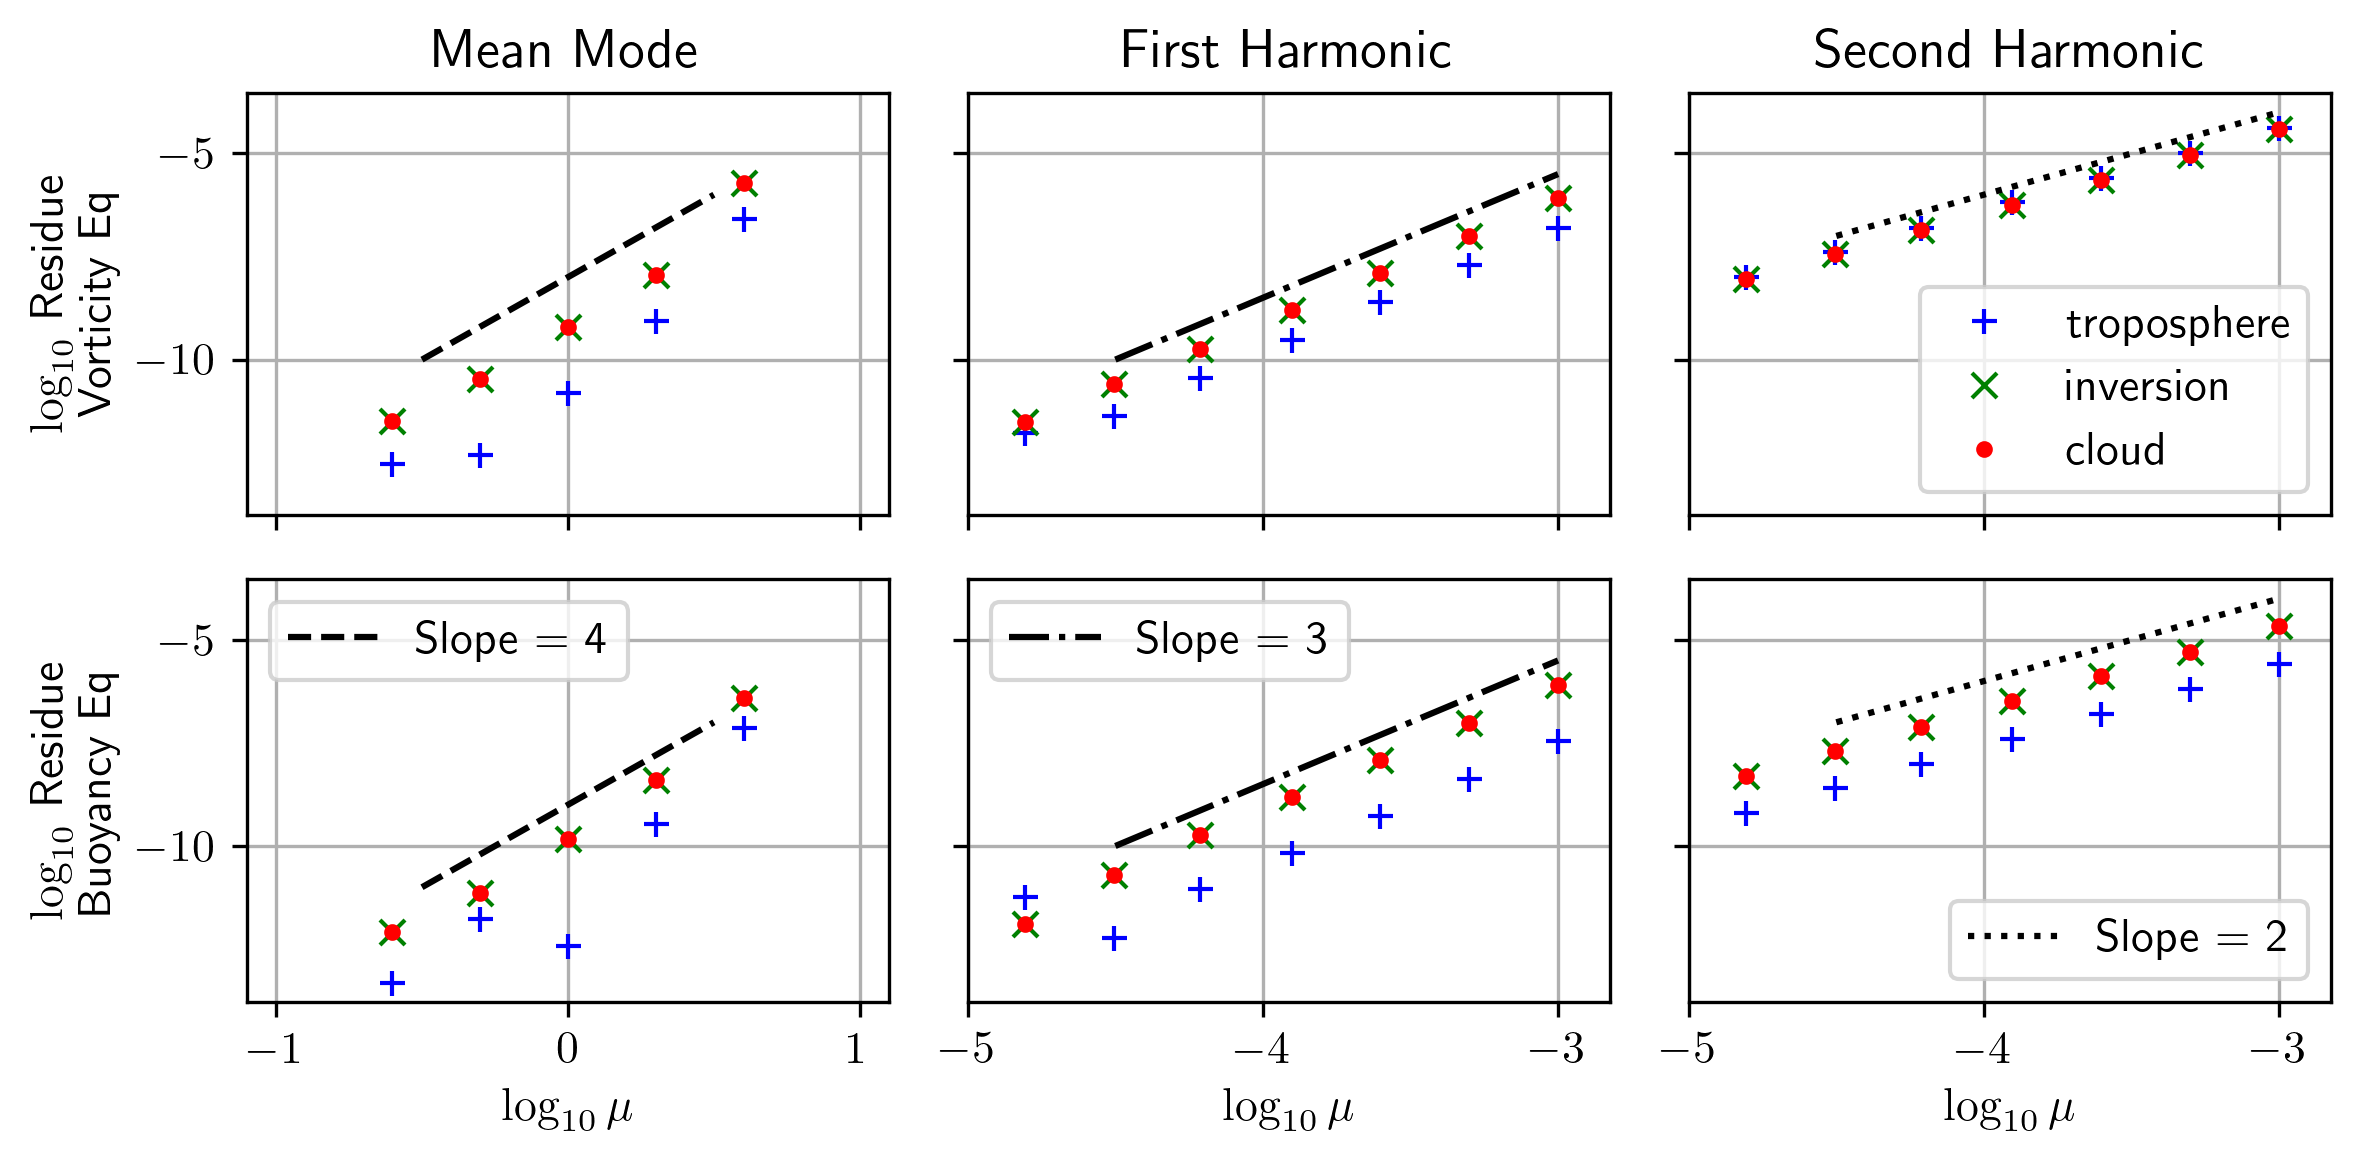

In [36]:
# Plotting
# The key points here are:
#      - third order (or better?) convergence for mean and first harmonic
#      - second order convergence for second harmonic
fig, axes = plt.subplots(nrows=2, ncols=3, layout='tight', sharey=True)
fig.set_dpi(300)
fig.set_size_inches(8,4)

axes[0,0].plot(np.log10(np.array(sig_list0)), np.log10(np.array(vort_res0_t_vals)), '+b', label='troposphere')
axes[0,0].plot(np.log10(np.array(sig_list0)), np.log10(np.array(vort_res0_i_vals)), 'xg', label='inversion')
axes[0,0].plot(np.log10(np.array(sig_list0)), np.log10(np.array(vort_res0_i_vals)), '.r', label='cloud')
axes[0,0].plot((-0.5,0.5), (-10., -6.), linestyle='--', color='k')
axes[0,0].grid()
axes[0,0].set(xlim=(-1.1, 1.1))
axes[0,0].set_xticklabels([])
axes[0,0].set(ylabel=r'$\log_{10}$ Residue'+'\nVorticity Eq', title='Mean Mode')

axes[1,0].plot(np.log10(np.array(sig_list0)), np.log10(np.array(buoy_res0_t_vals)), '+b')
axes[1,0].plot(np.log10(np.array(sig_list0)), np.log10(np.array(buoy_res0_i_vals)), 'xg')
axes[1,0].plot(np.log10(np.array(sig_list0)), np.log10(np.array(buoy_res0_i_vals)), '.r')
axes[1,0].plot((-0.5,0.5), (-11., -7.), linestyle='--', color='k', label='Slope = 4')
axes[1,0].grid()
axes[1,0].set(xlim=(-1.1, 1.1))
axes[1,0].set(xlabel=r'$\log_{10}\mu$', ylabel=r'$\log_{10}$ Residue'+'\nBuoyancy Eq')
axes[1,0].legend(loc='upper left')

axes[0,1].plot(np.log10(np.array(sig_list)), np.log10(np.array(vort_res1_t_vals)), '+b', label='troposphere')
axes[0,1].plot(np.log10(np.array(sig_list)), np.log10(np.array(vort_res1_i_vals)), 'xg', label='inversion')
axes[0,1].plot(np.log10(np.array(sig_list)), np.log10(np.array(vort_res1_i_vals)), '.r', label='cloud')
axes[0,1].plot((-4.5,-3.), (-10., -5.5), linestyle='-.', color='k', label='Slope = 3')
axes[0,1].grid()
axes[0,1].set(xlim=(np.log10(0.01e-3),np.log10(0.15e-2)))
axes[0,1].set_xticklabels([])
axes[0,1].set(title='First Harmonic')

axes[1,1].plot(np.log10(np.array(sig_list)), np.log10(np.array(buoy_res1_t_vals)), '+b')
axes[1,1].plot(np.log10(np.array(sig_list)), np.log10(np.array(buoy_res1_i_vals)), 'xg')
axes[1,1].plot(np.log10(np.array(sig_list)), np.log10(np.array(buoy_res1_i_vals)), '.r')
axes[1,1].plot((-4.5,-3.), (-10., -5.5), linestyle='-.', color='k', label='Slope = 3')
axes[1,1].grid()
axes[1,1].set(xlim=(np.log10(0.01e-3),np.log10(0.15e-2)))
axes[1,1].set(xlabel=r'$\log_{10}\mu$')
axes[1,1].legend(loc='upper left')

axes[0,2].plot(np.log10(np.array(sig_list)), np.log10(np.array(vort_res2_t_vals)), '+b', label='troposphere')
axes[0,2].plot(np.log10(np.array(sig_list)), np.log10(np.array(vort_res2_i_vals)), 'xg', label='inversion')
axes[0,2].plot(np.log10(np.array(sig_list)), np.log10(np.array(vort_res2_i_vals)), '.r', label='cloud')
axes[0,2].plot((-4.5,-3.), (-7., -4.), linestyle=':', color='k')
axes[0,2].grid()
axes[0,2].legend(loc='lower right')
axes[0,2].set(xlim=(np.log10(0.01e-3),np.log10(0.15e-2)))
axes[0,2].set_xticklabels([])
axes[0,2].set(title='Second Harmonic')

axes[1,2].plot(np.log10(np.array(sig_list)), np.log10(np.array(buoy_res2_t_vals)), '+b')
axes[1,2].plot(np.log10(np.array(sig_list)), np.log10(np.array(buoy_res2_i_vals)), 'xg')
axes[1,2].plot(np.log10(np.array(sig_list)), np.log10(np.array(buoy_res2_i_vals)), '.r')
axes[1,2].plot((-4.5,-3.), (-7., -4.), linestyle=':', color='k', label='Slope = 2')
axes[1,2].grid()
axes[1,2].set(xlim=(np.log10(0.01e-3),np.log10(0.15e-2)))
axes[1,2].set(xlabel=r'$\log_{10}\mu$')
axes[1,2].legend(loc='lower right')

plt.show()

**Continuity conditions at the nonlinear interface**

In [37]:
#First compute the L2 norm of each of the zero, first and second harmonics

#We need larger mu's again
sig_list_int = [0.1, 0.05, 0.025, 0.0125, 0.006125, 0.003125, 0.0015625]

print('Evaluating at mu points mean mode... (be patient this takes a minute)')

psi_contNL_res0_i_vals   = [L2_interface_NL_FFT(psi_contNL_res_i,   Zi, k_val+del_k*sig_val, 1.0, sigma=sig_val, harmonic=0, H=Hi) for sig_val in sig_list_int]
psi_z_contNL_res0_i_vals = [L2_interface_NL_FFT(psi_z_contNL_res_i, Zi, k_val+del_k*sig_val, 1.0, sigma=sig_val, harmonic=0, H=Hi) for sig_val in sig_list_int]

psi_contNL_res0_c_vals   = [L2_interface_NL_FFT(psi_contNL_res_c,   Zc, k_val+del_k*sig_val, 1.0, sigma=sig_val, harmonic=0, H=Hc) for sig_val in sig_list_int]
psi_z_contNL_res0_c_vals = [L2_interface_NL_FFT(psi_z_contNL_res_c, Zc, k_val+del_k*sig_val, 1.0, sigma=sig_val, harmonic=0, H=Hc) for sig_val in sig_list_int]

print('Evaluating at mu points First Harmonic... (be patient this takes a minute)')

psi_contNL_res1_i_vals   = [L2_interface_NL_FFT(psi_contNL_res_i,   Zi, k_val+del_k*sig_val, 1.0, sigma=sig_val, harmonic=1, H=Hi) for sig_val in sig_list_int]
psi_z_contNL_res1_i_vals = [L2_interface_NL_FFT(psi_z_contNL_res_i, Zi, k_val+del_k*sig_val, 1.0, sigma=sig_val, harmonic=1, H=Hi) for sig_val in sig_list_int]

psi_contNL_res1_c_vals   = [L2_interface_NL_FFT(psi_contNL_res_c,   Zc, k_val+del_k*sig_val, 1.0, sigma=sig_val, harmonic=1, H=Hc) for sig_val in sig_list_int]
psi_z_contNL_res1_c_vals = [L2_interface_NL_FFT(psi_z_contNL_res_c, Zc, k_val+del_k*sig_val, 1.0, sigma=sig_val, harmonic=1, H=Hc) for sig_val in sig_list_int]


print('Evaluating at mu points Second Harmonic... (be patient this takes a minute)')

psi_contNL_res2_i_vals   = [L2_interface_NL_FFT(psi_contNL_res_i,   Zi, k_val+del_k*sig_val, 1.0, sigma=sig_val, harmonic=2, H=Hi) for sig_val in sig_list_int]
psi_z_contNL_res2_i_vals = [L2_interface_NL_FFT(psi_z_contNL_res_i, Zi, k_val+del_k*sig_val, 1.0, sigma=sig_val, harmonic=2, H=Hi) for sig_val in sig_list_int]

psi_contNL_res2_c_vals   = [L2_interface_NL_FFT(psi_contNL_res_c,   Zc, k_val+del_k*sig_val, 1.0, sigma=sig_val, harmonic=2, H=Hc) for sig_val in sig_list_int]
psi_z_contNL_res2_c_vals = [L2_interface_NL_FFT(psi_z_contNL_res_c, Zc, k_val+del_k*sig_val, 1.0, sigma=sig_val, harmonic=2, H=Hc) for sig_val in sig_list_int]

Evaluating at mu points mean mode... (be patient this takes a minute)
Evaluating at mu points First Harmonic... (be patient this takes a minute)
Evaluating at mu points Second Harmonic... (be patient this takes a minute)


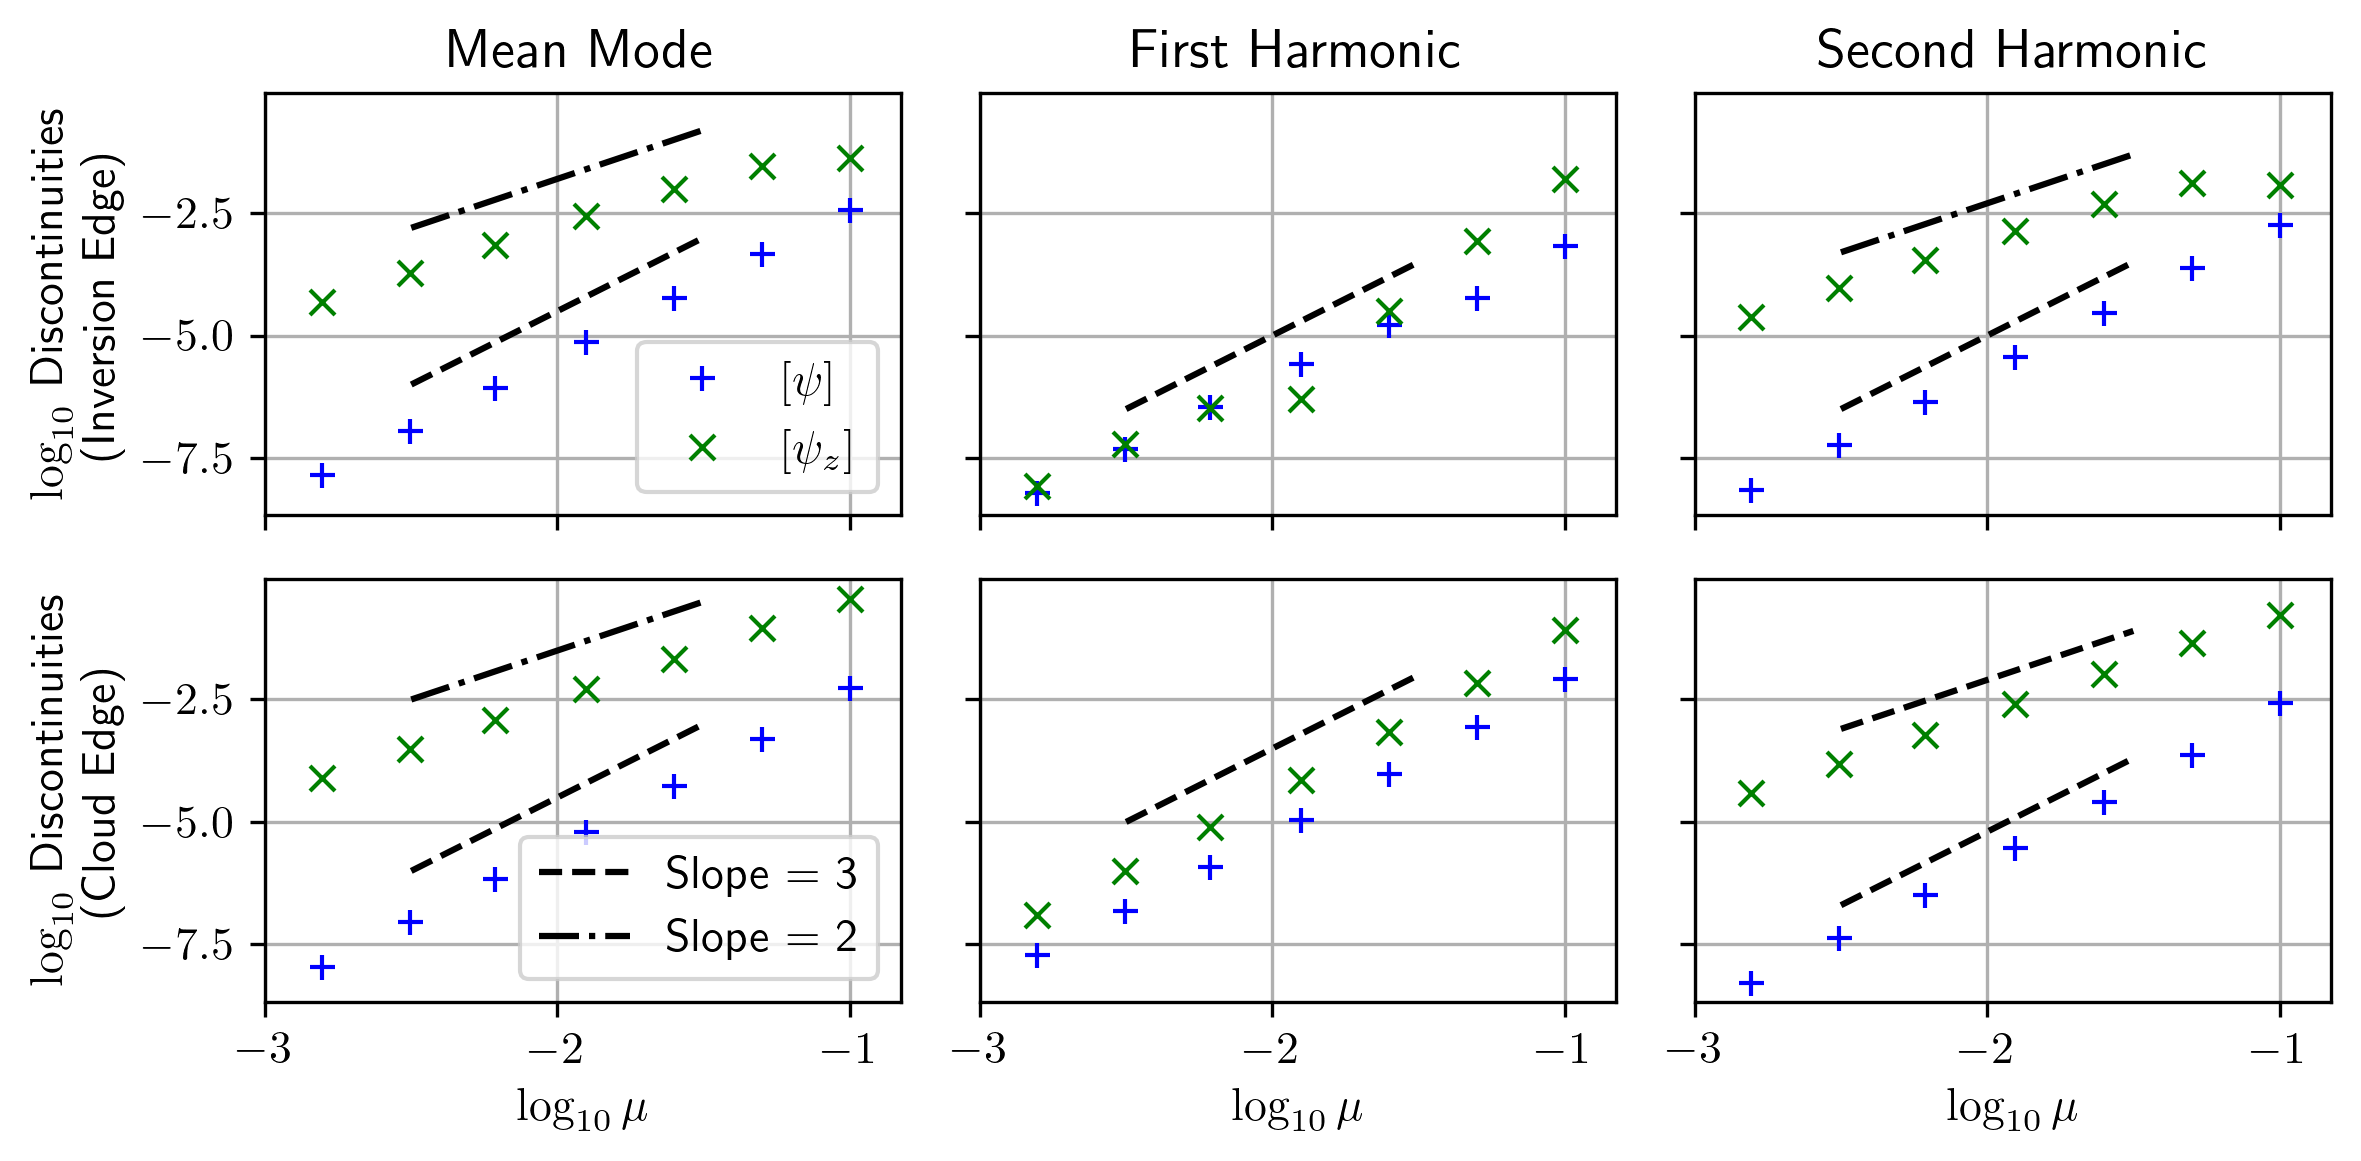

In [38]:
# Plotting
# Key here is that the first harmonic is third order convergent
# We expect mean and second harmonic to be second order but
# because the second correction to Zi and Zc for the first harmonic hasn't
# been included we get an extra order of convergence for [psi].
fig, axes = plt.subplots(nrows=2, ncols=3, layout='tight', sharex=True, sharey=True)
fig.set_dpi(300)
fig.set_size_inches(8,4)

axes[0,0].plot(np.log10(np.array(sig_list_int)), np.log10(np.array(psi_contNL_res0_i_vals)), '+b', label=r'$[\psi]$')
axes[0,0].plot(np.log10(np.array(sig_list_int)), np.log10(np.array(psi_z_contNL_res0_i_vals)), 'xg', label=r'$[\psi_z]$')
axes[0,0].plot((-2.5,-1.5), (-6., -3.), linestyle='--', color='k')
axes[0,0].plot((-2.5,-1.5), (-2.8, -0.8), linestyle='-.', color='k')
axes[0,0].grid()
axes[0,0].legend()
axes[0,0].set(ylabel=r'$\log_{10}$ Discontinuities' + '\n(Inversion Edge)', title='Mean Mode')

axes[1,0].plot(np.log10(np.array(sig_list_int)), np.log10(np.array(psi_contNL_res0_c_vals)), '+b')
axes[1,0].plot(np.log10(np.array(sig_list_int)), np.log10(np.array(psi_z_contNL_res0_c_vals)), 'xg')
axes[1,0].plot((-2.5,-1.5), (-6., -3.), linestyle='--', color='k', label='Slope = 3')
axes[1,0].plot((-2.5,-1.5), (-2.5, -0.5), linestyle='-.', color='k', label='Slope = 2')
axes[1,0].grid()
axes[1,0].set(xlim=(np.log10(0.01e-1),np.log10(0.15)))
axes[1,0].set(xlabel=r'$\log_{10}\mu$', ylabel=r'$\log_{10}$ Discontinuities' + '\n(Cloud Edge)')
axes[1,0].legend()

axes[0,1].plot(np.log10(np.array(sig_list_int)), np.log10(np.array(psi_contNL_res1_i_vals)), '+b', label=r'$[\psi]$')
axes[0,1].plot(np.log10(np.array(sig_list_int)), np.log10(np.array(psi_z_contNL_res1_i_vals)), 'xg', label=r'$[\psi_z]$')
axes[0,1].plot((-2.5,-1.5), (-6.5, -3.5), linestyle='--', color='k')
axes[0,1].grid()
axes[0,1].set(title='First Harmonic')

axes[1,1].plot(np.log10(np.array(sig_list_int)), np.log10(np.array(psi_contNL_res1_c_vals)), '+b')
axes[1,1].plot(np.log10(np.array(sig_list_int)), np.log10(np.array(psi_z_contNL_res1_c_vals)), 'xg')
axes[1,1].plot((-2.5,-1.5), (-5., -2.), linestyle='--', color='k')
axes[1,1].grid()
axes[1,1].set(xlabel=r'$\log_{10}\mu$')

axes[0,2].plot(np.log10(np.array(sig_list_int)), np.log10(np.array(psi_contNL_res2_i_vals)), '+b', label=r'$[\psi]$')
axes[0,2].plot(np.log10(np.array(sig_list_int)), np.log10(np.array(psi_z_contNL_res2_i_vals)), 'xg', label=r'$[\psi_z]$')
axes[0,2].plot((-2.5,-1.5), (-6.5, -3.5), linestyle='--', color='k')
axes[0,2].plot((-2.5,-1.5), (-3.3, -1.3), linestyle='-.', color='k')
axes[0,2].grid()
axes[0,2].set(title='Second Harmonic')

axes[1,2].plot(np.log10(np.array(sig_list_int)), np.log10(np.array(psi_contNL_res2_c_vals)), '+b')
axes[1,2].plot(np.log10(np.array(sig_list_int)), np.log10(np.array(psi_z_contNL_res2_c_vals)), 'xg')
axes[1,2].plot((-2.5,-1.5), (-6.7, -3.7), linestyle='--', color='k')
axes[1,2].plot((-2.5,-1.5), (-3.1, -1.1), linestyle='--', color='k')
axes[1,2].grid()
axes[1,2].set(xlabel=r'$\log_{10}\mu$')

plt.show()